In [1]:
%load_ext autoreload
%autoreload 2

import os 
import shutil
import numpy as n
from datetime import date
from matplotlib import pyplot as plt
import time
import napari

In [2]:
# path to wherever the s2p-lbm repository is cloned on your computer
os.chdir(os.path.dirname(os.path.abspath("")))

from suite3d.job import Job
from suite3d import lbmio, utils, ui
from suite3d import tiff_utils as tfu

In [3]:
## Find all the tiffiles in the tif path
# File I/O is pipelined, so the data doesn't have to be on a fast SSD 
# single HDDs or reasonably fast network drives should work without much difference in speed 
tif_path = r'/mnt/md0/data/demo'
tifs = tfu.get_tif_paths(tif_path)

In [4]:
# Set the mandatory parameters
params = {
    # volume rate
    'fs': tfu.get_vol_rate(tifs[0]),
    # planes to analyze. 0 is deepest, 30 is shallowest (corrected for ScanImage channel IDs)
    # you should keep all the planes to do crosstalk estimation! 
    'planes' : n.arange(30),
    # Decay time of the Ca indicator in seconds. 1.3 for GCaMP6s. This example is for GCamP8m
    'tau' : 1.3
}

### "Job" structure
The unimaginatively named `Job` structure is meant to contain all of the parameters, data, logs, and results for a single recording. It will be created in the root directory provided with the given name. All intermediate and final results will be saved in this directory, so I recommend using a fast SSD for this (and moving results to slow HDD once processing is complete).

All the print statements you see (and more) are also logged in `<job dir>/logfile.txt`. If you want things to look cleaner, reduce the verbosity to 2 (full logs will still be in the logfile).

To load a previously created job (to do more processing or load results), set `create=False`. If `create=True` but there exists another job of the same name in the root directory, it will either overwrite the parameters of the previous job or throw an error (depending on the `overwrite` parameter). Note, overwriting isn't as catastrophic as it sounds since data isn't deleted and remains accessible, but you might lose the saved parameters and some metadata.

In [5]:
# Create the job
job = Job('/mnt/md0/runs','Full-Demo', tifs = tifs,
          params=params, create=True, overwrite=True, verbosity = 3)

Job directory /mnt/md0/runs/s3d-Full-Demo already exists
Loading job directory for Full-Demo in /mnt/md0/runs
   Loading dirs 
      Found dir registered_data
      Found dir summary
      Found dir iters
   Loading default params
      Updating param fs
      Updating param planes
      Updating param tau
   Updated main params file


## Initial pass
This pass takes a few files (`n_init_files`, usually ~200-300 frames is enough) and does the following:
- estimates the crosstalk coefficient between the lower set of 15 planes and the higher 15 planes
- computes the shifts between successive planes caused by the xy-shift of the light beads
- estimates the optimal number of pixels that overlap between successive strips, so they can be fused together
- calculates a "reference volume" that will be used later in registration 

In [6]:
# optional parameters for initialization
# load 1 file to initialize
job.params['n_init_files'] = 1
# If set to None, use all of the frames in the loaded init files 
# if your files are really big, set this to <300
job.params['init_n_frames'] = None

# Set to None to auto-compute the crosstalk coefficient
# You can set a float value between 0-1 (usually around 0.1-0.3) to override the calculation
job.params['override_crosstalk'] = None
# number of processors to use
job.params['n_proc_corr'] = 20

In [7]:
%%time
# This step only uses `n_init_files` files, so the  runtime will stay the same even with larger recordings
# soon this will also be gpu-ified to be faster!
job.run_init_pass()

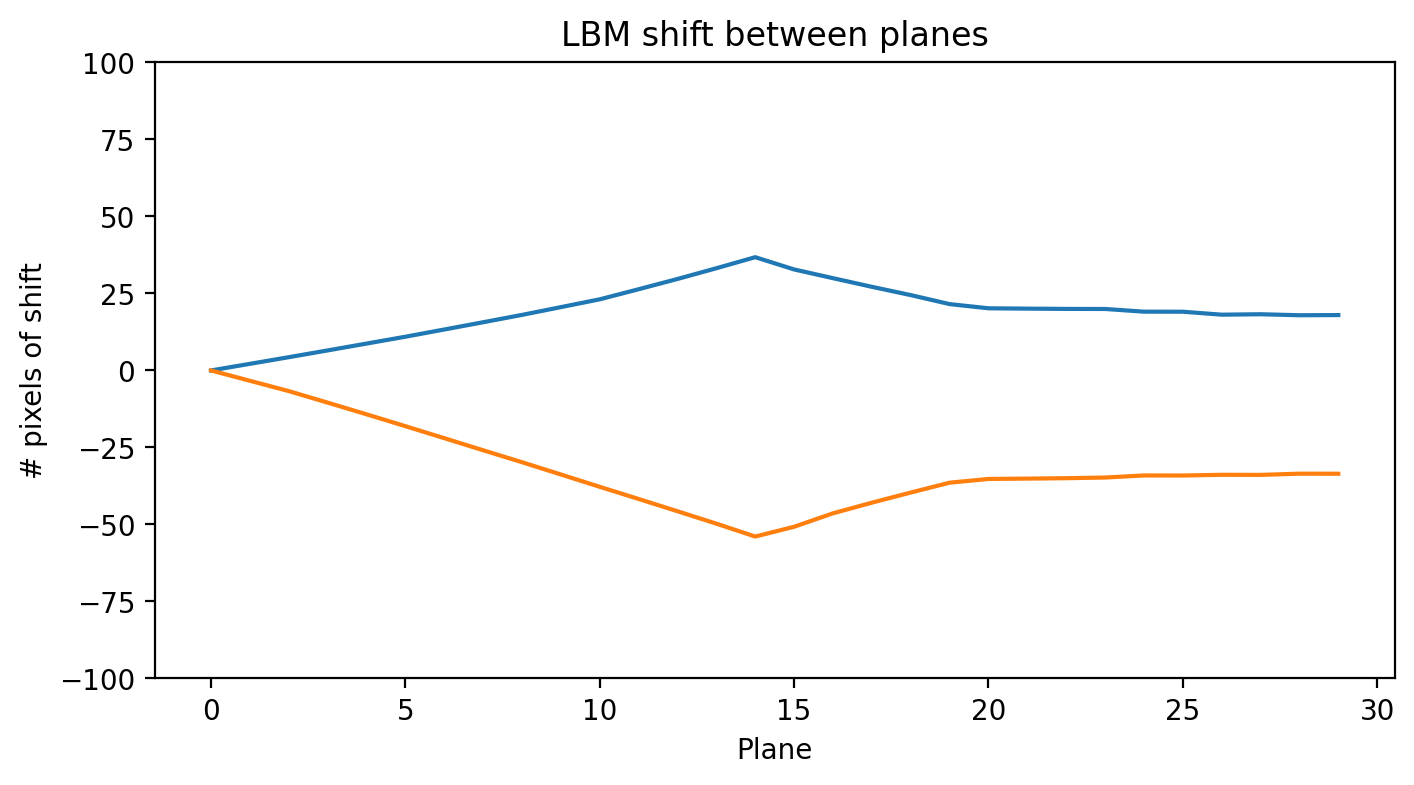

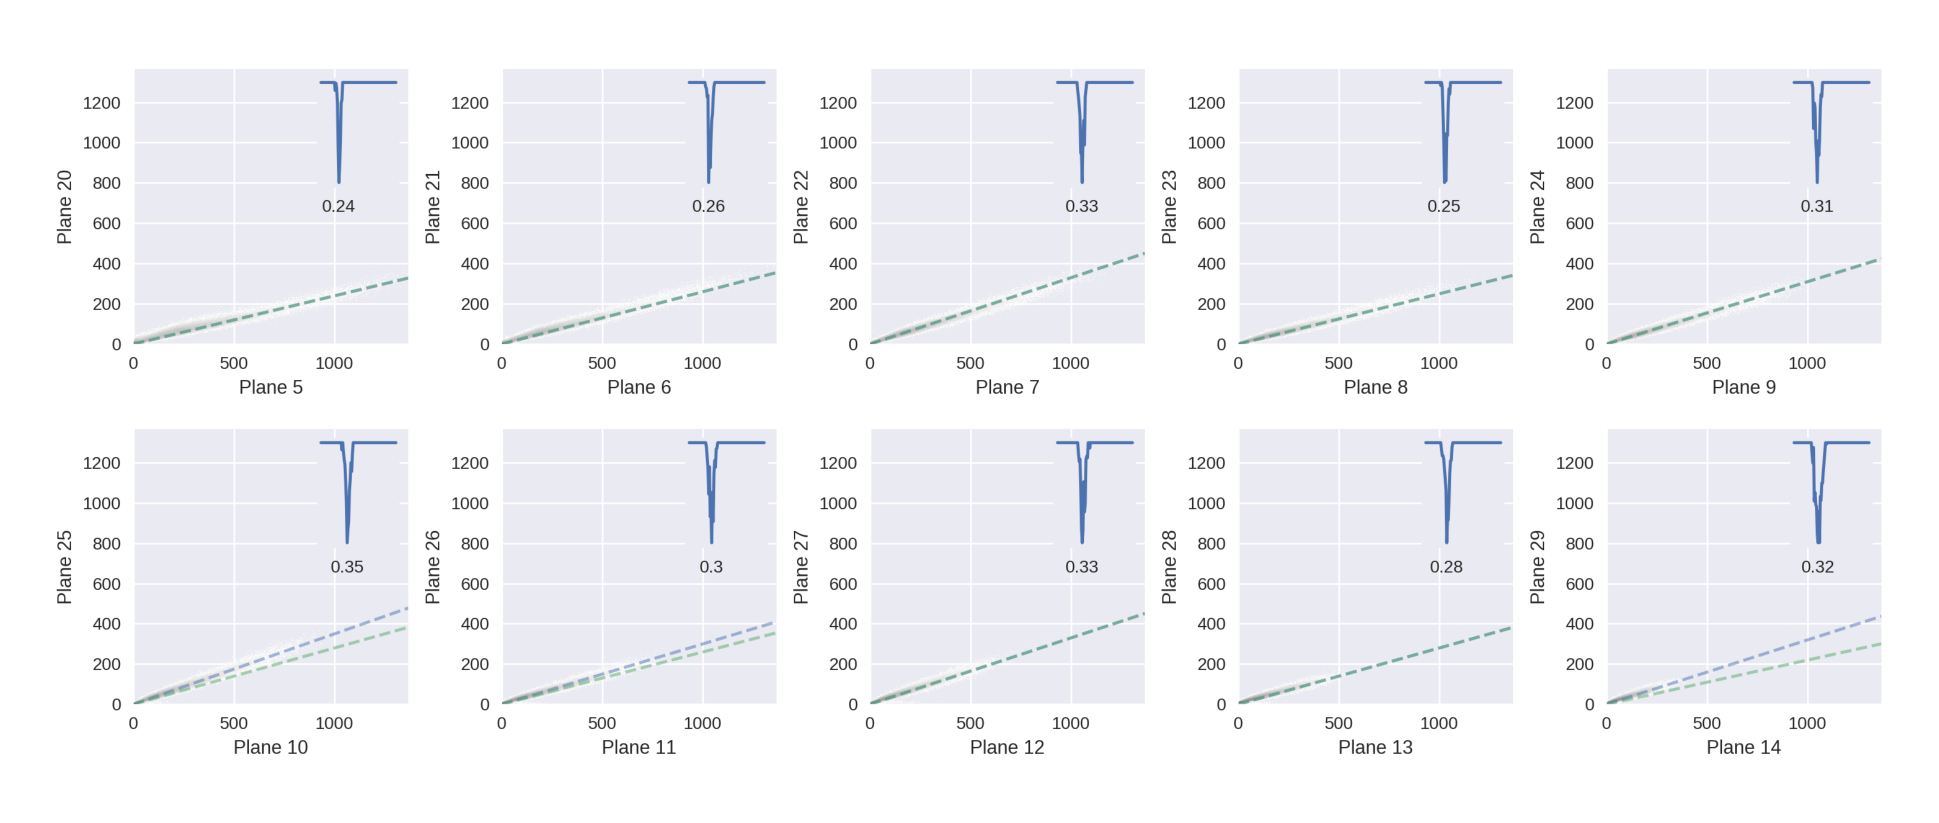

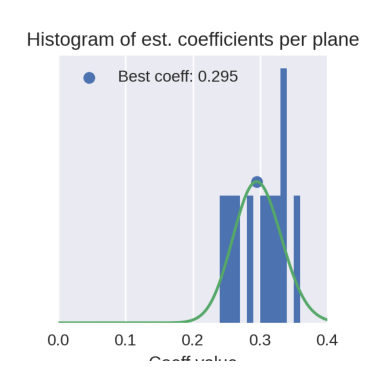

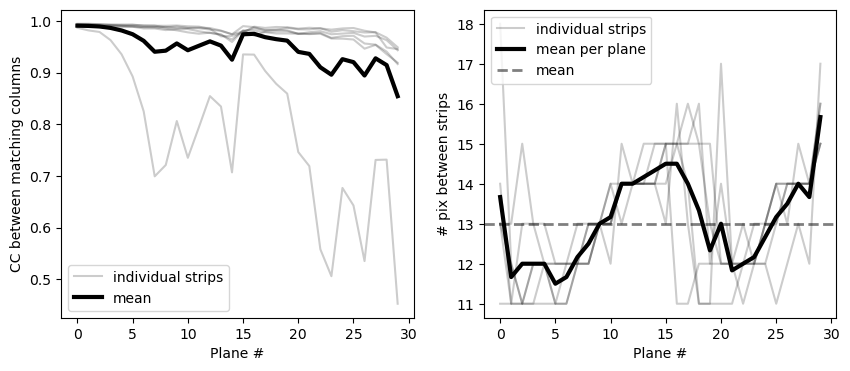

In [8]:
job.show_summary_plots()

## Registration
First, we do registration over time of the  xy-drift caused by brain movement. This is similar to Suite2P registratrion, it does rigid registration followed by non-rigid registration. This is accelerated on the GPU. Suite2P registration parameters can be changed, see `default_params.py` for a list of all parameters related to registration. After you have registered, you can load the registered fused movie into memory and take a look at the mean image. I suggest cropping the dark edges if you have any as shown in the cells below.

If you run out of gpu memory, try reducing the `gpu_reg_batchsize` parameter. I have a A4500 with 20GB memory which works well with a batchsize of 10.

In [9]:
# If you have large tiffs, split the large tiffs into files of size 100 after registration
job.params['split_tif_size'] = 100

In [10]:
%%time
job.register_gpu()

In [11]:
# if GPU fails, the following *should* work
# note that in the GPU version fusing is incorporated into registration
# job.register()
# job.params['n_skip'] = job.load_summary()['fuse_shift']
# job.fuse_registered_movie()

In [11]:
mov_full = job.get_registered_movie('registered_fused_data','f')
im_full = mov_full.mean(axis=1).compute()

In [13]:
# find crop values that minimize dark zones - check planes 0 and 15 in the following cell to 
# make sure you're not cutting out parts of the brain
crop = ((0,18), (100,1100), (100, 950))

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7eff3ff11220>)

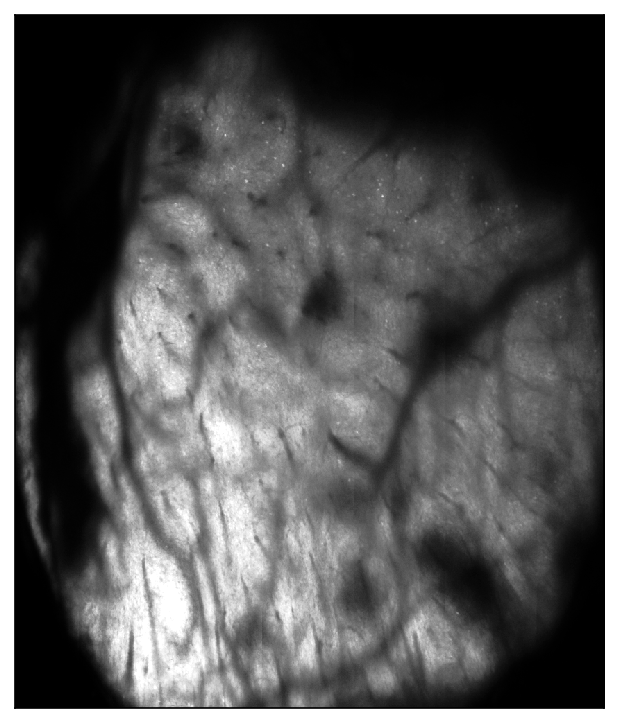

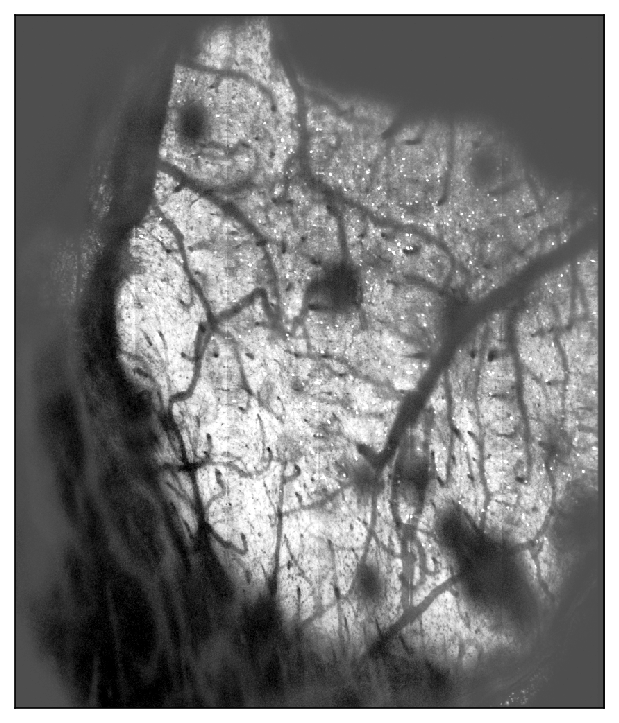

In [14]:
tfu.show_tif(im_full[0,crop[1][0]:crop[1][1], crop[2][0]:crop[2][1]])
tfu.show_tif(im_full[15,crop[1][0]:crop[1][1], crop[2][0]:crop[2][1]])

## Optional: SVD Denoising

**If you want, you can SVD-denoise before calculating the correlation map**

We compute an SVD of the volumetric movie, and keep the top N components to denoise. This is done by blocking the volume to make it computationally tractable. The blocks have overlaps, and I find that for noisy movies you will get some grid-like artifacts if your block overlaps aren't set such that each non-edge pixel is included in at least two blocks. So, I usually set the overlaps to be half of the block shape to achieve this. Feel free to try with smaller (or zero) overlaps on your data to see if it works better (overlaps increase the number of blocks that need to be SVD-d, so less overlap = less blocks = faster compute). 

The SVD decomposition is implemented with Dask, which can be blazing fast (compared to other methods) if implemented correctly, but there are a few parameters that can make it really slow if set incorrectly. If the SVD feels slow, try playing with the `svd_pix_chunk` and `svd_time_chunk` parameters. If you really care about speed, probably install the Dask profiler and see if there are any obvious bottlenecks.

Note that the Dask SVD uses an approximate algorithm and its runtime scales **sub-linearly** with movie length! So for a short movie, it might take >10x the movie duration, but for longer movies it should be much less.

In [23]:
# tag (not path) for the directory where the SVD will be saved
svd_dir_tag = 'svd_cropped'

# Number of components to compute per block 
# (you can change the actual number of components used for computation later, this is the upper limit)
job.params['n_svd_comp'] = 100
# Size of each block in pixels in z,y,x
job.params['svd_block_shape'] = (4,200,200)
# overlap in z,y,x between two neighboring blocks
job.params['svd_block_overlaps'] = (2,100,100)
# crop the movie before computing svd
job.params['svd_crop'] = crop

# Number of pixels in each Dask "chunk" when computing SVD. Unless you have ridiculously 
# large blocks, manually setting the chunksize to the total number of pixels in a block
# seems to be substantially faster than having multiple chunks per block
job.params['svd_pix_chunk'] = n.product(job.params['svd_block_shape'])
# When computing SVD, we can compute multiple blocks (4-8) at the same time, which is sometimes 
# faster since we save on some disk I/O for neighboring blocks (I  think)
# for longer recordings (1000+frames) or if you have issues with RAM, set to 1
job.params['n_svd_blocks_per_batch'] = 8

In [24]:
%%time
# create the directory where we'll save the SVD, and run the SVD decomposition
job.make_new_dir(svd_dir_tag)
svd_info = job.svd_decompose_movie(svd_dir_tag, run_svd=True)

      Found dir /mnt/md0/runs/s3d-Full-Demo/svd_cropped with tag svd_cropped
   Saved a copy of params at /mnt/md0/runs/s3d-Full-Demo/svd_cropped
   Updated main params file
   Loaded mov of size (30, 300, 1256, 974)
   Cropped to size (18, 300, 1000, 850)
   Time-cropped to size (18, 300, 1000, 850)
   Saved a copy of params at /mnt/md0/runs/s3d-Full-Demo/svd_cropped
   Updated main params file
576 blocks with overlap (125 without, 4.61x increase)
   Will compute SVD in 576 blocks in a grid shaped (8, 9, 8)
   Batching 8 blocks together, for a total of 72 batches. Pix chunksize: 160000
   Saving SVD blocks in /mnt/md0/runs/s3d-Full-Demo/svd_cropped/blocks
Starting with batch 0
      Starting batch 1 / 72, blocks 0 - 8
      Sending batch 1 to dask
      Dask completed in 10.697 sec
      Saving svd_info to /mnt/md0/runs/s3d-Full-Demo/svd_cropped/svd_info.npy
   Batch 1 completed in 10.943
   Estimated time remaining for 71 batches: 00h12m56s
      Starting batch 2 / 72, blocks 8 - 16


### If you want to calculate correlation map from SVD-denoised movie, do this

In [9]:
%%time
svd_info = n.load(os.path.join(job.dirs['svd_cropped'], 'svd_info.npy'), allow_pickle=True).item()
(vmap, mean_img, max_img), __, __ = job.calculate_corr_map(mov = svd_info)

   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo/mov_sub with tag mov_sub
   Saving mov_sub to /mnt/md0/runs/s3d-Full-Demo/mov_sub
   Using conv_filt: gaussian, 1.00, 1.00
   Using np_filt: unif, 1.50, 5.00
   Will reconstruct SVD movie on-the-fly from  with 50 components
   Created files and dirs for 1 batches
      Running batch 1 of 1
         Will process 300 frames (0-300, t_batch_size: 300)
         Reconstructing from svd (re-loading spatial components each iteration)
Sending all blocks to dask to compute
Dask reconstruction complete
         Reconstructed (300, 18, 1000, 850) mov in 204.38 seconds
      Loaded and swapped, idx 0 to 300
      Calculating corr map
         Rolling mean filter
         Stdev over time
         Sharr creation
         Sub and conv
         Vmap
   Calculated corr map in 142.72 seconds
      Saving to /mnt/md0/runs/s3d-Full-Demo/iters/batch0000
CPU times: user 5min 35s, sys: 31min 55s, total: 37min 31s
Wall time: 5min 47s


## Calculating the correlation map

The correlation map is the most important part of the cell detection process. It spatially and temporally filters the denoised movie, normalizes it, thresholds it, and accumulates it over time to create a volume where cells should be made more visible and neuropil is removed.

**You should tune some of these parameters for your data**, each described below. To enable easy tuning, there is a **parameter sweep interface** that can try many combinations for a subset of the movie quickly, and visualize the results (you will find this below). 

Correlation map improves the more frames you have!

In [7]:
# spatial filter sizes for neuropil subtraction, and cell detection
# npil_filt is a low_pass filter that attempts to remove any features larger than the filter size (neuropil!)
# conv_filt_xy is a high_pass filter that amplifies any features that are smaller than ~2x the filter size (cells!)
# these values worked well for me with ~4um xy pixel spacing and ~15 um z pixel spacing, for detecting mouse somata
# When you change resolution, or if you're trying to detect smaller things, you will need to adjust these values
# because the units here are _pixels_, not microns!
job.params['conv_filt_type'] = 'gaussian'
job.params['conv_filt_xy'] = 1.0
job.params['conv_filt_z'] = 1.0
job.params['npil_filt_type'] = 'unif'
job.params['npil_filt_xy'] = 5.0
job.params['npil_filt_z']=  1.5

# normalization exponent, should be around 1. 
# If you find blood vessels or the background being too bright in the correlation map, reduce it to ~0.7-0.8! 
job.params['sdnorm_exp']= 0.8

# threshold applied to the normalized, filtered movie before it is accumulated into the correlation map
# if you increase it, the background will become darker (which is good!), however at some point you will
# start excluding dimmer cells (which is bad!)
job.params['intensity_thresh'] : 0.2

## Compute parameters 
# number of frames to compute at one iteration 
# (any value above ~100-200 shouldn't affect results, 
# decrease if you have RAM issues or if SVD reconstruction gets stuck on "Sending all blocks to dask to compute")
job.params['t_batch_size'] = 300
# number of processors to use when calculating the correlation map
job.params['n_proc_corr'] = 70
# number of frames per smaller batch within the batch, should be ~t_batch_size / n_proc_corr, but above ~5
job.params['mproc_batchsize'] = 5


In [ ]:
%%time
mov = mov_full[crop[0][0]:crop[0][1], :,crop[1][0]:crop[1][1], 
               crop[2][0]:crop[2][1]]

(vmap, mean_img, max_img), __, __ = job.calculate_corr_map(mov = mov)

### Optional: sweep correlation map parameters

In [30]:
# load a snippet of the movie to sweep parameters over
from suite3d import svd_utils as svu
movx = svu.reconstruct_overlapping_movie(svd_info, t_indices = (0, 100),n_comps=50)

# NOTE: if you want to also sweep over the n_svd_comp param, you need to compute the correlation map from the svd
# to do that, just set mov = svd_info instead of movx
# note, this means it will reconstruct the movie from svd for each iteration of the sweep, which might be slow

Sending all blocks to dask to compute
Dask reconstruction complete


In [32]:
# Pick the parameters you want to sweep, and enter them in the tuples.
# It will do all combinations of parameters, so if you have many parameters it will be many combinations! 

params_to_sweep = {
    'intensity_thresh' : (0.2, 0.3),
    'n_svd_comp' : (50,), # if you have multiple values here, make sure you pass mov=svd_info
    'conv_filt_xy': (0.7,1.0,),
    'npil_filt_xy': (5.0,),
    'conv_filt_z' : (1.0,),
    'npil_filt_z' : (1.5,),
    'sdnorm_exp' : (0.7,0.8)
}

sweep_summary = job.sweep_params(params_to_sweep, mov = movx,testing_dir_tag='sweep-full',
                           do_vmap=True, all_combinations=True, n_test_iters = 1)
# use this to access older sweep results
# sweep_summary = n.load(os.path.join(job.dirs['sweep-full'], 'sweep_summary.npy'),allow_pickle=True).item()


      Found dir /mnt/md0/runs/s3d-Full-Demo/sweep-full with tag sweep-full
   Created dir /mnt/md0/runs/s3d-Full-Demo/sweep-full/sweep-full-comb_00000 with tag sweep-full-comb_00000
   Created dir /mnt/md0/runs/s3d-Full-Demo/sweep-full/sweep-full-comb_00001 with tag sweep-full-comb_00001
   Created dir /mnt/md0/runs/s3d-Full-Demo/sweep-full/sweep-full-comb_00002 with tag sweep-full-comb_00002
   Created dir /mnt/md0/runs/s3d-Full-Demo/sweep-full/sweep-full-comb_00003 with tag sweep-full-comb_00003
   Saving summary for 4 combinations to /mnt/md0/runs/s3d-Full-Demo/sweep-full/sweep_summary.npy
Running combination 01/04Total Used: 149.260 GB, Virtual Available: 369.613 GB, Virtual Used: 133.583 GB, Swap Used: 015.677 GB
   Summary dict size: 00 GB
      Combination params: comb00000-params-intensity_thresh_0.200-n_svd_comp_50.000-conv_filt_xy_1.000-npil_filt_xy_5.000-conv_filt_z_1.000-npil_filt_z_1.500-sdnorm_exp_0.700
      Saving to tag sweep-full-comb_00000 at /mnt/md0/runs/s3d-Full-D

In [34]:
v = job.vis_vmap_sweep(sweep_summary)

[2, 1, 1, 1, 1, 1, 2]
(2, 1, 1, 1, 1, 1, 2, 18, 1000, 850)


In [40]:
# reminder: you should set all parameters that you swept back to the values you want explicitly before re-computing the correlation map
# because the global values of the parameters are updated during the sweep!

In [10]:
# the lower contrast limit should be used as "peak_thresh"
v = napari.view_image(vmap)

## Detection
Now that we have a correlation map, we can segment the cells. The algorithm is similar to suite2p, it does the following:
1. Choose the peak value on the correlation map, and set this pixel as your _seed cell_
2. Identify the _active frames_ of the candidate cell by taking all frames where the activity of the cell is greater than a threshold (`activity_thresh`) or have activity above a certain percentile (`percentile`) 
3. Look at the activity of all neighboring pixels of the _seed cell_ during the _active frames_ of the seed cell. If a candidate pixel's activity is similar to the activity of the _seed cell_ (similarity above `extend_thresh`), include the pixel in the _seed cell_.
4. Repeat steps 2-3 until you've grown the cell as much as you can
5. Remove the cell from the correlation map
6. Find the next largest peak of the correlation map, take this as your seed cell and repeat steps 2-6
7. Stop when the peak value of the remaining correlation map is below a user-specified threhsold (`peak_thresh`)
Two main improvements over Suite2p: first, this is done in 3D. Second, it is parallelized to be much faster, as it works on patches of the movie separately!

**The most important variable that you *must* set is `peak_thresh`**. To do this, use the cell below to visualize the correlation map (`vmap` for short) using napari. Use the contrast sliders to find a minimum value where all spots above this value look like they might be cells. I find it useful to set the range to be very small, all pixels above the minimum are basically white. You should try to get rid of most of the obvious noise (e.g. artifacts at edges or around blood vessels, specks of single-pixel white spots, stuff outside the brain). It is not critical to exclude everything, you can be generous here and remove ROIs based on other criteria later. However, if you are too generous, you'll end up with too many pixels above the threhsold and your detection will take forever, with a lot of extra junk cells. I recommend starting a little conservative, and then push the limits. 

**Other useful variables**: When you have long enough recordings, 0.2 for `extend_thresh` is OK. However, if you have only a very short recording, or you find many cells that are much larger than they should be (with large, sprinkly footprints that extend way beyond the cell), or you have large cloudy blobs of noise being picked up as cells, increase `extend_thresh`. `activity_thresh` and `percentile` work together, usually it's good enough to just pick one and change it. If you have few frames, or you feel like you have low signal, it's better to set these to be lower, so you include more frames when evaluating a cell. However, if you can afford to, it's good to keep them high (`activity_thresh` around 10, `percentile` around 99.0), because then sparsely-firing cells will be picked up easier. Play around and see!

**To make it faster to try parameters, you can run the detection only on a subset of the patches**. By default the movie is split into ~100 patches (I think), but if you pass `job.patch_and_detect(do_patch_idxs=(10,20,50,80))` then the detection will only run on the specified patches.

**Detection always works better with more frames!** 300 frames is a very small number, so don't expect it to work perfectly on this demo.

In [ ]:
# visualize the correlation map
# here you can identify the best "peak_thresh"
# play with the contrast limits of vmap until only cells are visible
# the lower contrast limit should be used as "peak_thresh"
v = napari.view_image(vmap)
v.add_image(mean_img)

Invalid MIT-MAGIC-COOKIE-1 key


In [54]:
%%time
job.params['detection_timebin'] = 1 
job.params['detection_time_crop'] = (None,None)
job.params['max_pix'] = 250
job.params['peak_thresh'] = 3.5

job.params['activity_thresh'] = 1.0
job.params['extend_thresh'] = 0.3
job.params['max_iter'] = 10000 # maximum number of ROIs detected in given patch
combined_dir = job.patch_and_detect(combined_name='combined-full') #, do_patch_idxs=(20,30,50,60,80,90))

   Loading from /mnt/md0/runs/s3d-Full-Demo/iters/batch0000
99 blocks with overlap (72 without, 1.38x increase)
99 blocks with overlap (72 without, 1.38x increase)
   Detecting from patch: 0/99
   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection with tag detection
      Found dir /mnt/md0/runs/s3d-Full-Demo/detection/patch-0000 with tag patch-0000
   Running cell detection on patch 0000 at /mnt/md0/runs/s3d-Full-Demo/detection/patch-0000, max 10000 iters
   Patch bounds are [ 0 18], [  0 120], [  0 120]
   Cell center bounds are [ 0 18], [  0 104], [  0 105]
   Time bounds are (None, None)
mov_sub
   Loading 0.29 GB movie to memory
   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo/iters/batch0000
      Movie shape: (300, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo/detection/patch-0000
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 4.100 and Th2: 1.000
      Iter 0000: peak is too small  -

      Added cell 89 at 03, 148, 244, peak: 2.888, thresh: 1.000, 88 frames, 8 pixels
      Added cell 90 at 08, 122, 247, peak: 2.888, thresh: 1.000, 67 frames, 7 pixels
      Added cell 91 at 11, 113, 242, peak: 2.884, thresh: 1.000, 84 frames, 13 pixels
      Added cell 92 at 17, 172, 262, peak: 2.884, thresh: 1.000, 65 frames, 6 pixels
      Added cell 93 at 00, 166, 214, peak: 2.880, thresh: 1.000, 66 frames, 5 pixels
      Added cell 94 at 07, 156, 256, peak: 2.879, thresh: 1.000, 77 frames, 28 pixels
      Added cell 95 at 17, 186, 265, peak: 2.877, thresh: 1.000, 81 frames, 16 pixels
      Added cell 96 at 07, 182, 286, peak: 2.876, thresh: 1.000, 81 frames, 15 pixels
   Iter 0012: running 08 ROIs in parallel
      Added cell 97 at 12, 110, 245, peak: 2.876, thresh: 1.000, 76 frames, 12 pixels
      Added cell 98 at 09, 107, 229, peak: 2.876, thresh: 1.000, 61 frames, 7 pixels
      Added cell 99 at 06, 191, 209, peak: 2.875, thresh: 1.000, 73 frames, 19 pixels
      Added cell 

   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo-GPU/iters/batch0000
      Movie shape: (400, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0012
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 2.750 and Th2: 1.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 03, 135, 312, peak: 7.925, thresh: 1.000, 129 frames, 30 pixels
      Added cell 2 at 01, 173, 298, peak: 7.143, thresh: 1.000, 152 frames, 30 pixels
      Added cell 3 at 07, 148, 303, peak: 6.768, thresh: 1.000, 148 frames, 39 pixels
      Added cell 4 at 06, 163, 312, peak: 6.352, thresh: 1.000, 138 frames, 35 pixels
      Added cell 5 at 06, 148, 339, peak: 5.689, thresh: 1.000, 126 frames, 16 pixels
      Added cell 6 at 06, 162, 335, peak: 5.342, thresh: 1.000, 131 frames, 44 pixels
      Added cell 7 at 01, 163, 377, peak: 5.248, thresh: 1.000, 135 frames, 27 pixels
      Added cell 8 at 01, 183, 360, peak: 5.200, thresh

      Added cell 89 at 04, 152, 354, peak: 2.919, thresh: 1.000, 65 frames, 6 pixels
      Added cell 90 at 00, 112, 334, peak: 2.919, thresh: 1.000, 92 frames, 8 pixels
      Added cell 91 at 03, 135, 353, peak: 2.909, thresh: 1.000, 93 frames, 10 pixels
      Added cell 92 at 00, 149, 336, peak: 2.908, thresh: 1.000, 70 frames, 6 pixels
      Added cell 93 at 05, 173, 311, peak: 2.905, thresh: 1.000, 80 frames, 7 pixels
      Added cell 94 at 00, 109, 291, peak: 2.903, thresh: 1.000, 80 frames, 7 pixels
      Added cell 95 at 08, 166, 293, peak: 2.902, thresh: 1.000, 74 frames, 4 pixels
      Added cell 96 at 10, 165, 359, peak: 2.901, thresh: 1.000, 73 frames, 11 pixels
   Iter 0012: running 08 ROIs in parallel
      Added cell 97 at 09, 166, 303, peak: 2.900, thresh: 1.000, 72 frames, 7 pixels
      Added cell 98 at 05, 132, 372, peak: 2.897, thresh: 1.000, 76 frames, 9 pixels
      Added cell 99 at 08, 190, 365, peak: 2.892, thresh: 1.000, 70 frames, 11 pixels
      Added cell 100

   Found 193 cells in 25 iterations
   Saving cells to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0012/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0012/iscell.npy
   Detecting from patch: 13/99
   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection with tag detection
   Created dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0013 with tag patch-0013
   Running cell detection on patch 0013 at /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0013, max 10000 iters
   Patch bounds are [ 0 18], [ 88 208], [365 485]
   Cell center bounds are [ 0 18], [104 192], [379 470]
   Time bounds are (None, None)
mov_sub
   Loading 0.39 GB movie to memory
   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo-GPU/iters/batch0000
      Movie shape: (400, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0013
   Loading movie patch to shared memory
   Starting extraction with peak_thre

   Found 82 cells in 11 iterations
   Saving cells to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0013/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0013/iscell.npy
   Detecting from patch: 14/99
   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection with tag detection
   Created dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0014 with tag patch-0014
   Running cell detection on patch 0014 at /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0014, max 10000 iters
   Patch bounds are [ 0 18], [ 88 208], [456 576]
   Cell center bounds are [ 0 18], [104 192], [470 561]
   Time bounds are (None, None)
mov_sub
   Loading 0.39 GB movie to memory
   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo-GPU/iters/batch0000
      Movie shape: (400, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0014
   Loading movie patch to shared memory
   Starting extraction with peak_thres

   Iter 0000: running 05 ROIs in parallel
      Added cell 1 at 16, 170, 666, peak: 2.883, thresh: 1.000, 76 frames, 17 pixels
      Added cell 2 at 12, 179, 667, peak: 2.776, thresh: 1.000, 51 frames, 18 pixels
      Added cell 3 at 12, 166, 679, peak: 2.770, thresh: 1.000, 43 frames, 13 pixels
      Added cell 4 at 00, 179, 669, peak: 2.768, thresh: 1.000, 58 frames, 6 pixels
      Added cell 5 at 04, 142, 656, peak: 2.756, thresh: 1.000, 52 frames, 12 pixels
      Iter 0001: peak is too small  - ending extraction
   Found 5 cells in 1 iterations
   Saving cells to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0016/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0016/iscell.npy
   Detecting from patch: 17/99
   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection with tag detection
   Created dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0017 with tag patch-0017
   Running cell detection on patch 0017 at /mnt/md0

   Found 56 cells in 7 iterations
   Saving cells to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0019/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0019/iscell.npy
   Detecting from patch: 20/99
   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection with tag detection
      Found dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0020 with tag patch-0020
   Running cell detection on patch 0020 at /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0020, max 10000 iters
   Patch bounds are [ 0 18], [176 296], [182 302]
   Cell center bounds are [ 0 18], [192 280], [196 287]
   Time bounds are (None, None)
mov_sub
   Loading 0.39 GB movie to memory
   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo-GPU/iters/batch0000
      Movie shape: (400, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0020
   Loading movie patch to shared memory
   Starting extraction with peak_thres

      Added cell 81 at 07, 204, 224, peak: 3.001, thresh: 1.000, 81 frames, 7 pixels
      Added cell 82 at 09, 201, 246, peak: 2.990, thresh: 1.000, 67 frames, 9 pixels
      Added cell 83 at 06, 241, 221, peak: 2.987, thresh: 1.000, 70 frames, 7 pixels
      Added cell 84 at 07, 252, 208, peak: 2.987, thresh: 1.000, 70 frames, 5 pixels
      Added cell 85 at 13, 192, 235, peak: 2.975, thresh: 1.000, 117 frames, 20 pixels
      Added cell 86 at 09, 211, 236, peak: 2.972, thresh: 1.000, 78 frames, 7 pixels
      Added cell 87 at 01, 239, 276, peak: 2.971, thresh: 1.000, 90 frames, 28 pixels
      Added cell 88 at 08, 274, 286, peak: 2.967, thresh: 1.000, 55 frames, 5 pixels
   Iter 0011: running 08 ROIs in parallel
      Added cell 89 at 03, 270, 286, peak: 2.967, thresh: 1.000, 88 frames, 6 pixels
      Added cell 90 at 06, 254, 222, peak: 2.966, thresh: 1.000, 95 frames, 11 pixels
      Added cell 91 at 17, 227, 264, peak: 2.960, thresh: 1.000, 56 frames, 17 pixels
      Added cell 9

      Added cell 193 at 09, 262, 256, peak: 2.802, thresh: 1.000, 69 frames, 8 pixels
      Added cell 194 at 12, 252, 273, peak: 2.801, thresh: 1.000, 82 frames, 8 pixels
      Added cell 195 at 04, 277, 280, peak: 2.797, thresh: 1.000, 96 frames, 12 pixels
      Added cell 196 at 08, 251, 216, peak: 2.797, thresh: 1.000, 69 frames, 14 pixels
      Added cell 197 at 08, 252, 250, peak: 2.796, thresh: 1.000, 68 frames, 24 pixels
      Added cell 198 at 10, 219, 241, peak: 2.793, thresh: 1.000, 65 frames, 10 pixels
      Added cell 199 at 14, 194, 220, peak: 2.790, thresh: 1.000, 56 frames, 7 pixels
      Added cell 200 at 07, 231, 262, peak: 2.790, thresh: 1.000, 64 frames, 7 pixels
   Iter 0025: running 08 ROIs in parallel
      Added cell 201 at 12, 259, 285, peak: 2.789, thresh: 1.000, 82 frames, 12 pixels
      Added cell 202 at 10, 230, 266, peak: 2.789, thresh: 1.000, 76 frames, 8 pixels
      Added cell 203 at 15, 250, 261, peak: 2.788, thresh: 1.000, 70 frames, 8 pixels
      A

      Added cell 49 at 02, 246, 343, peak: 3.634, thresh: 1.000, 100 frames, 20 pixels
      Added cell 50 at 12, 227, 355, peak: 3.619, thresh: 1.000, 109 frames, 7 pixels
      Added cell 51 at 12, 208, 358, peak: 3.591, thresh: 1.000, 111 frames, 22 pixels
      Added cell 52 at 08, 270, 346, peak: 3.585, thresh: 1.000, 59 frames, 24 pixels
      Added cell 53 at 07, 239, 360, peak: 3.569, thresh: 1.000, 116 frames, 23 pixels
      Added cell 54 at 06, 256, 368, peak: 3.567, thresh: 1.000, 82 frames, 22 pixels
      Added cell 55 at 05, 256, 290, peak: 3.554, thresh: 1.000, 72 frames, 11 pixels
      Added cell 56 at 12, 215, 367, peak: 3.524, thresh: 1.000, 111 frames, 16 pixels
   Iter 0007: running 08 ROIs in parallel
      Added cell 57 at 04, 245, 291, peak: 3.523, thresh: 1.000, 76 frames, 12 pixels
      Added cell 58 at 03, 250, 323, peak: 3.503, thresh: 1.000, 108 frames, 26 pixels
      Added cell 59 at 05, 261, 347, peak: 3.491, thresh: 1.000, 67 frames, 7 pixels
      Ad

      Added cell 169 at 08, 212, 366, peak: 2.879, thresh: 1.000, 66 frames, 17 pixels
      Added cell 170 at 04, 236, 307, peak: 2.873, thresh: 1.000, 88 frames, 22 pixels
      Added cell 171 at 11, 193, 312, peak: 2.872, thresh: 1.000, 63 frames, 9 pixels
      Added cell 172 at 07, 203, 356, peak: 2.870, thresh: 1.000, 75 frames, 14 pixels
      Added cell 173 at 10, 274, 350, peak: 2.868, thresh: 1.000, 68 frames, 12 pixels
      Added cell 174 at 10, 229, 294, peak: 2.867, thresh: 1.000, 73 frames, 15 pixels
      Added cell 175 at 00, 249, 292, peak: 2.861, thresh: 1.000, 74 frames, 9 pixels
      Added cell 176 at 01, 255, 346, peak: 2.859, thresh: 1.000, 84 frames, 9 pixels
   Iter 0022: running 08 ROIs in parallel
      Added cell 177 at 04, 278, 292, peak: 2.850, thresh: 1.000, 87 frames, 24 pixels
      Added cell 178 at 10, 223, 369, peak: 2.850, thresh: 1.000, 62 frames, 10 pixels
      Added cell 179 at 13, 272, 339, peak: 2.848, thresh: 1.000, 67 frames, 16 pixels
    

   Found 265 cells in 34 iterations
   Saving cells to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0021/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0021/iscell.npy
   Detecting from patch: 22/99
   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection with tag detection
   Created dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0022 with tag patch-0022
   Running cell detection on patch 0022 at /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0022, max 10000 iters
   Patch bounds are [ 0 18], [176 296], [365 485]
   Cell center bounds are [ 0 18], [192 280], [379 470]
   Time bounds are (None, None)
mov_sub
   Loading 0.39 GB movie to memory
   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo-GPU/iters/batch0000
      Movie shape: (400, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0022
   Loading movie patch to shared memory
   Starting extraction with peak_thre

      Added cell 81 at 08, 261, 438, peak: 2.887, thresh: 1.000, 66 frames, 15 pixels
      Added cell 82 at 10, 232, 469, peak: 2.886, thresh: 1.000, 79 frames, 7 pixels
      Added cell 83 at 15, 207, 458, peak: 2.883, thresh: 1.000, 73 frames, 34 pixels
      Added cell 84 at 06, 219, 434, peak: 2.880, thresh: 1.000, 67 frames, 12 pixels
      Added cell 85 at 14, 219, 403, peak: 2.879, thresh: 1.000, 58 frames, 7 pixels
      Added cell 86 at 10, 234, 457, peak: 2.877, thresh: 1.000, 75 frames, 12 pixels
      Added cell 87 at 07, 252, 445, peak: 2.876, thresh: 1.000, 66 frames, 7 pixels
      Added cell 88 at 11, 193, 422, peak: 2.871, thresh: 1.000, 69 frames, 11 pixels
   Iter 0011: running 08 ROIs in parallel
      Added cell 89 at 08, 212, 380, peak: 2.869, thresh: 1.000, 94 frames, 12 pixels
      Added cell 90 at 02, 265, 429, peak: 2.862, thresh: 1.000, 80 frames, 11 pixels
      Added cell 91 at 10, 208, 384, peak: 2.862, thresh: 1.000, 79 frames, 15 pixels
      Added cel

   Starting extraction with peak_thresh: 2.750 and Th2: 1.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 03, 273, 494, peak: 6.781, thresh: 1.000, 146 frames, 42 pixels
      Added cell 2 at 00, 244, 521, peak: 6.245, thresh: 1.000, 117 frames, 12 pixels
      Added cell 3 at 02, 219, 548, peak: 5.825, thresh: 1.000, 124 frames, 28 pixels
      Added cell 4 at 01, 237, 525, peak: 5.792, thresh: 1.000, 122 frames, 28 pixels
      Added cell 5 at 01, 238, 519, peak: 5.163, thresh: 1.000, 113 frames, 21 pixels
      Added cell 6 at 07, 271, 523, peak: 5.018, thresh: 1.000, 103 frames, 24 pixels
      Added cell 7 at 02, 245, 513, peak: 4.983, thresh: 1.000, 114 frames, 23 pixels
      Added cell 8 at 08, 216, 485, peak: 4.848, thresh: 1.000, 94 frames, 40 pixels
   Iter 0001: running 08 ROIs in parallel
      Added cell 9 at 06, 252, 523, peak: 4.570, thresh: 1.000, 68 frames, 9 pixels
      Added cell 10 at 01, 251, 519, peak: 4.569, thresh: 1.000, 104 frames, 11 pix

      Added cell 97 at 10, 259, 510, peak: 2.934, thresh: 1.000, 53 frames, 10 pixels
      Added cell 98 at 11, 261, 558, peak: 2.930, thresh: 1.000, 57 frames, 11 pixels
      Added cell 99 at 03, 276, 496, peak: 2.928, thresh: 1.000, 94 frames, 10 pixels
      Added cell 100 at 06, 266, 556, peak: 2.927, thresh: 1.000, 73 frames, 14 pixels
      Added cell 101 at 10, 213, 521, peak: 2.926, thresh: 1.000, 59 frames, 7 pixels
      Added cell 102 at 13, 269, 487, peak: 2.920, thresh: 1.000, 67 frames, 11 pixels
      Added cell 103 at 02, 200, 543, peak: 2.910, thresh: 1.000, 78 frames, 5 pixels
      Added cell 104 at 13, 250, 474, peak: 2.906, thresh: 1.000, 50 frames, 6 pixels
   Iter 0013: running 08 ROIs in parallel
      Added cell 105 at 05, 272, 541, peak: 2.902, thresh: 1.000, 80 frames, 13 pixels
      Added cell 106 at 17, 267, 542, peak: 2.901, thresh: 1.000, 83 frames, 10 pixels
      Added cell 107 at 15, 230, 511, peak: 2.901, thresh: 1.000, 62 frames, 15 pixels
      A

   Created dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0024 with tag patch-0024
   Running cell detection on patch 0024 at /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0024, max 10000 iters
   Patch bounds are [ 0 18], [176 296], [547 667]
   Cell center bounds are [ 0 18], [192 280], [561 652]
   Time bounds are (None, None)
mov_sub
   Loading 0.39 GB movie to memory
   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo-GPU/iters/batch0000
      Movie shape: (400, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0024
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 2.750 and Th2: 1.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 08, 221, 575, peak: 5.964, thresh: 1.000, 90 frames, 34 pixels
      Added cell 2 at 06, 261, 639, peak: 5.662, thresh: 1.000, 130 frames, 42 pixels
      Added cell 3 at 01, 267, 632, peak: 5.082, thresh: 1.000, 130 frames, 26 pixels
      Added cell 4

      Added cell 105 at 15, 267, 637, peak: 2.849, thresh: 1.000, 56 frames, 13 pixels
      Added cell 106 at 04, 251, 645, peak: 2.841, thresh: 1.000, 73 frames, 22 pixels
      Added cell 107 at 02, 245, 638, peak: 2.839, thresh: 1.000, 71 frames, 10 pixels
      Added cell 108 at 08, 259, 563, peak: 2.838, thresh: 1.000, 59 frames, 23 pixels
      Added cell 109 at 08, 209, 628, peak: 2.836, thresh: 1.000, 63 frames, 13 pixels
      Added cell 110 at 06, 257, 606, peak: 2.830, thresh: 1.000, 70 frames, 11 pixels
      Added cell 111 at 14, 195, 620, peak: 2.827, thresh: 1.000, 60 frames, 9 pixels
      Added cell 112 at 12, 274, 565, peak: 2.822, thresh: 1.000, 58 frames, 7 pixels
   Iter 0014: running 08 ROIs in parallel
      Added cell 113 at 05, 198, 647, peak: 2.820, thresh: 1.000, 76 frames, 8 pixels
      Added cell 114 at 09, 223, 637, peak: 2.819, thresh: 1.000, 73 frames, 12 pixels
      Added cell 115 at 09, 270, 631, peak: 2.818, thresh: 1.000, 58 frames, 9 pixels
     

      Added cell 25 at 12, 267, 681, peak: 2.905, thresh: 1.000, 71 frames, 13 pixels
      Added cell 26 at 01, 216, 667, peak: 2.904, thresh: 1.000, 77 frames, 17 pixels
      Added cell 27 at 00, 268, 656, peak: 2.902, thresh: 1.000, 58 frames, 11 pixels
      Added cell 28 at 09, 227, 689, peak: 2.898, thresh: 1.000, 65 frames, 10 pixels
      Added cell 29 at 00, 234, 655, peak: 2.896, thresh: 1.000, 74 frames, 7 pixels
      Added cell 30 at 02, 209, 681, peak: 2.886, thresh: 1.000, 76 frames, 14 pixels
      Added cell 31 at 14, 261, 677, peak: 2.886, thresh: 1.000, 57 frames, 21 pixels
      Added cell 32 at 13, 202, 653, peak: 2.882, thresh: 1.000, 56 frames, 9 pixels
   Iter 0004: running 08 ROIs in parallel
      Added cell 33 at 10, 261, 714, peak: 2.875, thresh: 1.000, 48 frames, 8 pixels
      Added cell 34 at 00, 269, 665, peak: 2.869, thresh: 1.000, 75 frames, 10 pixels
      Added cell 35 at 00, 238, 688, peak: 2.866, thresh: 1.000, 62 frames, 8 pixels
      Added cell

   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo-GPU/iters/batch0000
      Movie shape: (400, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0028
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 2.750 and Th2: 1.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 04, 349, 169, peak: 7.282, thresh: 1.000, 138 frames, 32 pixels
      Added cell 2 at 00, 354, 177, peak: 5.521, thresh: 1.000, 117 frames, 19 pixels
      Added cell 3 at 06, 349, 169, peak: 5.237, thresh: 1.000, 137 frames, 31 pixels
      Added cell 4 at 06, 321, 188, peak: 5.181, thresh: 1.000, 115 frames, 41 pixels
      Added cell 5 at 10, 319, 153, peak: 5.051, thresh: 1.000, 95 frames, 10 pixels
      Added cell 6 at 02, 366, 185, peak: 4.961, thresh: 1.000, 137 frames, 44 pixels
      Added cell 7 at 02, 355, 177, peak: 4.703, thresh: 1.000, 117 frames, 23 pixels
      Added cell 8 at 08, 338, 168, peak: 4.678, thresh:

      Added cell 105 at 03, 345, 184, peak: 2.752, thresh: 1.000, 110 frames, 25 pixels
      Iter 0014: peak is too small  - ending extraction
   Found 105 cells in 14 iterations
   Saving cells to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0028/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0028/iscell.npy
   Detecting from patch: 29/99
   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection with tag detection
   Created dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0029 with tag patch-0029
   Running cell detection on patch 0029 at /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0029, max 10000 iters
   Patch bounds are [ 0 18], [264 384], [182 302]
   Cell center bounds are [ 0 18], [280 368], [196 287]
   Time bounds are (None, None)
mov_sub
   Loading 0.39 GB movie to memory
   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo-GPU/iters/batch0000
      Movie shape: (400, 18, 120, 120)
   Saving cell stat

      Added cell 81 at 12, 329, 218, peak: 3.435, thresh: 1.000, 86 frames, 13 pixels
      Added cell 82 at 07, 324, 221, peak: 3.427, thresh: 1.000, 112 frames, 11 pixels
      Added cell 83 at 03, 342, 279, peak: 3.423, thresh: 1.000, 76 frames, 10 pixels
      Added cell 84 at 13, 363, 252, peak: 3.416, thresh: 1.000, 132 frames, 17 pixels
      Added cell 85 at 04, 325, 268, peak: 3.415, thresh: 1.000, 101 frames, 23 pixels
      Added cell 86 at 06, 309, 210, peak: 3.405, thresh: 1.000, 83 frames, 5 pixels
      Added cell 87 at 09, 356, 217, peak: 3.399, thresh: 1.000, 74 frames, 14 pixels
      Added cell 88 at 07, 293, 261, peak: 3.397, thresh: 1.000, 86 frames, 17 pixels
   Iter 0011: running 08 ROIs in parallel
      Added cell 89 at 04, 334, 257, peak: 3.396, thresh: 1.000, 91 frames, 15 pixels
      Added cell 90 at 07, 330, 236, peak: 3.363, thresh: 1.000, 79 frames, 19 pixels
      Added cell 91 at 03, 296, 261, peak: 3.357, thresh: 1.000, 101 frames, 17 pixels
      Add

      Added cell 177 at 13, 329, 208, peak: 2.972, thresh: 1.000, 108 frames, 20 pixels
      Added cell 178 at 03, 356, 210, peak: 2.971, thresh: 1.000, 103 frames, 9 pixels
      Added cell 179 at 00, 333, 273, peak: 2.966, thresh: 1.000, 86 frames, 12 pixels
      Added cell 180 at 03, 353, 250, peak: 2.965, thresh: 1.000, 98 frames, 13 pixels
      Added cell 181 at 07, 344, 251, peak: 2.961, thresh: 1.000, 94 frames, 9 pixels
      Added cell 182 at 16, 323, 205, peak: 2.955, thresh: 1.000, 81 frames, 13 pixels
      Added cell 183 at 17, 361, 230, peak: 2.955, thresh: 1.000, 83 frames, 15 pixels
      Added cell 184 at 08, 356, 206, peak: 2.950, thresh: 1.000, 103 frames, 13 pixels
   Iter 0023: running 08 ROIs in parallel
      Added cell 185 at 17, 297, 263, peak: 2.950, thresh: 1.000, 70 frames, 14 pixels
      Added cell 186 at 09, 354, 231, peak: 2.943, thresh: 1.000, 102 frames, 16 pixels
      Added cell 187 at 07, 308, 255, peak: 2.941, thresh: 1.000, 84 frames, 8 pixels


      Added cell 281 at 11, 291, 270, peak: 2.780, thresh: 1.000, 79 frames, 17 pixels
      Added cell 282 at 10, 282, 245, peak: 2.780, thresh: 1.000, 74 frames, 12 pixels
      Added cell 283 at 05, 363, 261, peak: 2.780, thresh: 1.000, 100 frames, 19 pixels
      Added cell 284 at 08, 364, 261, peak: 2.778, thresh: 1.000, 78 frames, 7 pixels
      Added cell 285 at 10, 338, 284, peak: 2.778, thresh: 1.000, 70 frames, 16 pixels
      Added cell 286 at 02, 316, 255, peak: 2.776, thresh: 1.000, 91 frames, 11 pixels
      Added cell 287 at 12, 294, 221, peak: 2.776, thresh: 1.000, 84 frames, 8 pixels
      Added cell 288 at 15, 351, 217, peak: 2.774, thresh: 1.000, 81 frames, 7 pixels
   Iter 0036: running 08 ROIs in parallel
      Added cell 289 at 07, 290, 257, peak: 2.773, thresh: 1.000, 87 frames, 7 pixels
      Added cell 290 at 17, 346, 283, peak: 2.771, thresh: 1.000, 78 frames, 8 pixels
      Added cell 291 at 13, 313, 261, peak: 2.771, thresh: 1.000, 74 frames, 17 pixels
     

      Added cell 57 at 06, 363, 289, peak: 3.976, thresh: 1.000, 107 frames, 10 pixels
      Added cell 58 at 03, 308, 364, peak: 3.942, thresh: 1.000, 116 frames, 15 pixels
      Added cell 59 at 06, 335, 355, peak: 3.939, thresh: 1.000, 79 frames, 13 pixels
      Added cell 60 at 08, 340, 300, peak: 3.912, thresh: 1.000, 67 frames, 11 pixels
      Added cell 61 at 04, 341, 296, peak: 3.893, thresh: 1.000, 101 frames, 35 pixels
      Added cell 62 at 00, 367, 346, peak: 3.825, thresh: 1.000, 106 frames, 14 pixels
      Added cell 63 at 10, 360, 332, peak: 3.821, thresh: 1.000, 81 frames, 22 pixels
      Added cell 64 at 10, 308, 353, peak: 3.779, thresh: 1.000, 66 frames, 11 pixels
   Iter 0008: running 08 ROIs in parallel
      Added cell 65 at 08, 307, 348, peak: 3.768, thresh: 1.000, 99 frames, 11 pixels
      Added cell 66 at 08, 347, 338, peak: 3.757, thresh: 1.000, 64 frames, 15 pixels
      Added cell 67 at 15, 291, 334, peak: 3.756, thresh: 1.000, 116 frames, 7 pixels
      Ad

      Added cell 161 at 08, 293, 323, peak: 2.972, thresh: 1.000, 91 frames, 15 pixels
      Added cell 162 at 08, 289, 340, peak: 2.970, thresh: 1.000, 80 frames, 14 pixels
      Added cell 163 at 09, 338, 306, peak: 2.968, thresh: 1.000, 73 frames, 8 pixels
      Added cell 164 at 09, 341, 340, peak: 2.961, thresh: 1.000, 90 frames, 12 pixels
      Added cell 165 at 01, 367, 319, peak: 2.958, thresh: 1.000, 95 frames, 11 pixels
      Added cell 166 at 05, 292, 318, peak: 2.954, thresh: 1.000, 85 frames, 36 pixels
      Added cell 167 at 08, 284, 322, peak: 2.953, thresh: 1.000, 78 frames, 8 pixels
      Added cell 168 at 10, 356, 372, peak: 2.953, thresh: 1.000, 75 frames, 4 pixels
   Iter 0021: running 08 ROIs in parallel
      Added cell 169 at 08, 296, 322, peak: 2.952, thresh: 1.000, 76 frames, 22 pixels
      Added cell 170 at 04, 345, 315, peak: 2.950, thresh: 1.000, 98 frames, 8 pixels
      Added cell 171 at 13, 361, 287, peak: 2.946, thresh: 1.000, 130 frames, 13 pixels
    

      Added cell 257 at 11, 321, 369, peak: 2.791, thresh: 1.000, 71 frames, 5 pixels
      Added cell 258 at 00, 337, 354, peak: 2.791, thresh: 1.000, 76 frames, 6 pixels
      Added cell 259 at 09, 339, 329, peak: 2.790, thresh: 1.000, 63 frames, 6 pixels
      Added cell 260 at 00, 308, 293, peak: 2.788, thresh: 1.000, 77 frames, 12 pixels
      Added cell 261 at 10, 347, 321, peak: 2.788, thresh: 1.000, 108 frames, 21 pixels
      Added cell 262 at 06, 327, 364, peak: 2.788, thresh: 1.000, 81 frames, 7 pixels
      Added cell 263 at 00, 351, 353, peak: 2.786, thresh: 1.000, 95 frames, 9 pixels
      Added cell 264 at 09, 364, 308, peak: 2.786, thresh: 1.000, 82 frames, 9 pixels
   Iter 0033: running 08 ROIs in parallel
      Added cell 265 at 12, 362, 348, peak: 2.786, thresh: 1.000, 70 frames, 7 pixels
      Added cell 266 at 04, 333, 287, peak: 2.785, thresh: 1.000, 77 frames, 15 pixels
      Added cell 267 at 00, 351, 302, peak: 2.785, thresh: 1.000, 87 frames, 13 pixels
      A

      Added cell 41 at 06, 312, 417, peak: 3.736, thresh: 1.000, 66 frames, 10 pixels
      Added cell 42 at 09, 336, 386, peak: 3.731, thresh: 1.000, 96 frames, 9 pixels
      Added cell 43 at 07, 339, 414, peak: 3.726, thresh: 1.000, 71 frames, 16 pixels
      Added cell 44 at 08, 357, 396, peak: 3.721, thresh: 1.000, 94 frames, 18 pixels
      Added cell 45 at 10, 359, 426, peak: 3.615, thresh: 1.000, 87 frames, 15 pixels
      Added cell 46 at 15, 339, 402, peak: 3.601, thresh: 1.000, 85 frames, 10 pixels
      Added cell 47 at 06, 315, 402, peak: 3.574, thresh: 1.000, 60 frames, 6 pixels
      Added cell 48 at 15, 320, 420, peak: 3.556, thresh: 1.000, 65 frames, 11 pixels
   Iter 0006: running 08 ROIs in parallel
      Added cell 49 at 07, 337, 417, peak: 3.591, thresh: 1.000, 62 frames, 16 pixels
      Added cell 50 at 09, 294, 388, peak: 3.515, thresh: 1.000, 112 frames, 17 pixels
      Added cell 51 at 02, 333, 412, peak: 3.424, thresh: 1.000, 90 frames, 16 pixels
      Added c

      Added cell 137 at 09, 319, 410, peak: 2.893, thresh: 1.000, 67 frames, 3 pixels
      Added cell 138 at 08, 312, 416, peak: 2.888, thresh: 1.000, 59 frames, 7 pixels
      Added cell 139 at 00, 362, 420, peak: 2.882, thresh: 1.000, 63 frames, 7 pixels
      Added cell 140 at 11, 330, 398, peak: 2.881, thresh: 1.000, 77 frames, 9 pixels
      Added cell 141 at 08, 325, 380, peak: 2.881, thresh: 1.000, 59 frames, 5 pixels
      Added cell 142 at 17, 320, 455, peak: 2.880, thresh: 1.000, 56 frames, 7 pixels
      Added cell 143 at 17, 288, 410, peak: 2.875, thresh: 1.000, 62 frames, 9 pixels
      Added cell 144 at 17, 340, 449, peak: 2.874, thresh: 1.000, 58 frames, 8 pixels
   Iter 0018: running 08 ROIs in parallel
      Added cell 145 at 11, 307, 435, peak: 2.873, thresh: 1.000, 60 frames, 8 pixels
      Added cell 146 at 10, 351, 420, peak: 2.873, thresh: 1.000, 81 frames, 25 pixels
      Added cell 147 at 08, 351, 386, peak: 2.872, thresh: 1.000, 64 frames, 13 pixels
      Adde

   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo-GPU/iters/batch0000
      Movie shape: (400, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0032
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 2.750 and Th2: 1.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 03, 328, 517, peak: 7.671, thresh: 1.000, 117 frames, 34 pixels
      Added cell 2 at 01, 329, 517, peak: 5.671, thresh: 1.000, 117 frames, 35 pixels
      Added cell 3 at 10, 327, 479, peak: 5.323, thresh: 1.000, 97 frames, 13 pixels
      Added cell 4 at 08, 356, 488, peak: 5.188, thresh: 1.000, 85 frames, 33 pixels
      Added cell 5 at 01, 344, 470, peak: 5.084, thresh: 1.000, 129 frames, 55 pixels
      Added cell 6 at 03, 344, 474, peak: 4.888, thresh: 1.000, 126 frames, 56 pixels
      Added cell 7 at 04, 348, 525, peak: 4.479, thresh: 1.000, 109 frames, 55 pixels
      Added cell 8 at 00, 284, 546, peak: 4.438, thresh: 

      Added cell 89 at 06, 318, 489, peak: 2.988, thresh: 1.000, 55 frames, 7 pixels
      Added cell 90 at 04, 340, 473, peak: 2.987, thresh: 1.000, 77 frames, 10 pixels
      Added cell 91 at 11, 344, 540, peak: 2.982, thresh: 1.000, 81 frames, 11 pixels
      Added cell 92 at 07, 340, 479, peak: 2.976, thresh: 1.000, 56 frames, 9 pixels
      Added cell 93 at 04, 365, 500, peak: 2.975, thresh: 1.000, 76 frames, 6 pixels
      Added cell 94 at 03, 303, 559, peak: 2.966, thresh: 1.000, 84 frames, 7 pixels
      Added cell 95 at 12, 298, 509, peak: 2.963, thresh: 1.000, 54 frames, 7 pixels
      Added cell 96 at 06, 326, 506, peak: 2.963, thresh: 1.000, 67 frames, 13 pixels
   Iter 0012: running 08 ROIs in parallel
      Added cell 97 at 02, 360, 550, peak: 2.960, thresh: 1.000, 87 frames, 5 pixels
      Added cell 98 at 01, 300, 550, peak: 2.959, thresh: 1.000, 80 frames, 14 pixels
      Added cell 99 at 00, 332, 528, peak: 2.956, thresh: 1.000, 62 frames, 6 pixels
      Added cell 10

      Added cell 201 at 07, 342, 534, peak: 2.800, thresh: 1.000, 78 frames, 25 pixels
      Added cell 202 at 15, 346, 513, peak: 2.800, thresh: 1.000, 89 frames, 6 pixels
      Added cell 203 at 06, 304, 542, peak: 2.800, thresh: 1.000, 87 frames, 16 pixels
      Added cell 204 at 15, 332, 493, peak: 2.799, thresh: 1.000, 50 frames, 8 pixels
      Added cell 205 at 17, 292, 544, peak: 2.798, thresh: 1.000, 71 frames, 8 pixels
      Added cell 206 at 17, 347, 472, peak: 2.798, thresh: 1.000, 75 frames, 12 pixels
      Added cell 207 at 01, 326, 487, peak: 2.797, thresh: 1.000, 81 frames, 16 pixels
      Added cell 208 at 11, 358, 537, peak: 2.797, thresh: 1.000, 46 frames, 10 pixels
   Iter 0026: running 08 ROIs in parallel
      Added cell 209 at 11, 296, 507, peak: 2.795, thresh: 1.000, 72 frames, 13 pixels
      Added cell 210 at 15, 288, 544, peak: 2.791, thresh: 1.000, 68 frames, 11 pixels
      Added cell 211 at 07, 325, 514, peak: 2.790, thresh: 1.000, 69 frames, 13 pixels
    

      Added cell 33 at 07, 291, 592, peak: 3.408, thresh: 1.000, 73 frames, 9 pixels
      Added cell 34 at 15, 295, 647, peak: 3.378, thresh: 1.000, 113 frames, 6 pixels
      Added cell 35 at 00, 328, 644, peak: 3.348, thresh: 1.000, 72 frames, 11 pixels
      Added cell 36 at 03, 298, 590, peak: 3.348, thresh: 1.000, 79 frames, 11 pixels
      Added cell 37 at 15, 302, 586, peak: 3.346, thresh: 1.000, 132 frames, 27 pixels
      Added cell 38 at 10, 349, 576, peak: 3.340, thresh: 1.000, 76 frames, 14 pixels
      Added cell 39 at 05, 329, 624, peak: 3.337, thresh: 1.000, 86 frames, 17 pixels
      Added cell 40 at 13, 332, 650, peak: 3.336, thresh: 1.000, 74 frames, 22 pixels
   Iter 0005: running 08 ROIs in parallel
      Added cell 41 at 03, 330, 561, peak: 3.336, thresh: 1.000, 91 frames, 10 pixels
      Added cell 42 at 15, 300, 609, peak: 3.327, thresh: 1.000, 73 frames, 9 pixels
      Added cell 43 at 11, 359, 607, peak: 3.325, thresh: 1.000, 80 frames, 26 pixels
      Added c

      Added cell 129 at 00, 343, 579, peak: 2.869, thresh: 1.000, 78 frames, 8 pixels
      Added cell 130 at 08, 283, 565, peak: 2.867, thresh: 1.000, 67 frames, 4 pixels
      Added cell 131 at 09, 304, 606, peak: 2.865, thresh: 1.000, 68 frames, 13 pixels
      Added cell 132 at 02, 302, 625, peak: 2.864, thresh: 1.000, 64 frames, 6 pixels
      Added cell 133 at 12, 347, 612, peak: 2.864, thresh: 1.000, 41 frames, 12 pixels
      Added cell 134 at 09, 301, 639, peak: 2.862, thresh: 1.000, 70 frames, 6 pixels
      Added cell 135 at 09, 298, 627, peak: 2.861, thresh: 1.000, 68 frames, 9 pixels
      Added cell 136 at 02, 318, 577, peak: 2.860, thresh: 1.000, 82 frames, 12 pixels
   Iter 0017: running 08 ROIs in parallel
      Added cell 137 at 16, 340, 614, peak: 2.859, thresh: 1.000, 74 frames, 7 pixels
      Added cell 138 at 07, 355, 594, peak: 2.858, thresh: 1.000, 67 frames, 8 pixels
      Added cell 139 at 08, 303, 639, peak: 2.855, thresh: 1.000, 70 frames, 7 pixels
      Add

      Added cell 225 at 00, 289, 644, peak: 2.774, thresh: 1.000, 74 frames, 11 pixels
      Added cell 226 at 00, 321, 638, peak: 2.774, thresh: 1.000, 68 frames, 10 pixels
      Added cell 227 at 16, 297, 610, peak: 2.774, thresh: 1.000, 73 frames, 14 pixels
      Added cell 228 at 10, 287, 570, peak: 2.773, thresh: 1.000, 64 frames, 7 pixels
      Added cell 229 at 12, 306, 566, peak: 2.772, thresh: 1.000, 75 frames, 15 pixels
      Added cell 230 at 17, 344, 608, peak: 2.772, thresh: 1.000, 69 frames, 13 pixels
      Added cell 231 at 17, 290, 569, peak: 2.772, thresh: 1.000, 73 frames, 11 pixels
      Added cell 232 at 09, 330, 600, peak: 2.771, thresh: 1.000, 50 frames, 5 pixels
   Iter 0029: running 08 ROIs in parallel
      Added cell 233 at 17, 306, 615, peak: 2.768, thresh: 1.000, 98 frames, 17 pixels
      Added cell 234 at 12, 301, 638, peak: 2.768, thresh: 1.000, 60 frames, 14 pixels
      Added cell 235 at 15, 355, 591, peak: 2.767, thresh: 1.000, 78 frames, 17 pixels
   

      Added cell 57 at 06, 360, 661, peak: 3.002, thresh: 1.000, 62 frames, 7 pixels
      Added cell 58 at 00, 347, 671, peak: 2.999, thresh: 1.000, 75 frames, 8 pixels
      Added cell 59 at 12, 354, 654, peak: 2.999, thresh: 1.000, 54 frames, 13 pixels
      Added cell 60 at 08, 324, 722, peak: 2.996, thresh: 1.000, 68 frames, 14 pixels
      Added cell 61 at 11, 326, 676, peak: 2.988, thresh: 1.000, 81 frames, 29 pixels
      Added cell 62 at 07, 302, 729, peak: 2.982, thresh: 1.000, 76 frames, 5 pixels
      Added cell 63 at 11, 314, 655, peak: 2.971, thresh: 1.000, 63 frames, 11 pixels
      Added cell 64 at 15, 318, 658, peak: 2.968, thresh: 1.000, 68 frames, 16 pixels
   Iter 0008: running 08 ROIs in parallel
      Added cell 65 at 15, 288, 695, peak: 2.966, thresh: 1.000, 91 frames, 11 pixels
      Added cell 66 at 11, 302, 674, peak: 2.966, thresh: 1.000, 71 frames, 7 pixels
      Added cell 67 at 04, 324, 671, peak: 2.962, thresh: 1.000, 67 frames, 10 pixels
      Added cell

      Added cell 161 at 12, 310, 676, peak: 2.796, thresh: 1.000, 66 frames, 19 pixels
      Added cell 162 at 00, 336, 656, peak: 2.796, thresh: 1.000, 83 frames, 7 pixels
      Added cell 163 at 05, 340, 733, peak: 2.794, thresh: 1.000, 64 frames, 11 pixels
      Added cell 164 at 15, 298, 717, peak: 2.794, thresh: 1.000, 65 frames, 11 pixels
      Added cell 165 at 03, 318, 728, peak: 2.792, thresh: 1.000, 59 frames, 10 pixels
      Added cell 166 at 09, 302, 655, peak: 2.789, thresh: 1.000, 75 frames, 11 pixels
      Added cell 167 at 08, 330, 668, peak: 2.786, thresh: 1.000, 50 frames, 19 pixels
      Added cell 168 at 11, 322, 727, peak: 2.785, thresh: 1.000, 46 frames, 8 pixels
   Iter 0021: running 08 ROIs in parallel
      Added cell 169 at 17, 347, 665, peak: 2.785, thresh: 1.000, 64 frames, 6 pixels
      Added cell 170 at 09, 314, 728, peak: 2.785, thresh: 1.000, 58 frames, 4 pixels
      Added cell 171 at 01, 317, 743, peak: 2.783, thresh: 1.000, 77 frames, 7 pixels
      

   Iter 0003: running 08 ROIs in parallel
      Added cell 25 at 12, 329, 785, peak: 2.916, thresh: 1.000, 63 frames, 6 pixels
      Added cell 26 at 13, 299, 785, peak: 2.908, thresh: 1.000, 60 frames, 15 pixels
      Added cell 27 at 17, 311, 750, peak: 2.907, thresh: 1.000, 75 frames, 19 pixels
      Added cell 28 at 00, 295, 753, peak: 2.907, thresh: 1.000, 88 frames, 8 pixels
      Added cell 29 at 08, 332, 760, peak: 2.904, thresh: 1.000, 71 frames, 7 pixels
      Added cell 30 at 10, 359, 828, peak: 2.890, thresh: 1.000, 61 frames, 8 pixels
      Added cell 31 at 09, 324, 787, peak: 2.884, thresh: 1.000, 67 frames, 14 pixels
      Added cell 32 at 08, 298, 746, peak: 2.882, thresh: 1.000, 63 frames, 16 pixels
   Iter 0004: running 08 ROIs in parallel
      Added cell 33 at 01, 339, 749, peak: 2.872, thresh: 1.000, 79 frames, 11 pixels
      Added cell 34 at 08, 289, 767, peak: 2.869, thresh: 1.000, 65 frames, 18 pixels
      Added cell 35 at 00, 309, 811, peak: 2.868, thresh: 1.

      Movie shape: (400, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0036
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 2.750 and Th2: 1.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 12, 435, 101, peak: 4.058, thresh: 1.000, 125 frames, 27 pixels
      Added cell 2 at 10, 435, 102, peak: 3.273, thresh: 1.000, 110 frames, 35 pixels
      Added cell 3 at 02, 415, 010, peak: 2.995, thresh: 1.000, 83 frames, 8 pixels
      Added cell 4 at 00, 388, 010, peak: 2.943, thresh: 1.000, 98 frames, 9 pixels
      Added cell 5 at 17, 451, 098, peak: 2.892, thresh: 1.000, 70 frames, 10 pixels
      Added cell 6 at 16, 424, 101, peak: 2.881, thresh: 1.000, 69 frames, 11 pixels
      Added cell 7 at 08, 448, 017, peak: 2.879, thresh: 1.000, 77 frames, 11 pixels
      Added cell 8 at 06, 370, 011, peak: 2.877, thresh: 1.000, 92 frames, 6 pixels
   Iter 0001: running 08 ROIs in parallel
      Adde

      Added cell 49 at 04, 448, 142, peak: 3.697, thresh: 1.000, 97 frames, 25 pixels
      Added cell 50 at 12, 455, 168, peak: 3.683, thresh: 1.000, 134 frames, 20 pixels
      Added cell 51 at 04, 422, 155, peak: 3.672, thresh: 1.000, 112 frames, 27 pixels
      Added cell 52 at 05, 421, 180, peak: 3.645, thresh: 1.000, 120 frames, 26 pixels
      Added cell 53 at 05, 401, 172, peak: 3.641, thresh: 1.000, 93 frames, 19 pixels
      Added cell 54 at 09, 408, 163, peak: 3.624, thresh: 1.000, 110 frames, 34 pixels
      Added cell 55 at 08, 421, 153, peak: 3.597, thresh: 1.000, 86 frames, 6 pixels
      Added cell 56 at 04, 409, 192, peak: 3.566, thresh: 1.000, 119 frames, 23 pixels
   Iter 0007: running 08 ROIs in parallel
      Added cell 57 at 04, 397, 174, peak: 3.606, thresh: 1.000, 108 frames, 12 pixels
      Added cell 58 at 07, 387, 148, peak: 3.556, thresh: 1.000, 102 frames, 9 pixels
      Added cell 59 at 08, 397, 148, peak: 3.544, thresh: 1.000, 91 frames, 17 pixels
      A

      Added cell 153 at 12, 416, 184, peak: 2.846, thresh: 1.000, 92 frames, 15 pixels
      Added cell 154 at 17, 450, 178, peak: 2.846, thresh: 1.000, 58 frames, 8 pixels
      Added cell 155 at 08, 395, 166, peak: 2.843, thresh: 1.000, 91 frames, 19 pixels
      Added cell 156 at 12, 406, 172, peak: 2.843, thresh: 1.000, 100 frames, 11 pixels
      Added cell 157 at 17, 423, 159, peak: 2.839, thresh: 1.000, 66 frames, 13 pixels
      Added cell 158 at 17, 377, 146, peak: 2.837, thresh: 1.000, 54 frames, 10 pixels
      Added cell 159 at 05, 427, 161, peak: 2.836, thresh: 1.000, 96 frames, 19 pixels
      Added cell 160 at 07, 402, 151, peak: 2.834, thresh: 1.000, 82 frames, 18 pixels
   Iter 0020: running 08 ROIs in parallel
      Added cell 161 at 03, 392, 166, peak: 2.833, thresh: 1.000, 90 frames, 11 pixels
      Added cell 162 at 02, 381, 189, peak: 2.831, thresh: 1.000, 84 frames, 8 pixels
      Added cell 163 at 17, 443, 116, peak: 2.830, thresh: 1.000, 61 frames, 13 pixels
  

      Added cell 9 at 05, 422, 284, peak: 6.331, thresh: 1.000, 135 frames, 22 pixels
      Added cell 10 at 09, 398, 273, peak: 6.042, thresh: 1.000, 128 frames, 24 pixels
      Added cell 11 at 04, 424, 230, peak: 5.943, thresh: 1.000, 156 frames, 26 pixels
      Added cell 12 at 04, 374, 239, peak: 5.883, thresh: 1.000, 107 frames, 8 pixels
      Added cell 13 at 05, 392, 210, peak: 5.856, thresh: 1.000, 146 frames, 23 pixels
      Added cell 14 at 12, 370, 252, peak: 5.833, thresh: 1.000, 130 frames, 23 pixels
      Added cell 15 at 06, 383, 232, peak: 5.693, thresh: 1.000, 130 frames, 16 pixels
      Added cell 16 at 03, 440, 282, peak: 5.630, thresh: 1.000, 146 frames, 29 pixels
   Iter 0002: running 08 ROIs in parallel
      Added cell 17 at 03, 433, 230, peak: 5.474, thresh: 1.000, 115 frames, 23 pixels
      Added cell 18 at 11, 396, 239, peak: 5.416, thresh: 1.000, 147 frames, 13 pixels
      Added cell 19 at 06, 430, 214, peak: 5.404, thresh: 1.000, 157 frames, 45 pixels
   

      Added cell 105 at 07, 407, 263, peak: 3.381, thresh: 1.000, 126 frames, 31 pixels
      Added cell 106 at 05, 393, 249, peak: 3.360, thresh: 1.000, 92 frames, 8 pixels
      Added cell 107 at 06, 451, 256, peak: 3.353, thresh: 1.000, 109 frames, 30 pixels
      Added cell 108 at 12, 384, 203, peak: 3.335, thresh: 1.000, 110 frames, 9 pixels
      Added cell 109 at 07, 426, 238, peak: 3.324, thresh: 1.000, 101 frames, 14 pixels
      Added cell 110 at 06, 435, 209, peak: 3.312, thresh: 1.000, 127 frames, 12 pixels
      Added cell 111 at 05, 442, 248, peak: 3.310, thresh: 1.000, 110 frames, 25 pixels
      Added cell 112 at 05, 439, 196, peak: 3.302, thresh: 1.000, 106 frames, 20 pixels
   Iter 0014: running 08 ROIs in parallel
      Added cell 113 at 17, 378, 237, peak: 3.291, thresh: 1.000, 71 frames, 6 pixels
      Added cell 114 at 01, 401, 196, peak: 3.280, thresh: 1.000, 90 frames, 15 pixels
      Added cell 115 at 09, 440, 216, peak: 3.276, thresh: 1.000, 114 frames, 29 pix

      Added cell 217 at 17, 455, 270, peak: 2.808, thresh: 1.000, 64 frames, 14 pixels
      Added cell 218 at 04, 455, 275, peak: 2.808, thresh: 1.000, 89 frames, 11 pixels
      Added cell 219 at 02, 420, 286, peak: 2.804, thresh: 1.000, 84 frames, 11 pixels
      Added cell 220 at 03, 384, 234, peak: 2.802, thresh: 1.000, 77 frames, 10 pixels
      Added cell 221 at 06, 430, 222, peak: 2.802, thresh: 1.000, 93 frames, 7 pixels
      Added cell 222 at 01, 445, 249, peak: 2.802, thresh: 1.000, 98 frames, 24 pixels
      Added cell 223 at 04, 433, 241, peak: 2.799, thresh: 1.000, 95 frames, 16 pixels
      Added cell 224 at 09, 388, 283, peak: 2.799, thresh: 1.000, 94 frames, 17 pixels
   Iter 0028: running 08 ROIs in parallel
      Added cell 225 at 11, 413, 232, peak: 2.798, thresh: 1.000, 96 frames, 13 pixels
      Added cell 226 at 03, 435, 256, peak: 2.798, thresh: 1.000, 111 frames, 18 pixels
      Added cell 227 at 15, 377, 237, peak: 2.792, thresh: 1.000, 69 frames, 14 pixels
 

      Added cell 49 at 06, 394, 312, peak: 3.556, thresh: 1.000, 85 frames, 11 pixels
      Added cell 50 at 08, 407, 310, peak: 3.547, thresh: 1.000, 104 frames, 16 pixels
      Added cell 51 at 05, 371, 303, peak: 3.545, thresh: 1.000, 101 frames, 38 pixels
      Added cell 52 at 01, 408, 291, peak: 3.520, thresh: 1.000, 99 frames, 10 pixels
      Added cell 53 at 06, 387, 374, peak: 3.510, thresh: 1.000, 68 frames, 6 pixels
      Added cell 54 at 06, 375, 340, peak: 3.505, thresh: 1.000, 72 frames, 16 pixels
      Added cell 55 at 10, 442, 352, peak: 3.477, thresh: 1.000, 101 frames, 13 pixels
      Added cell 56 at 06, 371, 290, peak: 3.474, thresh: 1.000, 95 frames, 23 pixels
   Iter 0007: running 08 ROIs in parallel
      Added cell 57 at 07, 415, 341, peak: 3.474, thresh: 1.000, 97 frames, 15 pixels
      Added cell 58 at 03, 377, 291, peak: 3.452, thresh: 1.000, 106 frames, 30 pixels
      Added cell 59 at 06, 383, 330, peak: 3.452, thresh: 1.000, 89 frames, 7 pixels
      Adde

      Added cell 153 at 02, 397, 341, peak: 2.874, thresh: 1.000, 80 frames, 7 pixels
      Added cell 154 at 17, 398, 307, peak: 2.871, thresh: 1.000, 82 frames, 12 pixels
      Added cell 155 at 01, 397, 352, peak: 2.869, thresh: 1.000, 116 frames, 24 pixels
      Added cell 156 at 16, 421, 312, peak: 2.866, thresh: 1.000, 78 frames, 11 pixels
      Added cell 157 at 07, 392, 309, peak: 2.864, thresh: 1.000, 92 frames, 22 pixels
      Added cell 158 at 10, 392, 342, peak: 2.859, thresh: 1.000, 101 frames, 15 pixels
      Added cell 159 at 09, 383, 357, peak: 2.846, thresh: 1.000, 68 frames, 5 pixels
      Added cell 160 at 00, 389, 371, peak: 2.846, thresh: 1.000, 88 frames, 9 pixels
   Iter 0020: running 08 ROIs in parallel
      Added cell 161 at 11, 417, 290, peak: 2.845, thresh: 1.000, 91 frames, 11 pixels
      Added cell 162 at 07, 455, 360, peak: 2.845, thresh: 1.000, 74 frames, 13 pixels
      Added cell 163 at 09, 402, 324, peak: 2.845, thresh: 1.000, 86 frames, 6 pixels
   

   Starting extraction with peak_thresh: 2.750 and Th2: 1.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 11, 409, 393, peak: 5.743, thresh: 1.000, 142 frames, 13 pixels
      Added cell 2 at 08, 416, 404, peak: 4.793, thresh: 1.000, 113 frames, 22 pixels
      Added cell 3 at 06, 444, 450, peak: 4.759, thresh: 1.000, 86 frames, 14 pixels
      Added cell 4 at 08, 371, 394, peak: 4.708, thresh: 1.000, 126 frames, 22 pixels
      Added cell 5 at 07, 432, 403, peak: 4.611, thresh: 1.000, 111 frames, 27 pixels
      Added cell 6 at 11, 380, 413, peak: 4.303, thresh: 1.000, 114 frames, 35 pixels
      Added cell 7 at 06, 390, 381, peak: 4.238, thresh: 1.000, 124 frames, 20 pixels
      Added cell 8 at 07, 405, 379, peak: 4.167, thresh: 1.000, 140 frames, 26 pixels
   Iter 0001: running 08 ROIs in parallel
      Added cell 9 at 09, 375, 407, peak: 4.032, thresh: 1.000, 110 frames, 26 pixels
      Added cell 10 at 08, 409, 394, peak: 4.000, thresh: 1.000, 91 frames, 11 pi

      Added cell 113 at 17, 414, 468, peak: 2.784, thresh: 1.000, 66 frames, 8 pixels
      Added cell 114 at 09, 395, 412, peak: 2.783, thresh: 1.000, 64 frames, 10 pixels
      Added cell 115 at 03, 449, 436, peak: 2.781, thresh: 1.000, 66 frames, 7 pixels
      Added cell 116 at 08, 370, 410, peak: 2.778, thresh: 1.000, 79 frames, 21 pixels
      Added cell 117 at 08, 425, 390, peak: 2.775, thresh: 1.000, 83 frames, 11 pixels
      Added cell 118 at 01, 397, 438, peak: 2.775, thresh: 1.000, 95 frames, 8 pixels
      Added cell 119 at 15, 382, 387, peak: 2.773, thresh: 1.000, 74 frames, 10 pixels
      Added cell 120 at 11, 372, 423, peak: 2.772, thresh: 1.000, 66 frames, 13 pixels
   Iter 0015: running 08 ROIs in parallel
      Added cell 121 at 10, 400, 418, peak: 2.765, thresh: 1.000, 76 frames, 8 pixels
      Added cell 122 at 02, 379, 399, peak: 2.765, thresh: 1.000, 77 frames, 5 pixels
      Added cell 123 at 03, 415, 453, peak: 2.764, thresh: 1.000, 66 frames, 9 pixels
      A

      Added cell 73 at 17, 435, 512, peak: 3.073, thresh: 1.000, 69 frames, 8 pixels
      Added cell 74 at 17, 388, 512, peak: 3.073, thresh: 1.000, 93 frames, 23 pixels
      Added cell 75 at 09, 431, 537, peak: 3.055, thresh: 1.000, 54 frames, 10 pixels
      Added cell 76 at 00, 406, 553, peak: 3.051, thresh: 1.000, 81 frames, 14 pixels
      Added cell 77 at 16, 431, 517, peak: 3.046, thresh: 1.000, 119 frames, 16 pixels
      Added cell 78 at 07, 444, 553, peak: 3.038, thresh: 1.000, 74 frames, 14 pixels
      Added cell 79 at 04, 387, 528, peak: 3.024, thresh: 1.000, 83 frames, 8 pixels
      Added cell 80 at 15, 454, 470, peak: 3.020, thresh: 1.000, 70 frames, 15 pixels
   Iter 0010: running 08 ROIs in parallel
      Added cell 81 at 17, 403, 530, peak: 3.018, thresh: 1.000, 70 frames, 5 pixels
      Added cell 82 at 17, 445, 509, peak: 3.016, thresh: 1.000, 75 frames, 9 pixels
      Added cell 83 at 09, 445, 523, peak: 3.016, thresh: 1.000, 76 frames, 14 pixels
      Added cel

      Added cell 169 at 04, 386, 523, peak: 2.816, thresh: 1.000, 67 frames, 6 pixels
      Added cell 170 at 09, 397, 522, peak: 2.816, thresh: 1.000, 71 frames, 12 pixels
      Added cell 171 at 12, 381, 540, peak: 2.813, thresh: 1.000, 62 frames, 9 pixels
      Added cell 172 at 06, 407, 507, peak: 2.811, thresh: 1.000, 67 frames, 33 pixels
      Added cell 173 at 10, 422, 547, peak: 2.807, thresh: 1.000, 76 frames, 11 pixels
      Added cell 174 at 17, 415, 474, peak: 2.806, thresh: 1.000, 73 frames, 18 pixels
      Added cell 175 at 07, 403, 543, peak: 2.804, thresh: 1.000, 84 frames, 10 pixels
      Added cell 176 at 15, 368, 522, peak: 2.801, thresh: 1.000, 60 frames, 9 pixels
   Iter 0022: running 08 ROIs in parallel
      Added cell 177 at 17, 374, 538, peak: 2.801, thresh: 1.000, 80 frames, 9 pixels
      Added cell 178 at 10, 399, 531, peak: 2.800, thresh: 1.000, 83 frames, 18 pixels
      Added cell 179 at 07, 370, 505, peak: 2.798, thresh: 1.000, 70 frames, 16 pixels
     

      Added cell 57 at 06, 382, 611, peak: 2.918, thresh: 1.000, 64 frames, 12 pixels
      Added cell 58 at 15, 372, 627, peak: 2.912, thresh: 1.000, 55 frames, 8 pixels
      Added cell 59 at 10, 410, 629, peak: 2.906, thresh: 1.000, 60 frames, 18 pixels
      Added cell 60 at 15, 406, 561, peak: 2.905, thresh: 1.000, 105 frames, 24 pixels
      Added cell 61 at 12, 453, 620, peak: 2.904, thresh: 1.000, 58 frames, 10 pixels
      Added cell 62 at 06, 401, 579, peak: 2.904, thresh: 1.000, 72 frames, 9 pixels
      Added cell 63 at 17, 384, 567, peak: 2.896, thresh: 1.000, 63 frames, 11 pixels
      Added cell 64 at 12, 410, 585, peak: 2.892, thresh: 1.000, 69 frames, 16 pixels
   Iter 0008: running 08 ROIs in parallel
      Added cell 65 at 06, 411, 596, peak: 2.889, thresh: 1.000, 54 frames, 7 pixels
      Added cell 66 at 09, 436, 595, peak: 2.888, thresh: 1.000, 74 frames, 11 pixels
      Added cell 67 at 10, 409, 576, peak: 2.887, thresh: 1.000, 82 frames, 15 pixels
      Added ce

      Added cell 161 at 15, 400, 569, peak: 2.765, thresh: 1.000, 68 frames, 15 pixels
      Added cell 162 at 05, 455, 580, peak: 2.764, thresh: 1.000, 70 frames, 20 pixels
      Added cell 163 at 01, 397, 584, peak: 2.764, thresh: 1.000, 80 frames, 6 pixels
      Added cell 164 at 06, 384, 608, peak: 2.764, thresh: 1.000, 73 frames, 7 pixels
      Added cell 165 at 15, 453, 577, peak: 2.763, thresh: 1.000, 65 frames, 20 pixels
      Added cell 166 at 02, 441, 635, peak: 2.763, thresh: 1.000, 72 frames, 7 pixels
      Added cell 167 at 10, 426, 561, peak: 2.763, thresh: 1.000, 50 frames, 13 pixels
      Added cell 168 at 08, 395, 574, peak: 2.761, thresh: 1.000, 56 frames, 7 pixels
   Iter 0021: running 08 ROIs in parallel
      Added cell 169 at 16, 445, 608, peak: 2.760, thresh: 1.000, 63 frames, 10 pixels
      Added cell 170 at 15, 375, 599, peak: 2.760, thresh: 1.000, 59 frames, 7 pixels
      Added cell 171 at 11, 383, 638, peak: 2.760, thresh: 1.000, 53 frames, 6 pixels
      A

      Added cell 81 at 10, 376, 668, peak: 2.816, thresh: 1.000, 73 frames, 23 pixels
      Added cell 82 at 16, 414, 737, peak: 2.816, thresh: 1.000, 86 frames, 14 pixels
      Added cell 83 at 05, 372, 697, peak: 2.816, thresh: 1.000, 63 frames, 9 pixels
      Added cell 84 at 00, 395, 682, peak: 2.812, thresh: 1.000, 73 frames, 9 pixels
      Added cell 85 at 03, 424, 700, peak: 2.811, thresh: 1.000, 76 frames, 13 pixels
      Added cell 86 at 01, 414, 653, peak: 2.809, thresh: 1.000, 70 frames, 8 pixels
      Added cell 87 at 08, 443, 690, peak: 2.807, thresh: 1.000, 47 frames, 11 pixels
      Added cell 88 at 16, 371, 730, peak: 2.806, thresh: 1.000, 61 frames, 17 pixels
   Iter 0011: running 08 ROIs in parallel
      Added cell 89 at 08, 380, 691, peak: 2.805, thresh: 1.000, 65 frames, 9 pixels
      Added cell 90 at 11, 442, 703, peak: 2.804, thresh: 1.000, 52 frames, 8 pixels
      Added cell 91 at 01, 393, 669, peak: 2.802, thresh: 1.000, 79 frames, 8 pixels
      Added cell 9

      Added cell 33 at 11, 429, 779, peak: 3.104, thresh: 1.000, 70 frames, 10 pixels
      Added cell 34 at 06, 414, 823, peak: 3.101, thresh: 1.000, 77 frames, 10 pixels
      Added cell 35 at 02, 433, 763, peak: 3.089, thresh: 1.000, 80 frames, 18 pixels
      Added cell 36 at 07, 419, 837, peak: 3.082, thresh: 1.000, 62 frames, 17 pixels
      Added cell 37 at 09, 434, 782, peak: 3.075, thresh: 1.000, 73 frames, 10 pixels
      Added cell 38 at 07, 443, 814, peak: 3.070, thresh: 1.000, 69 frames, 10 pixels
      Added cell 39 at 05, 441, 819, peak: 3.069, thresh: 1.000, 72 frames, 14 pixels
      Added cell 40 at 07, 416, 802, peak: 3.062, thresh: 1.000, 61 frames, 11 pixels
   Iter 0005: running 08 ROIs in parallel
      Added cell 41 at 02, 432, 828, peak: 3.060, thresh: 1.000, 70 frames, 10 pixels
      Added cell 42 at 07, 410, 777, peak: 3.060, thresh: 1.000, 67 frames, 13 pixels
      Added cell 43 at 06, 420, 813, peak: 3.060, thresh: 1.000, 64 frames, 9 pixels
      Added c

      Added cell 145 at 08, 431, 818, peak: 2.865, thresh: 1.000, 64 frames, 10 pixels
      Added cell 146 at 08, 449, 835, peak: 2.863, thresh: 1.000, 75 frames, 11 pixels
      Added cell 147 at 00, 371, 748, peak: 2.861, thresh: 1.000, 70 frames, 7 pixels
      Added cell 148 at 00, 440, 780, peak: 2.861, thresh: 1.000, 61 frames, 4 pixels
      Added cell 149 at 00, 368, 788, peak: 2.860, thresh: 1.000, 62 frames, 8 pixels
      Added cell 150 at 06, 438, 772, peak: 2.856, thresh: 1.000, 77 frames, 12 pixels
      Added cell 151 at 10, 413, 810, peak: 2.855, thresh: 1.000, 61 frames, 14 pixels
      Added cell 152 at 17, 390, 836, peak: 2.854, thresh: 1.000, 75 frames, 15 pixels
   Iter 0019: running 08 ROIs in parallel
      Added cell 153 at 05, 421, 754, peak: 2.854, thresh: 1.000, 65 frames, 19 pixels
      Added cell 154 at 10, 448, 785, peak: 2.847, thresh: 1.000, 67 frames, 13 pixels
      Added cell 155 at 09, 416, 769, peak: 2.847, thresh: 1.000, 47 frames, 11 pixels
    

   Iter 0031: running 08 ROIs in parallel
      Added cell 249 at 13, 368, 780, peak: 2.759, thresh: 1.000, 54 frames, 8 pixels
      Added cell 250 at 10, 373, 813, peak: 2.758, thresh: 1.000, 69 frames, 22 pixels
      Added cell 251 at 04, 454, 837, peak: 2.758, thresh: 1.000, 71 frames, 11 pixels
      Added cell 252 at 00, 411, 785, peak: 2.758, thresh: 1.000, 74 frames, 11 pixels
      Added cell 253 at 00, 412, 814, peak: 2.758, thresh: 1.000, 68 frames, 11 pixels
      Added cell 254 at 05, 438, 747, peak: 2.757, thresh: 1.000, 48 frames, 13 pixels
      Added cell 255 at 15, 389, 780, peak: 2.756, thresh: 1.000, 122 frames, 9 pixels
      Added cell 256 at 08, 390, 815, peak: 2.756, thresh: 1.000, 63 frames, 9 pixels
   Iter 0032: running 07 ROIs in parallel
      Added cell 257 at 10, 436, 769, peak: 2.754, thresh: 1.000, 66 frames, 15 pixels
      Added cell 258 at 07, 394, 781, peak: 2.754, thresh: 1.000, 65 frames, 8 pixels
      Added cell 259 at 02, 446, 745, peak: 2.753

      Added cell 65 at 17, 529, 103, peak: 2.811, thresh: 1.000, 74 frames, 9 pixels
      Added cell 66 at 03, 522, 025, peak: 2.810, thresh: 1.000, 89 frames, 9 pixels
      Added cell 67 at 07, 531, 015, peak: 2.809, thresh: 1.000, 86 frames, 6 pixels
      Added cell 68 at 01, 489, 004, peak: 2.809, thresh: 1.000, 88 frames, 12 pixels
      Added cell 69 at 08, 505, 022, peak: 2.809, thresh: 1.000, 97 frames, 8 pixels
      Added cell 70 at 10, 540, 024, peak: 2.804, thresh: 1.000, 92 frames, 11 pixels
      Added cell 71 at 10, 536, 091, peak: 2.803, thresh: 1.000, 82 frames, 13 pixels
      Added cell 72 at 00, 496, 088, peak: 2.803, thresh: 1.000, 91 frames, 4 pixels
   Iter 0009: running 08 ROIs in parallel
      Added cell 73 at 00, 500, 021, peak: 2.799, thresh: 1.000, 82 frames, 8 pixels
      Added cell 74 at 00, 528, 013, peak: 2.799, thresh: 1.000, 78 frames, 7 pixels
      Added cell 75 at 00, 508, 089, peak: 2.797, thresh: 1.000, 98 frames, 8 pixels
      Added cell 76 

      Added cell 49 at 02, 504, 178, peak: 3.210, thresh: 1.000, 96 frames, 15 pixels
      Added cell 50 at 10, 504, 152, peak: 3.195, thresh: 1.000, 120 frames, 28 pixels
      Added cell 51 at 03, 499, 149, peak: 3.176, thresh: 1.000, 100 frames, 11 pixels
      Added cell 52 at 12, 456, 168, peak: 3.162, thresh: 1.000, 137 frames, 16 pixels
      Added cell 53 at 03, 464, 157, peak: 3.159, thresh: 1.000, 98 frames, 22 pixels
      Added cell 54 at 12, 514, 113, peak: 3.158, thresh: 1.000, 107 frames, 19 pixels
      Added cell 55 at 12, 460, 110, peak: 3.146, thresh: 1.000, 114 frames, 14 pixels
      Added cell 56 at 07, 536, 124, peak: 3.145, thresh: 1.000, 107 frames, 26 pixels
   Iter 0007: running 08 ROIs in parallel
      Added cell 57 at 12, 539, 162, peak: 3.141, thresh: 1.000, 101 frames, 27 pixels
      Added cell 58 at 01, 499, 154, peak: 3.113, thresh: 1.000, 106 frames, 11 pixels
      Added cell 59 at 02, 475, 190, peak: 3.113, thresh: 1.000, 113 frames, 24 pixels
   

   Found 147 cells in 19 iterations
   Saving cells to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0046/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0046/iscell.npy
   Detecting from patch: 47/99
   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection with tag detection
   Created dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0047 with tag patch-0047
   Running cell detection on patch 0047 at /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0047, max 10000 iters
   Patch bounds are [ 0 18], [440 560], [182 302]
   Cell center bounds are [ 0 18], [456 544], [196 287]
   Time bounds are (None, None)
mov_sub
   Loading 0.39 GB movie to memory
   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo-GPU/iters/batch0000
      Movie shape: (400, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0047
   Loading movie patch to shared memory
   Starting extraction with peak_thre

      Added cell 89 at 05, 480, 227, peak: 2.960, thresh: 1.000, 110 frames, 15 pixels
      Added cell 90 at 08, 538, 208, peak: 2.954, thresh: 1.000, 87 frames, 8 pixels
      Added cell 91 at 17, 542, 274, peak: 2.937, thresh: 1.000, 79 frames, 8 pixels
      Added cell 92 at 10, 461, 242, peak: 2.930, thresh: 1.000, 86 frames, 8 pixels
      Added cell 93 at 11, 480, 222, peak: 2.921, thresh: 1.000, 94 frames, 13 pixels
      Added cell 94 at 15, 461, 259, peak: 2.921, thresh: 1.000, 65 frames, 9 pixels
      Added cell 95 at 03, 469, 229, peak: 2.917, thresh: 1.000, 92 frames, 19 pixels
      Added cell 96 at 08, 485, 227, peak: 2.915, thresh: 1.000, 114 frames, 7 pixels
   Iter 0012: running 08 ROIs in parallel
      Added cell 97 at 10, 495, 269, peak: 2.915, thresh: 1.000, 97 frames, 26 pixels
      Added cell 98 at 03, 479, 250, peak: 2.914, thresh: 1.000, 104 frames, 17 pixels
      Added cell 99 at 04, 533, 258, peak: 2.906, thresh: 1.000, 117 frames, 21 pixels
      Added c

      Added cell 9 at 07, 526, 348, peak: 4.594, thresh: 1.000, 93 frames, 13 pixels
      Added cell 10 at 07, 502, 292, peak: 4.540, thresh: 1.000, 121 frames, 15 pixels
      Added cell 11 at 05, 456, 342, peak: 4.539, thresh: 1.000, 133 frames, 25 pixels
      Added cell 12 at 06, 499, 315, peak: 4.515, thresh: 1.000, 91 frames, 18 pixels
      Added cell 13 at 11, 465, 347, peak: 4.412, thresh: 1.000, 132 frames, 20 pixels
      Added cell 14 at 06, 496, 287, peak: 4.284, thresh: 1.000, 131 frames, 18 pixels
      Added cell 15 at 12, 539, 362, peak: 4.143, thresh: 1.000, 136 frames, 39 pixels
      Added cell 16 at 08, 514, 372, peak: 4.134, thresh: 1.000, 85 frames, 14 pixels
   Iter 0002: running 08 ROIs in parallel
      Added cell 17 at 06, 473, 364, peak: 4.070, thresh: 1.000, 88 frames, 15 pixels
      Added cell 18 at 07, 505, 359, peak: 4.054, thresh: 1.000, 99 frames, 24 pixels
      Added cell 19 at 07, 515, 312, peak: 4.045, thresh: 1.000, 95 frames, 21 pixels
      Ad

      Added cell 121 at 07, 507, 361, peak: 2.773, thresh: 1.000, 104 frames, 15 pixels
      Added cell 122 at 07, 542, 361, peak: 2.759, thresh: 1.000, 91 frames, 10 pixels
      Added cell 123 at 17, 476, 318, peak: 2.759, thresh: 1.000, 68 frames, 10 pixels
      Added cell 124 at 17, 536, 320, peak: 2.756, thresh: 1.000, 70 frames, 4 pixels
      Added cell 125 at 06, 492, 287, peak: 2.755, thresh: 1.000, 97 frames, 14 pixels
      Added cell 126 at 12, 543, 354, peak: 2.754, thresh: 1.000, 80 frames, 6 pixels
      Added cell 127 at 17, 520, 323, peak: 2.750, thresh: 1.000, 78 frames, 7 pixels
      Iter 0016: peak is too small  - ending extraction
   Found 127 cells in 16 iterations
   Saving cells to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0048/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0048/iscell.npy
   Detecting from patch: 49/99
   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection with tag detec

      Added cell 81 at 17, 512, 424, peak: 2.929, thresh: 1.000, 72 frames, 10 pixels
      Added cell 82 at 10, 539, 451, peak: 2.923, thresh: 1.000, 89 frames, 7 pixels
      Added cell 83 at 10, 541, 392, peak: 2.922, thresh: 1.000, 76 frames, 8 pixels
      Added cell 84 at 09, 481, 420, peak: 2.914, thresh: 1.000, 84 frames, 10 pixels
      Added cell 85 at 15, 489, 466, peak: 2.909, thresh: 1.000, 67 frames, 10 pixels
      Added cell 86 at 03, 494, 415, peak: 2.907, thresh: 1.000, 92 frames, 15 pixels
      Added cell 87 at 15, 524, 421, peak: 2.892, thresh: 1.000, 79 frames, 9 pixels
      Added cell 88 at 17, 498, 418, peak: 2.891, thresh: 1.000, 81 frames, 9 pixels
   Iter 0011: running 08 ROIs in parallel
      Added cell 89 at 10, 513, 407, peak: 2.890, thresh: 1.000, 90 frames, 13 pixels
      Added cell 90 at 06, 541, 444, peak: 2.888, thresh: 1.000, 98 frames, 14 pixels
      Added cell 91 at 15, 522, 395, peak: 2.887, thresh: 1.000, 85 frames, 5 pixels
      Added cell 

      Added cell 33 at 11, 488, 541, peak: 3.529, thresh: 1.000, 73 frames, 11 pixels
      Added cell 34 at 09, 538, 557, peak: 3.529, thresh: 1.000, 81 frames, 10 pixels
      Added cell 35 at 05, 539, 508, peak: 3.522, thresh: 1.000, 126 frames, 23 pixels
      Added cell 36 at 07, 498, 521, peak: 3.504, thresh: 1.000, 101 frames, 15 pixels
      Added cell 37 at 10, 535, 485, peak: 3.489, thresh: 1.000, 87 frames, 8 pixels
      Added cell 38 at 09, 460, 555, peak: 3.466, thresh: 1.000, 87 frames, 11 pixels
      Added cell 39 at 16, 480, 483, peak: 3.429, thresh: 1.000, 97 frames, 22 pixels
      Added cell 40 at 05, 543, 513, peak: 3.417, thresh: 1.000, 69 frames, 7 pixels
   Iter 0005: running 08 ROIs in parallel
      Added cell 41 at 07, 465, 535, peak: 3.412, thresh: 1.000, 72 frames, 14 pixels
      Added cell 42 at 10, 493, 502, peak: 3.375, thresh: 1.000, 86 frames, 33 pixels
      Added cell 43 at 08, 488, 492, peak: 3.356, thresh: 1.000, 112 frames, 12 pixels
      Added

      Added cell 129 at 16, 516, 543, peak: 2.928, thresh: 1.000, 120 frames, 20 pixels
      Added cell 130 at 11, 506, 487, peak: 2.926, thresh: 1.000, 77 frames, 30 pixels
      Added cell 131 at 15, 456, 487, peak: 2.925, thresh: 1.000, 77 frames, 15 pixels
      Added cell 132 at 17, 508, 501, peak: 2.925, thresh: 1.000, 83 frames, 12 pixels
      Added cell 133 at 11, 521, 500, peak: 2.921, thresh: 1.000, 59 frames, 8 pixels
      Added cell 134 at 08, 478, 472, peak: 2.907, thresh: 1.000, 82 frames, 8 pixels
      Added cell 135 at 11, 527, 509, peak: 2.904, thresh: 1.000, 67 frames, 10 pixels
      Added cell 136 at 05, 512, 554, peak: 2.903, thresh: 1.000, 74 frames, 4 pixels
   Iter 0017: running 08 ROIs in parallel
      Added cell 137 at 16, 530, 509, peak: 2.901, thresh: 1.000, 76 frames, 11 pixels
      Added cell 138 at 12, 511, 535, peak: 2.898, thresh: 1.000, 70 frames, 13 pixels
      Added cell 139 at 06, 542, 479, peak: 2.886, thresh: 1.000, 98 frames, 12 pixels
   

   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo-GPU/iters/batch0000
      Movie shape: (400, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0051
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 2.750 and Th2: 1.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 08, 528, 645, peak: 3.961, thresh: 1.000, 47 frames, 11 pixels
      Added cell 2 at 08, 515, 644, peak: 3.863, thresh: 1.000, 72 frames, 23 pixels
      Added cell 3 at 07, 533, 614, peak: 3.424, thresh: 1.000, 56 frames, 9 pixels
      Added cell 4 at 10, 543, 637, peak: 3.330, thresh: 1.000, 89 frames, 11 pixels
      Added cell 5 at 10, 506, 630, peak: 3.290, thresh: 1.000, 72 frames, 21 pixels
      Added cell 6 at 16, 463, 599, peak: 3.251, thresh: 1.000, 81 frames, 12 pixels
      Added cell 7 at 02, 496, 591, peak: 3.225, thresh: 1.000, 89 frames, 14 pixels
      Added cell 8 at 02, 500, 617, peak: 3.189, thresh: 1.000,

      Added cell 89 at 14, 464, 605, peak: 2.799, thresh: 1.000, 51 frames, 10 pixels
      Added cell 90 at 11, 524, 606, peak: 2.798, thresh: 1.000, 49 frames, 9 pixels
      Added cell 91 at 08, 471, 619, peak: 2.798, thresh: 1.000, 48 frames, 5 pixels
      Added cell 92 at 10, 506, 590, peak: 2.798, thresh: 1.000, 45 frames, 8 pixels
      Added cell 93 at 10, 458, 607, peak: 2.792, thresh: 1.000, 55 frames, 12 pixels
      Added cell 94 at 08, 510, 586, peak: 2.792, thresh: 1.000, 67 frames, 20 pixels
      Added cell 95 at 07, 474, 596, peak: 2.790, thresh: 1.000, 62 frames, 35 pixels
      Added cell 96 at 15, 499, 624, peak: 2.789, thresh: 1.000, 60 frames, 14 pixels
   Iter 0012: running 08 ROIs in parallel
      Added cell 97 at 17, 532, 641, peak: 2.788, thresh: 1.000, 63 frames, 11 pixels
      Added cell 98 at 11, 479, 574, peak: 2.788, thresh: 1.000, 62 frames, 8 pixels
      Added cell 99 at 06, 533, 590, peak: 2.787, thresh: 1.000, 72 frames, 26 pixels
      Added cell

      Added cell 57 at 00, 537, 736, peak: 3.041, thresh: 1.000, 73 frames, 11 pixels
      Added cell 58 at 10, 533, 699, peak: 3.036, thresh: 1.000, 55 frames, 12 pixels
      Added cell 59 at 04, 531, 656, peak: 3.031, thresh: 1.000, 64 frames, 13 pixels
      Added cell 60 at 12, 472, 735, peak: 3.027, thresh: 1.000, 79 frames, 30 pixels
      Added cell 61 at 12, 496, 736, peak: 3.009, thresh: 1.000, 93 frames, 23 pixels
      Added cell 62 at 09, 502, 725, peak: 3.005, thresh: 1.000, 77 frames, 12 pixels
      Added cell 63 at 10, 541, 685, peak: 3.004, thresh: 1.000, 61 frames, 16 pixels
      Added cell 64 at 04, 542, 681, peak: 3.000, thresh: 1.000, 77 frames, 15 pixels
   Iter 0008: running 08 ROIs in parallel
      Added cell 65 at 17, 490, 674, peak: 2.998, thresh: 1.000, 62 frames, 11 pixels
      Added cell 66 at 16, 509, 661, peak: 2.996, thresh: 1.000, 74 frames, 10 pixels
      Added cell 67 at 09, 492, 729, peak: 2.993, thresh: 1.000, 55 frames, 12 pixels
      Added 

      Added cell 161 at 08, 475, 724, peak: 2.774, thresh: 1.000, 60 frames, 20 pixels
      Added cell 162 at 03, 527, 713, peak: 2.774, thresh: 1.000, 84 frames, 24 pixels
      Added cell 163 at 00, 541, 654, peak: 2.770, thresh: 1.000, 74 frames, 6 pixels
      Added cell 164 at 10, 466, 681, peak: 2.767, thresh: 1.000, 66 frames, 10 pixels
      Added cell 165 at 11, 499, 659, peak: 2.763, thresh: 1.000, 82 frames, 26 pixels
      Added cell 166 at 10, 460, 682, peak: 2.763, thresh: 1.000, 46 frames, 6 pixels
      Added cell 167 at 15, 511, 656, peak: 2.763, thresh: 1.000, 80 frames, 8 pixels
      Added cell 168 at 00, 523, 727, peak: 2.762, thresh: 1.000, 77 frames, 17 pixels
   Iter 0021: running 07 ROIs in parallel
      Added cell 169 at 11, 457, 685, peak: 2.758, thresh: 1.000, 58 frames, 14 pixels
      Added cell 170 at 06, 483, 696, peak: 2.756, thresh: 1.000, 64 frames, 8 pixels
      Added cell 171 at 06, 486, 710, peak: 2.755, thresh: 1.000, 56 frames, 6 pixels
      

      Added cell 65 at 04, 480, 813, peak: 3.101, thresh: 1.000, 73 frames, 11 pixels
      Added cell 66 at 04, 496, 835, peak: 3.087, thresh: 1.000, 70 frames, 29 pixels
      Added cell 67 at 12, 482, 768, peak: 3.084, thresh: 1.000, 80 frames, 9 pixels
      Added cell 68 at 10, 510, 823, peak: 3.079, thresh: 1.000, 75 frames, 9 pixels
      Added cell 69 at 00, 523, 810, peak: 3.077, thresh: 1.000, 83 frames, 10 pixels
      Added cell 70 at 15, 499, 771, peak: 3.075, thresh: 1.000, 80 frames, 8 pixels
      Added cell 71 at 09, 509, 829, peak: 3.074, thresh: 1.000, 76 frames, 15 pixels
      Added cell 72 at 01, 482, 794, peak: 3.066, thresh: 1.000, 69 frames, 8 pixels
   Iter 0009: running 08 ROIs in parallel
      Added cell 73 at 02, 471, 744, peak: 3.064, thresh: 1.000, 88 frames, 13 pixels
      Added cell 74 at 17, 469, 826, peak: 3.063, thresh: 1.000, 86 frames, 17 pixels
      Added cell 75 at 11, 480, 841, peak: 3.056, thresh: 1.000, 63 frames, 16 pixels
      Added cell

      Added cell 169 at 09, 534, 845, peak: 2.899, thresh: 1.000, 59 frames, 8 pixels
      Added cell 170 at 09, 542, 784, peak: 2.896, thresh: 1.000, 67 frames, 11 pixels
      Added cell 171 at 09, 483, 811, peak: 2.896, thresh: 1.000, 87 frames, 16 pixels
      Added cell 172 at 00, 495, 758, peak: 2.895, thresh: 1.000, 87 frames, 12 pixels
      Added cell 173 at 16, 495, 752, peak: 2.893, thresh: 1.000, 84 frames, 9 pixels
      Added cell 174 at 07, 524, 763, peak: 2.884, thresh: 1.000, 62 frames, 10 pixels
      Added cell 175 at 12, 498, 825, peak: 2.883, thresh: 1.000, 73 frames, 12 pixels
      Added cell 176 at 05, 480, 799, peak: 2.883, thresh: 1.000, 69 frames, 9 pixels
   Iter 0022: running 08 ROIs in parallel
      Added cell 177 at 02, 463, 758, peak: 2.882, thresh: 1.000, 85 frames, 9 pixels
      Added cell 178 at 07, 472, 834, peak: 2.882, thresh: 1.000, 64 frames, 18 pixels
      Added cell 179 at 17, 463, 750, peak: 2.882, thresh: 1.000, 71 frames, 9 pixels
      

      Added cell 265 at 08, 498, 777, peak: 2.799, thresh: 1.000, 76 frames, 13 pixels
      Added cell 266 at 06, 493, 773, peak: 2.798, thresh: 1.000, 67 frames, 7 pixels
      Added cell 267 at 08, 491, 757, peak: 2.798, thresh: 1.000, 66 frames, 6 pixels
      Added cell 268 at 00, 542, 818, peak: 2.797, thresh: 1.000, 70 frames, 9 pixels
      Added cell 269 at 00, 515, 819, peak: 2.796, thresh: 1.000, 79 frames, 5 pixels
      Added cell 270 at 04, 477, 818, peak: 2.795, thresh: 1.000, 76 frames, 13 pixels
      Added cell 271 at 16, 469, 774, peak: 2.795, thresh: 1.000, 69 frames, 11 pixels
      Added cell 272 at 02, 512, 745, peak: 2.795, thresh: 1.000, 84 frames, 13 pixels
   Iter 0034: running 08 ROIs in parallel
      Added cell 273 at 01, 539, 818, peak: 2.797, thresh: 1.000, 82 frames, 10 pixels
      Added cell 274 at 07, 498, 783, peak: 2.795, thresh: 1.000, 70 frames, 16 pixels
      Added cell 275 at 15, 491, 773, peak: 2.795, thresh: 1.000, 73 frames, 11 pixels
     

   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo-GPU/iters/batch0000
      Movie shape: (400, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0054
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 2.750 and Th2: 1.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 10, 623, 018, peak: 5.727, thresh: 1.000, 117 frames, 34 pixels
      Added cell 2 at 12, 552, 092, peak: 5.499, thresh: 1.000, 128 frames, 30 pixels
      Added cell 3 at 10, 587, 089, peak: 4.835, thresh: 1.000, 129 frames, 27 pixels
      Added cell 4 at 08, 620, 102, peak: 4.456, thresh: 1.000, 134 frames, 24 pixels
      Added cell 5 at 04, 581, 010, peak: 4.304, thresh: 1.000, 113 frames, 25 pixels
      Added cell 6 at 08, 623, 018, peak: 4.287, thresh: 1.000, 125 frames, 35 pixels
      Added cell 7 at 09, 611, 103, peak: 4.267, thresh: 1.000, 106 frames, 41 pixels
      Added cell 8 at 12, 594, 010, peak: 4.151, thresh

      Added cell 89 at 16, 563, 070, peak: 2.768, thresh: 1.000, 77 frames, 5 pixels
      Added cell 90 at 03, 553, 019, peak: 2.768, thresh: 1.000, 103 frames, 13 pixels
      Added cell 91 at 00, 597, 087, peak: 2.763, thresh: 1.000, 88 frames, 7 pixels
      Added cell 92 at 13, 550, 092, peak: 2.763, thresh: 1.000, 87 frames, 9 pixels
      Added cell 93 at 17, 574, 077, peak: 2.762, thresh: 1.000, 67 frames, 10 pixels
      Added cell 94 at 12, 561, 096, peak: 2.761, thresh: 1.000, 110 frames, 21 pixels
      Added cell 95 at 10, 609, 006, peak: 2.760, thresh: 1.000, 93 frames, 10 pixels
      Added cell 96 at 17, 600, 076, peak: 2.757, thresh: 1.000, 79 frames, 12 pixels
   Iter 0012: running 03 ROIs in parallel
      Added cell 97 at 12, 589, 077, peak: 2.757, thresh: 1.000, 81 frames, 13 pixels
      Added cell 98 at 17, 576, 099, peak: 2.754, thresh: 1.000, 56 frames, 8 pixels
      Added cell 99 at 16, 597, 091, peak: 2.751, thresh: 1.000, 77 frames, 9 pixels
      Iter 0013

      Added cell 81 at 07, 559, 132, peak: 2.778, thresh: 1.000, 97 frames, 19 pixels
      Added cell 82 at 15, 623, 183, peak: 2.775, thresh: 1.000, 77 frames, 5 pixels
      Added cell 83 at 17, 557, 169, peak: 2.770, thresh: 1.000, 60 frames, 10 pixels
      Added cell 84 at 00, 572, 109, peak: 2.763, thresh: 1.000, 88 frames, 7 pixels
      Added cell 85 at 17, 625, 124, peak: 2.760, thresh: 1.000, 60 frames, 7 pixels
      Added cell 86 at 06, 618, 108, peak: 2.758, thresh: 1.000, 91 frames, 13 pixels
      Added cell 87 at 11, 597, 145, peak: 2.753, thresh: 1.000, 66 frames, 7 pixels
      Added cell 88 at 11, 573, 144, peak: 2.751, thresh: 1.000, 93 frames, 9 pixels
      Iter 0011: peak is too small  - ending extraction
   Found 88 cells in 11 iterations
   Saving cells to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0055/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0055/iscell.npy
   Detecting from patch: 56/99
   Updated main params fi

      Added cell 75 at 10, 627, 253, peak: 2.891, thresh: 1.000, 97 frames, 12 pixels
      Added cell 76 at 06, 565, 219, peak: 2.889, thresh: 1.000, 94 frames, 13 pixels
      Added cell 77 at 03, 584, 258, peak: 2.881, thresh: 1.000, 102 frames, 25 pixels
      Added cell 78 at 00, 606, 221, peak: 2.871, thresh: 1.000, 108 frames, 5 pixels
      Added cell 79 at 10, 621, 232, peak: 2.861, thresh: 1.000, 77 frames, 5 pixels
      Added cell 80 at 10, 583, 253, peak: 2.860, thresh: 1.000, 83 frames, 18 pixels
   Iter 0010: running 08 ROIs in parallel
      Added cell 81 at 09, 558, 201, peak: 2.857, thresh: 1.000, 103 frames, 23 pixels
      Added cell 82 at 06, 623, 284, peak: 2.854, thresh: 1.000, 78 frames, 9 pixels
      Added cell 83 at 09, 617, 199, peak: 2.853, thresh: 1.000, 85 frames, 18 pixels
      Added cell 84 at 02, 595, 261, peak: 2.852, thresh: 1.000, 87 frames, 12 pixels
      Added cell 85 at 17, 555, 209, peak: 2.852, thresh: 1.000, 63 frames, 9 pixels
      Added c

      Added cell 25 at 09, 553, 333, peak: 3.589, thresh: 1.000, 106 frames, 23 pixels
      Added cell 26 at 13, 544, 289, peak: 3.533, thresh: 1.000, 131 frames, 23 pixels
      Added cell 27 at 12, 612, 350, peak: 3.526, thresh: 1.000, 110 frames, 24 pixels
      Added cell 28 at 09, 611, 346, peak: 3.510, thresh: 1.000, 116 frames, 29 pixels
      Added cell 29 at 15, 557, 371, peak: 3.507, thresh: 1.000, 108 frames, 15 pixels
      Added cell 30 at 06, 558, 310, peak: 3.506, thresh: 1.000, 104 frames, 22 pixels
      Added cell 31 at 06, 590, 341, peak: 3.505, thresh: 1.000, 94 frames, 24 pixels
      Added cell 32 at 01, 615, 314, peak: 3.454, thresh: 1.000, 103 frames, 17 pixels
   Iter 0004: running 08 ROIs in parallel
      Added cell 33 at 02, 594, 366, peak: 3.448, thresh: 1.000, 101 frames, 24 pixels
      Added cell 34 at 03, 562, 290, peak: 3.447, thresh: 1.000, 93 frames, 33 pixels
      Added cell 35 at 05, 549, 367, peak: 3.430, thresh: 1.000, 92 frames, 15 pixels
    

   Found 129 cells in 17 iterations
   Saving cells to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0057/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0057/iscell.npy
   Detecting from patch: 58/99
   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection with tag detection
   Created dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0058 with tag patch-0058
   Running cell detection on patch 0058 at /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0058, max 10000 iters
   Patch bounds are [ 0 18], [528 648], [365 485]
   Cell center bounds are [ 0 18], [544 632], [379 470]
   Time bounds are (None, None)
mov_sub
   Loading 0.39 GB movie to memory
   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo-GPU/iters/batch0000
      Movie shape: (400, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0058
   Loading movie patch to shared memory
   Starting extraction with peak_thre

      Added cell 92 at 17, 582, 393, peak: 2.898, thresh: 1.000, 74 frames, 8 pixels
      Added cell 93 at 07, 617, 433, peak: 2.895, thresh: 1.000, 65 frames, 14 pixels
      Added cell 94 at 15, 609, 417, peak: 2.890, thresh: 1.000, 75 frames, 7 pixels
      Added cell 95 at 04, 560, 416, peak: 2.889, thresh: 1.000, 82 frames, 14 pixels
      Added cell 96 at 17, 545, 403, peak: 2.886, thresh: 1.000, 73 frames, 13 pixels
   Iter 0012: running 08 ROIs in parallel
      Added cell 97 at 17, 554, 414, peak: 2.884, thresh: 1.000, 70 frames, 7 pixels
      Added cell 98 at 08, 591, 420, peak: 2.884, thresh: 1.000, 87 frames, 13 pixels
      Added cell 99 at 09, 561, 417, peak: 2.884, thresh: 1.000, 91 frames, 10 pixels
      Added cell 100 at 09, 565, 458, peak: 2.880, thresh: 1.000, 79 frames, 17 pixels
      Added cell 101 at 17, 591, 457, peak: 2.877, thresh: 1.000, 76 frames, 9 pixels
      Added cell 102 at 03, 582, 442, peak: 2.872, thresh: 1.000, 80 frames, 8 pixels
      Added ce

      Added cell 25 at 09, 555, 489, peak: 3.479, thresh: 1.000, 72 frames, 7 pixels
      Added cell 26 at 17, 599, 474, peak: 3.471, thresh: 1.000, 106 frames, 26 pixels
      Added cell 27 at 10, 574, 502, peak: 3.422, thresh: 1.000, 95 frames, 19 pixels
      Added cell 28 at 06, 597, 536, peak: 3.373, thresh: 1.000, 86 frames, 14 pixels
      Added cell 29 at 13, 616, 531, peak: 3.369, thresh: 1.000, 106 frames, 10 pixels
      Added cell 30 at 04, 550, 491, peak: 3.354, thresh: 1.000, 91 frames, 15 pixels
      Added cell 31 at 10, 612, 492, peak: 3.352, thresh: 1.000, 86 frames, 13 pixels
      Added cell 32 at 09, 618, 519, peak: 3.334, thresh: 1.000, 71 frames, 13 pixels
   Iter 0004: running 08 ROIs in parallel
      Added cell 33 at 10, 593, 535, peak: 3.308, thresh: 1.000, 75 frames, 14 pixels
      Added cell 34 at 08, 576, 518, peak: 3.291, thresh: 1.000, 100 frames, 10 pixels
      Added cell 35 at 11, 571, 506, peak: 3.287, thresh: 1.000, 109 frames, 18 pixels
      Add

      Added cell 129 at 02, 616, 489, peak: 2.808, thresh: 1.000, 90 frames, 18 pixels
      Added cell 130 at 10, 615, 528, peak: 2.805, thresh: 1.000, 69 frames, 10 pixels
      Added cell 131 at 11, 569, 543, peak: 2.800, thresh: 1.000, 58 frames, 17 pixels
      Added cell 132 at 09, 559, 512, peak: 2.798, thresh: 1.000, 57 frames, 10 pixels
      Added cell 133 at 00, 577, 558, peak: 2.797, thresh: 1.000, 79 frames, 15 pixels
      Added cell 134 at 17, 574, 498, peak: 2.797, thresh: 1.000, 68 frames, 13 pixels
      Added cell 135 at 17, 620, 472, peak: 2.794, thresh: 1.000, 78 frames, 11 pixels
      Added cell 136 at 15, 599, 529, peak: 2.790, thresh: 1.000, 123 frames, 21 pixels
   Iter 0017: running 08 ROIs in parallel
      Added cell 137 at 06, 555, 540, peak: 2.783, thresh: 1.000, 66 frames, 11 pixels
      Added cell 138 at 07, 547, 482, peak: 2.782, thresh: 1.000, 99 frames, 31 pixels
      Added cell 139 at 07, 557, 473, peak: 2.781, thresh: 1.000, 76 frames, 17 pixels


      Added cell 57 at 03, 563, 579, peak: 3.097, thresh: 1.000, 83 frames, 21 pixels
      Added cell 58 at 17, 626, 630, peak: 3.096, thresh: 1.000, 74 frames, 13 pixels
      Added cell 59 at 06, 609, 601, peak: 3.094, thresh: 1.000, 76 frames, 17 pixels
      Added cell 60 at 07, 592, 644, peak: 3.085, thresh: 1.000, 109 frames, 22 pixels
      Added cell 61 at 06, 568, 576, peak: 3.069, thresh: 1.000, 57 frames, 8 pixels
      Added cell 62 at 09, 581, 612, peak: 3.065, thresh: 1.000, 59 frames, 9 pixels
      Added cell 63 at 13, 595, 620, peak: 3.062, thresh: 1.000, 88 frames, 18 pixels
      Added cell 64 at 03, 546, 609, peak: 3.055, thresh: 1.000, 78 frames, 14 pixels
   Iter 0008: running 08 ROIs in parallel
      Added cell 65 at 05, 602, 579, peak: 3.049, thresh: 1.000, 89 frames, 17 pixels
      Added cell 66 at 02, 600, 594, peak: 3.049, thresh: 1.000, 82 frames, 11 pixels
      Added cell 67 at 16, 556, 611, peak: 3.049, thresh: 1.000, 70 frames, 7 pixels
      Added ce

      Added cell 153 at 09, 567, 637, peak: 2.800, thresh: 1.000, 67 frames, 9 pixels
      Added cell 154 at 09, 561, 643, peak: 2.799, thresh: 1.000, 78 frames, 14 pixels
      Added cell 155 at 03, 544, 567, peak: 2.797, thresh: 1.000, 75 frames, 8 pixels
      Added cell 156 at 11, 631, 580, peak: 2.797, thresh: 1.000, 67 frames, 20 pixels
      Added cell 157 at 17, 601, 568, peak: 2.796, thresh: 1.000, 69 frames, 6 pixels
      Added cell 158 at 17, 612, 648, peak: 2.791, thresh: 1.000, 94 frames, 12 pixels
      Added cell 159 at 09, 574, 618, peak: 2.790, thresh: 1.000, 75 frames, 10 pixels
      Added cell 160 at 06, 578, 583, peak: 2.790, thresh: 1.000, 60 frames, 12 pixels
   Iter 0020: running 08 ROIs in parallel
      Added cell 161 at 02, 565, 587, peak: 2.789, thresh: 1.000, 71 frames, 8 pixels
      Added cell 162 at 16, 583, 615, peak: 2.787, thresh: 1.000, 75 frames, 18 pixels
      Added cell 163 at 08, 626, 634, peak: 2.786, thresh: 1.000, 64 frames, 17 pixels
     

      Added cell 41 at 10, 624, 723, peak: 3.422, thresh: 1.000, 57 frames, 13 pixels
      Added cell 42 at 05, 580, 671, peak: 3.413, thresh: 1.000, 92 frames, 19 pixels
      Added cell 43 at 10, 597, 696, peak: 3.410, thresh: 1.000, 71 frames, 11 pixels
      Added cell 44 at 06, 630, 676, peak: 3.407, thresh: 1.000, 61 frames, 10 pixels
      Added cell 45 at 08, 604, 693, peak: 3.405, thresh: 1.000, 75 frames, 12 pixels
      Added cell 46 at 10, 563, 664, peak: 3.392, thresh: 1.000, 63 frames, 11 pixels
      Added cell 47 at 17, 546, 735, peak: 3.361, thresh: 1.000, 70 frames, 8 pixels
      Added cell 48 at 07, 613, 665, peak: 3.353, thresh: 1.000, 68 frames, 12 pixels
   Iter 0006: running 08 ROIs in parallel
      Added cell 49 at 15, 544, 663, peak: 3.350, thresh: 1.000, 97 frames, 13 pixels
      Added cell 50 at 07, 627, 671, peak: 3.350, thresh: 1.000, 95 frames, 10 pixels
      Added cell 51 at 05, 583, 680, peak: 3.346, thresh: 1.000, 95 frames, 21 pixels
      Added c

      Added cell 137 at 08, 544, 706, peak: 2.936, thresh: 1.000, 60 frames, 12 pixels
      Added cell 138 at 10, 568, 658, peak: 2.936, thresh: 1.000, 80 frames, 28 pixels
      Added cell 139 at 02, 611, 709, peak: 2.930, thresh: 1.000, 83 frames, 16 pixels
      Added cell 140 at 06, 617, 707, peak: 2.921, thresh: 1.000, 57 frames, 11 pixels
      Added cell 141 at 06, 553, 655, peak: 2.919, thresh: 1.000, 65 frames, 7 pixels
      Added cell 142 at 15, 570, 664, peak: 2.912, thresh: 1.000, 62 frames, 13 pixels
      Added cell 143 at 11, 583, 660, peak: 2.912, thresh: 1.000, 66 frames, 15 pixels
      Added cell 144 at 03, 613, 656, peak: 2.912, thresh: 1.000, 77 frames, 26 pixels
   Iter 0018: running 08 ROIs in parallel
      Added cell 145 at 07, 586, 704, peak: 2.909, thresh: 1.000, 84 frames, 30 pixels
      Added cell 146 at 06, 600, 704, peak: 2.909, thresh: 1.000, 59 frames, 12 pixels
      Added cell 147 at 00, 621, 676, peak: 2.908, thresh: 1.000, 69 frames, 5 pixels
   

      Added cell 241 at 10, 571, 702, peak: 2.778, thresh: 1.000, 71 frames, 14 pixels
      Added cell 242 at 10, 608, 669, peak: 2.770, thresh: 1.000, 65 frames, 12 pixels
      Added cell 243 at 16, 563, 732, peak: 2.770, thresh: 1.000, 78 frames, 17 pixels
      Added cell 244 at 16, 545, 734, peak: 2.768, thresh: 1.000, 75 frames, 8 pixels
      Added cell 245 at 04, 624, 736, peak: 2.767, thresh: 1.000, 71 frames, 11 pixels
      Added cell 246 at 06, 594, 738, peak: 2.767, thresh: 1.000, 66 frames, 16 pixels
      Added cell 247 at 06, 626, 725, peak: 2.766, thresh: 1.000, 64 frames, 9 pixels
      Added cell 248 at 11, 566, 669, peak: 2.766, thresh: 1.000, 62 frames, 11 pixels
   Iter 0031: running 08 ROIs in parallel
      Added cell 249 at 06, 572, 698, peak: 2.766, thresh: 1.000, 53 frames, 9 pixels
      Added cell 250 at 17, 548, 670, peak: 2.762, thresh: 1.000, 58 frames, 5 pixels
      Added cell 251 at 17, 598, 704, peak: 2.761, thresh: 1.000, 75 frames, 20 pixels
     

      Added cell 73 at 05, 555, 783, peak: 2.962, thresh: 1.000, 63 frames, 8 pixels
      Added cell 74 at 17, 604, 758, peak: 2.962, thresh: 1.000, 76 frames, 11 pixels
      Added cell 75 at 03, 608, 818, peak: 2.961, thresh: 1.000, 93 frames, 8 pixels
      Added cell 76 at 00, 605, 783, peak: 2.961, thresh: 1.000, 72 frames, 10 pixels
      Added cell 77 at 00, 629, 827, peak: 2.960, thresh: 1.000, 87 frames, 8 pixels
      Added cell 78 at 09, 626, 818, peak: 2.957, thresh: 1.000, 65 frames, 8 pixels
      Added cell 79 at 15, 611, 746, peak: 2.956, thresh: 1.000, 80 frames, 9 pixels
      Added cell 80 at 09, 578, 795, peak: 2.955, thresh: 1.000, 50 frames, 15 pixels
   Iter 0010: running 08 ROIs in parallel
      Added cell 81 at 06, 551, 793, peak: 2.954, thresh: 1.000, 66 frames, 18 pixels
      Added cell 82 at 11, 555, 840, peak: 2.953, thresh: 1.000, 62 frames, 26 pixels
      Added cell 83 at 17, 591, 768, peak: 2.953, thresh: 1.000, 70 frames, 7 pixels
      Added cell 8

      Added cell 169 at 07, 563, 779, peak: 2.827, thresh: 1.000, 65 frames, 15 pixels
      Added cell 170 at 04, 610, 767, peak: 2.826, thresh: 1.000, 71 frames, 5 pixels
      Added cell 171 at 02, 622, 768, peak: 2.826, thresh: 1.000, 90 frames, 8 pixels
      Added cell 172 at 04, 615, 798, peak: 2.826, thresh: 1.000, 66 frames, 5 pixels
      Added cell 173 at 08, 619, 803, peak: 2.825, thresh: 1.000, 64 frames, 14 pixels
      Added cell 174 at 04, 614, 761, peak: 2.825, thresh: 1.000, 85 frames, 18 pixels
      Added cell 175 at 06, 573, 768, peak: 2.824, thresh: 1.000, 71 frames, 13 pixels
      Added cell 176 at 09, 603, 777, peak: 2.824, thresh: 1.000, 55 frames, 6 pixels
   Iter 0022: running 08 ROIs in parallel
      Added cell 177 at 08, 568, 775, peak: 2.824, thresh: 1.000, 51 frames, 9 pixels
      Added cell 178 at 00, 561, 830, peak: 2.823, thresh: 1.000, 67 frames, 10 pixels
      Added cell 179 at 03, 599, 804, peak: 2.822, thresh: 1.000, 81 frames, 7 pixels
      A

   Found 272 cells in 34 iterations
   Saving cells to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0062/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0062/iscell.npy
   Detecting from patch: 63/99
   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection with tag detection
   Created dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0063 with tag patch-0063
   Running cell detection on patch 0063 at /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0063, max 10000 iters
   Patch bounds are [ 0 18], [616 736], [  0 120]
   Cell center bounds are [ 0 18], [632 720], [  0 105]
   Time bounds are (None, None)
mov_sub
   Loading 0.39 GB movie to memory
   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo-GPU/iters/batch0000
      Movie shape: (400, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0063
   Loading movie patch to shared memory
   Starting extraction with peak_thre

      Added cell 17 at 11, 632, 130, peak: 3.310, thresh: 1.000, 126 frames, 34 pixels
      Added cell 18 at 11, 667, 131, peak: 3.270, thresh: 1.000, 111 frames, 13 pixels
      Added cell 19 at 08, 640, 122, peak: 3.263, thresh: 1.000, 125 frames, 29 pixels
      Added cell 20 at 12, 683, 139, peak: 3.236, thresh: 1.000, 105 frames, 19 pixels
      Added cell 21 at 06, 662, 175, peak: 3.231, thresh: 1.000, 101 frames, 8 pixels
      Added cell 22 at 09, 670, 105, peak: 3.227, thresh: 1.000, 110 frames, 47 pixels
      Added cell 23 at 17, 661, 148, peak: 3.191, thresh: 1.000, 63 frames, 10 pixels
      Added cell 24 at 09, 692, 155, peak: 3.173, thresh: 1.000, 99 frames, 19 pixels
   Iter 0003: running 08 ROIs in parallel
      Added cell 25 at 17, 695, 118, peak: 3.169, thresh: 1.000, 61 frames, 10 pixels
      Added cell 26 at 03, 678, 181, peak: 3.146, thresh: 1.000, 91 frames, 9 pixels
      Added cell 27 at 08, 681, 117, peak: 3.145, thresh: 1.000, 102 frames, 17 pixels
      A

      Added cell 9 at 09, 646, 274, peak: 3.992, thresh: 1.000, 94 frames, 23 pixels
      Added cell 10 at 08, 648, 206, peak: 3.940, thresh: 1.000, 120 frames, 27 pixels
      Added cell 11 at 04, 674, 283, peak: 3.825, thresh: 1.000, 98 frames, 7 pixels
      Added cell 12 at 12, 708, 286, peak: 3.820, thresh: 1.000, 117 frames, 15 pixels
      Added cell 13 at 00, 699, 278, peak: 3.742, thresh: 1.000, 114 frames, 14 pixels
      Added cell 14 at 01, 633, 241, peak: 3.733, thresh: 1.000, 137 frames, 30 pixels
      Added cell 15 at 08, 700, 241, peak: 3.546, thresh: 1.000, 105 frames, 10 pixels
      Added cell 16 at 08, 683, 197, peak: 3.524, thresh: 1.000, 129 frames, 47 pixels
   Iter 0002: running 08 ROIs in parallel
      Added cell 17 at 09, 681, 245, peak: 3.490, thresh: 1.000, 117 frames, 20 pixels
      Added cell 18 at 02, 645, 283, peak: 3.451, thresh: 1.000, 115 frames, 26 pixels
      Added cell 19 at 04, 661, 285, peak: 3.415, thresh: 1.000, 107 frames, 16 pixels
     

   Found 109 cells in 14 iterations
   Saving cells to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0065/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0065/iscell.npy
   Detecting from patch: 66/99
   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection with tag detection
   Created dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0066 with tag patch-0066
   Running cell detection on patch 0066 at /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0066, max 10000 iters
   Patch bounds are [ 0 18], [616 736], [273 393]
   Cell center bounds are [ 0 18], [632 720], [287 379]
   Time bounds are (None, None)
mov_sub
   Loading 0.39 GB movie to memory
   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo-GPU/iters/batch0000
      Movie shape: (400, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0066
   Loading movie patch to shared memory
   Starting extraction with peak_thre

      Added cell 89 at 03, 679, 342, peak: 2.818, thresh: 1.000, 103 frames, 11 pixels
      Added cell 90 at 00, 654, 353, peak: 2.816, thresh: 1.000, 103 frames, 8 pixels
      Added cell 91 at 17, 633, 368, peak: 2.811, thresh: 1.000, 67 frames, 9 pixels
      Added cell 92 at 16, 660, 287, peak: 2.808, thresh: 1.000, 82 frames, 10 pixels
      Added cell 93 at 04, 715, 349, peak: 2.804, thresh: 1.000, 115 frames, 23 pixels
      Added cell 94 at 17, 634, 296, peak: 2.803, thresh: 1.000, 77 frames, 9 pixels
      Added cell 95 at 17, 663, 313, peak: 2.787, thresh: 1.000, 80 frames, 10 pixels
      Added cell 96 at 17, 653, 371, peak: 2.782, thresh: 1.000, 73 frames, 8 pixels
   Iter 0012: running 08 ROIs in parallel
      Added cell 97 at 17, 632, 308, peak: 2.779, thresh: 1.000, 72 frames, 9 pixels
      Added cell 98 at 17, 653, 347, peak: 2.778, thresh: 1.000, 74 frames, 5 pixels
      Added cell 99 at 17, 693, 303, peak: 2.770, thresh: 1.000, 71 frames, 8 pixels
      Added cell

      Added cell 73 at 09, 693, 397, peak: 2.793, thresh: 1.000, 101 frames, 13 pixels
      Added cell 74 at 17, 641, 391, peak: 2.791, thresh: 1.000, 70 frames, 11 pixels
      Added cell 75 at 16, 651, 432, peak: 2.785, thresh: 1.000, 84 frames, 13 pixels
      Added cell 76 at 11, 693, 398, peak: 2.780, thresh: 1.000, 132 frames, 48 pixels
      Added cell 77 at 01, 678, 464, peak: 2.779, thresh: 1.000, 91 frames, 11 pixels
      Added cell 78 at 06, 662, 460, peak: 2.778, thresh: 1.000, 90 frames, 11 pixels
      Added cell 79 at 03, 634, 389, peak: 2.773, thresh: 1.000, 98 frames, 8 pixels
      Added cell 80 at 17, 644, 469, peak: 2.771, thresh: 1.000, 80 frames, 14 pixels
   Iter 0010: running 07 ROIs in parallel
      Added cell 81 at 04, 655, 447, peak: 2.769, thresh: 1.000, 80 frames, 14 pixels
      Added cell 82 at 09, 639, 466, peak: 2.769, thresh: 1.000, 81 frames, 9 pixels
      Added cell 83 at 05, 711, 421, peak: 2.768, thresh: 1.000, 113 frames, 14 pixels
      Added

      Added cell 73 at 00, 671, 476, peak: 2.850, thresh: 1.000, 101 frames, 9 pixels
      Added cell 74 at 11, 687, 481, peak: 2.848, thresh: 1.000, 90 frames, 19 pixels
      Added cell 75 at 10, 661, 556, peak: 2.847, thresh: 1.000, 86 frames, 11 pixels
      Added cell 76 at 10, 642, 478, peak: 2.847, thresh: 1.000, 69 frames, 12 pixels
      Added cell 77 at 17, 646, 542, peak: 2.843, thresh: 1.000, 73 frames, 5 pixels
      Added cell 78 at 04, 675, 501, peak: 2.843, thresh: 1.000, 70 frames, 10 pixels
      Added cell 79 at 05, 669, 551, peak: 2.842, thresh: 1.000, 71 frames, 18 pixels
      Added cell 80 at 15, 717, 556, peak: 2.839, thresh: 1.000, 69 frames, 16 pixels
   Iter 0010: running 08 ROIs in parallel
      Added cell 81 at 08, 678, 504, peak: 2.835, thresh: 1.000, 86 frames, 13 pixels
      Added cell 82 at 02, 712, 474, peak: 2.834, thresh: 1.000, 79 frames, 5 pixels
      Added cell 83 at 06, 655, 552, peak: 2.834, thresh: 1.000, 56 frames, 13 pixels
      Added ce

      Added cell 33 at 07, 697, 599, peak: 3.728, thresh: 1.000, 116 frames, 36 pixels
      Added cell 34 at 07, 676, 628, peak: 3.723, thresh: 1.000, 76 frames, 6 pixels
      Added cell 35 at 07, 637, 622, peak: 3.720, thresh: 1.000, 68 frames, 14 pixels
      Added cell 36 at 02, 636, 614, peak: 3.712, thresh: 1.000, 86 frames, 23 pixels
      Added cell 37 at 03, 712, 577, peak: 3.707, thresh: 1.000, 97 frames, 10 pixels
      Added cell 38 at 10, 668, 637, peak: 3.694, thresh: 1.000, 83 frames, 9 pixels
      Added cell 39 at 09, 644, 609, peak: 3.687, thresh: 1.000, 71 frames, 16 pixels
      Added cell 40 at 04, 664, 625, peak: 3.624, thresh: 1.000, 77 frames, 11 pixels
   Iter 0005: running 08 ROIs in parallel
      Added cell 41 at 03, 711, 588, peak: 3.615, thresh: 1.000, 89 frames, 34 pixels
      Added cell 42 at 02, 673, 645, peak: 3.607, thresh: 1.000, 110 frames, 29 pixels
      Added cell 43 at 08, 662, 601, peak: 3.589, thresh: 1.000, 77 frames, 19 pixels
      Added 

      Added cell 129 at 08, 642, 620, peak: 2.921, thresh: 1.000, 67 frames, 11 pixels
      Added cell 130 at 17, 681, 633, peak: 2.920, thresh: 1.000, 74 frames, 9 pixels
      Added cell 131 at 05, 673, 613, peak: 2.918, thresh: 1.000, 60 frames, 7 pixels
      Added cell 132 at 08, 672, 651, peak: 2.916, thresh: 1.000, 78 frames, 14 pixels
      Added cell 133 at 17, 649, 631, peak: 2.916, thresh: 1.000, 71 frames, 4 pixels
      Added cell 134 at 15, 655, 604, peak: 2.911, thresh: 1.000, 108 frames, 10 pixels
      Added cell 135 at 07, 713, 636, peak: 2.911, thresh: 1.000, 70 frames, 12 pixels
      Added cell 136 at 04, 713, 643, peak: 2.905, thresh: 1.000, 90 frames, 10 pixels
   Iter 0017: running 08 ROIs in parallel
      Added cell 137 at 09, 710, 600, peak: 2.902, thresh: 1.000, 61 frames, 18 pixels
      Added cell 138 at 16, 690, 580, peak: 2.899, thresh: 1.000, 68 frames, 8 pixels
      Added cell 139 at 12, 640, 621, peak: 2.899, thresh: 1.000, 47 frames, 11 pixels
    

   Found 225 cells in 29 iterations
   Saving cells to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0069/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0069/iscell.npy
   Detecting from patch: 70/99
   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection with tag detection
   Created dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0070 with tag patch-0070
   Running cell detection on patch 0070 at /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0070, max 10000 iters
   Patch bounds are [ 0 18], [616 736], [638 758]
   Cell center bounds are [ 0 18], [632 720], [652 744]
   Time bounds are (None, None)
mov_sub
   Loading 0.39 GB movie to memory
   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo-GPU/iters/batch0000
      Movie shape: (400, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0070
   Loading movie patch to shared memory
   Starting extraction with peak_thre

      Added cell 81 at 09, 667, 654, peak: 3.085, thresh: 1.000, 64 frames, 9 pixels
      Added cell 82 at 04, 639, 670, peak: 3.085, thresh: 1.000, 77 frames, 8 pixels
      Added cell 83 at 15, 668, 709, peak: 3.078, thresh: 1.000, 65 frames, 9 pixels
      Added cell 84 at 03, 717, 691, peak: 3.076, thresh: 1.000, 77 frames, 7 pixels
      Added cell 85 at 02, 646, 671, peak: 3.073, thresh: 1.000, 86 frames, 7 pixels
      Added cell 86 at 03, 659, 679, peak: 3.070, thresh: 1.000, 68 frames, 16 pixels
      Added cell 87 at 09, 676, 695, peak: 3.068, thresh: 1.000, 76 frames, 13 pixels
      Added cell 88 at 03, 692, 652, peak: 3.064, thresh: 1.000, 92 frames, 18 pixels
   Iter 0011: running 08 ROIs in parallel
      Added cell 89 at 03, 719, 709, peak: 3.062, thresh: 1.000, 84 frames, 8 pixels
      Added cell 90 at 01, 706, 669, peak: 3.060, thresh: 1.000, 82 frames, 7 pixels
      Added cell 91 at 10, 719, 727, peak: 3.059, thresh: 1.000, 54 frames, 10 pixels
      Added cell 92

      Added cell 185 at 03, 651, 731, peak: 2.834, thresh: 1.000, 62 frames, 18 pixels
      Added cell 186 at 02, 659, 715, peak: 2.834, thresh: 1.000, 75 frames, 9 pixels
      Added cell 187 at 06, 637, 740, peak: 2.834, thresh: 1.000, 80 frames, 13 pixels
      Added cell 188 at 10, 702, 656, peak: 2.833, thresh: 1.000, 72 frames, 21 pixels
      Added cell 189 at 07, 674, 701, peak: 2.833, thresh: 1.000, 73 frames, 13 pixels
      Added cell 190 at 03, 705, 724, peak: 2.833, thresh: 1.000, 88 frames, 15 pixels
      Added cell 191 at 07, 642, 725, peak: 2.832, thresh: 1.000, 63 frames, 13 pixels
      Added cell 192 at 17, 644, 696, peak: 2.830, thresh: 1.000, 96 frames, 16 pixels
   Iter 0024: running 08 ROIs in parallel
      Added cell 193 at 02, 707, 672, peak: 2.830, thresh: 1.000, 89 frames, 23 pixels
      Added cell 194 at 06, 693, 719, peak: 2.830, thresh: 1.000, 54 frames, 13 pixels
      Added cell 195 at 15, 681, 699, peak: 2.829, thresh: 1.000, 67 frames, 7 pixels
   

   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo-GPU/iters/batch0000
      Movie shape: (400, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0071
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 2.750 and Th2: 1.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 08, 681, 745, peak: 5.051, thresh: 1.000, 74 frames, 17 pixels
      Added cell 2 at 03, 687, 746, peak: 4.332, thresh: 1.000, 100 frames, 21 pixels
      Added cell 3 at 11, 682, 763, peak: 4.144, thresh: 1.000, 86 frames, 23 pixels
      Added cell 4 at 10, 669, 755, peak: 4.023, thresh: 1.000, 73 frames, 27 pixels
      Added cell 5 at 07, 664, 751, peak: 3.949, thresh: 1.000, 100 frames, 18 pixels
      Added cell 6 at 09, 697, 760, peak: 3.658, thresh: 1.000, 73 frames, 7 pixels
      Added cell 7 at 03, 644, 749, peak: 3.516, thresh: 1.000, 90 frames, 28 pixels
      Added cell 8 at 05, 634, 782, peak: 3.485, thresh: 1.00

      Added cell 89 at 00, 702, 754, peak: 2.859, thresh: 1.000, 87 frames, 8 pixels
      Added cell 90 at 05, 636, 819, peak: 2.856, thresh: 1.000, 86 frames, 13 pixels
      Added cell 91 at 03, 635, 802, peak: 2.855, thresh: 1.000, 77 frames, 14 pixels
      Added cell 92 at 14, 646, 803, peak: 2.853, thresh: 1.000, 66 frames, 11 pixels
      Added cell 93 at 00, 641, 768, peak: 2.848, thresh: 1.000, 78 frames, 7 pixels
      Added cell 94 at 00, 684, 748, peak: 2.844, thresh: 1.000, 92 frames, 6 pixels
      Added cell 95 at 00, 657, 759, peak: 2.842, thresh: 1.000, 58 frames, 7 pixels
      Added cell 96 at 00, 691, 791, peak: 2.842, thresh: 1.000, 80 frames, 10 pixels
   Iter 0012: running 08 ROIs in parallel
      Added cell 97 at 09, 666, 751, peak: 2.841, thresh: 1.000, 54 frames, 19 pixels
      Added cell 98 at 17, 639, 770, peak: 2.841, thresh: 1.000, 66 frames, 11 pixels
      Added cell 99 at 07, 676, 825, peak: 2.838, thresh: 1.000, 68 frames, 12 pixels
      Added cell

      Added cell 185 at 00, 713, 824, peak: 2.761, thresh: 1.000, 99 frames, 9 pixels
      Added cell 186 at 12, 693, 780, peak: 2.760, thresh: 1.000, 64 frames, 8 pixels
      Added cell 187 at 06, 641, 761, peak: 2.759, thresh: 1.000, 88 frames, 9 pixels
      Added cell 188 at 03, 664, 837, peak: 2.758, thresh: 1.000, 75 frames, 8 pixels
      Added cell 189 at 04, 696, 838, peak: 2.758, thresh: 1.000, 95 frames, 10 pixels
      Added cell 190 at 01, 676, 830, peak: 2.757, thresh: 1.000, 61 frames, 10 pixels
      Added cell 191 at 01, 652, 775, peak: 2.757, thresh: 1.000, 81 frames, 15 pixels
      Added cell 192 at 09, 662, 781, peak: 2.756, thresh: 1.000, 72 frames, 23 pixels
   Iter 0024: running 08 ROIs in parallel
      Added cell 193 at 08, 672, 808, peak: 2.755, thresh: 1.000, 72 frames, 16 pixels
      Added cell 194 at 17, 675, 775, peak: 2.754, thresh: 1.000, 66 frames, 8 pixels
      Added cell 195 at 09, 657, 822, peak: 2.754, thresh: 1.000, 73 frames, 6 pixels
      A

   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo-GPU/iters/batch0000
      Movie shape: (400, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0073
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 2.750 and Th2: 1.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 02, 760, 161, peak: 6.351, thresh: 1.000, 150 frames, 16 pixels
      Added cell 2 at 00, 760, 161, peak: 4.579, thresh: 1.000, 160 frames, 20 pixels
      Added cell 3 at 12, 781, 188, peak: 4.347, thresh: 1.000, 158 frames, 22 pixels
      Added cell 4 at 12, 729, 140, peak: 4.262, thresh: 1.000, 155 frames, 31 pixels
      Added cell 5 at 04, 806, 147, peak: 4.107, thresh: 1.000, 113 frames, 24 pixels
      Added cell 6 at 02, 767, 158, peak: 3.798, thresh: 1.000, 84 frames, 18 pixels
      Added cell 7 at 02, 727, 175, peak: 3.538, thresh: 1.000, 87 frames, 19 pixels
      Added cell 8 at 11, 763, 144, peak: 3.499, thresh: 

   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo-GPU/iters/batch0000
      Movie shape: (400, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0074
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 2.750 and Th2: 1.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 08, 760, 252, peak: 5.743, thresh: 1.000, 158 frames, 20 pixels
      Added cell 2 at 02, 779, 232, peak: 4.508, thresh: 1.000, 120 frames, 14 pixels
      Added cell 3 at 01, 752, 197, peak: 4.463, thresh: 1.000, 105 frames, 13 pixels
      Added cell 4 at 02, 774, 225, peak: 3.971, thresh: 1.000, 101 frames, 19 pixels
      Added cell 5 at 07, 779, 253, peak: 3.928, thresh: 1.000, 118 frames, 15 pixels
      Added cell 6 at 09, 737, 214, peak: 3.749, thresh: 1.000, 93 frames, 22 pixels
      Added cell 7 at 00, 780, 231, peak: 3.618, thresh: 1.000, 120 frames, 19 pixels
      Added cell 8 at 04, 762, 233, peak: 3.615, thresh:

      Added cell 89 at 16, 733, 275, peak: 2.758, thresh: 1.000, 99 frames, 10 pixels
      Added cell 90 at 02, 791, 249, peak: 2.752, thresh: 1.000, 90 frames, 10 pixels
      Added cell 91 at 02, 786, 260, peak: 2.751, thresh: 1.000, 85 frames, 10 pixels
      Added cell 92 at 10, 771, 261, peak: 2.751, thresh: 1.000, 101 frames, 9 pixels
      Added cell 93 at 12, 749, 258, peak: 2.750, thresh: 1.000, 102 frames, 9 pixels
      Iter 0012: peak is too small  - ending extraction
   Found 93 cells in 12 iterations
   Saving cells to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0074/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0074/iscell.npy
   Detecting from patch: 75/99
   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection with tag detection
   Created dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0075 with tag patch-0075
   Running cell detection on patch 0075 at /mnt/md0/runs/s3d-Full-Demo-GPU/detection/

   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo-GPU/iters/batch0000
      Movie shape: (400, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0076
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 2.750 and Th2: 1.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 01, 762, 438, peak: 7.371, thresh: 1.000, 145 frames, 15 pixels
      Added cell 2 at 06, 733, 469, peak: 5.675, thresh: 1.000, 168 frames, 16 pixels
      Added cell 3 at 02, 790, 384, peak: 5.503, thresh: 1.000, 100 frames, 29 pixels
      Added cell 4 at 08, 795, 433, peak: 5.435, thresh: 1.000, 136 frames, 59 pixels
      Added cell 5 at 12, 797, 425, peak: 4.949, thresh: 1.000, 173 frames, 33 pixels
      Added cell 6 at 03, 751, 422, peak: 4.758, thresh: 1.000, 104 frames, 20 pixels
      Added cell 7 at 12, 736, 463, peak: 4.636, thresh: 1.000, 105 frames, 22 pixels
      Added cell 8 at 03, 751, 406, peak: 4.614, thresh

      Added cell 89 at 12, 786, 390, peak: 2.803, thresh: 1.000, 92 frames, 12 pixels
      Added cell 90 at 17, 807, 442, peak: 2.801, thresh: 1.000, 81 frames, 9 pixels
      Added cell 91 at 17, 774, 403, peak: 2.799, thresh: 1.000, 68 frames, 8 pixels
      Added cell 92 at 10, 755, 413, peak: 2.797, thresh: 1.000, 118 frames, 14 pixels
      Added cell 93 at 10, 775, 389, peak: 2.794, thresh: 1.000, 112 frames, 18 pixels
      Added cell 94 at 06, 786, 417, peak: 2.793, thresh: 1.000, 112 frames, 17 pixels
      Added cell 95 at 17, 780, 450, peak: 2.792, thresh: 1.000, 62 frames, 8 pixels
      Added cell 96 at 10, 799, 389, peak: 2.792, thresh: 1.000, 100 frames, 9 pixels
   Iter 0012: running 08 ROIs in parallel
      Added cell 97 at 17, 783, 390, peak: 2.791, thresh: 1.000, 88 frames, 10 pixels
      Added cell 98 at 08, 777, 469, peak: 2.787, thresh: 1.000, 70 frames, 6 pixels
      Added cell 99 at 17, 772, 456, peak: 2.787, thresh: 1.000, 76 frames, 10 pixels
      Added c

      Added cell 65 at 06, 764, 476, peak: 2.893, thresh: 1.000, 81 frames, 11 pixels
      Added cell 66 at 07, 799, 536, peak: 2.892, thresh: 1.000, 76 frames, 7 pixels
      Added cell 67 at 03, 733, 530, peak: 2.887, thresh: 1.000, 82 frames, 22 pixels
      Added cell 68 at 05, 734, 556, peak: 2.879, thresh: 1.000, 89 frames, 15 pixels
      Added cell 69 at 10, 779, 547, peak: 2.873, thresh: 1.000, 75 frames, 17 pixels
      Added cell 70 at 13, 789, 524, peak: 2.871, thresh: 1.000, 92 frames, 11 pixels
      Added cell 71 at 06, 772, 480, peak: 2.870, thresh: 1.000, 75 frames, 12 pixels
      Added cell 72 at 04, 737, 518, peak: 2.869, thresh: 1.000, 65 frames, 14 pixels
   Iter 0009: running 08 ROIs in parallel
      Added cell 73 at 03, 804, 495, peak: 2.869, thresh: 1.000, 95 frames, 6 pixels
      Added cell 74 at 17, 777, 541, peak: 2.859, thresh: 1.000, 82 frames, 18 pixels
      Added cell 75 at 07, 800, 470, peak: 2.858, thresh: 1.000, 95 frames, 9 pixels
      Added cel

   Iter 0001: running 08 ROIs in parallel
      Added cell 9 at 02, 725, 590, peak: 3.850, thresh: 1.000, 111 frames, 24 pixels
      Added cell 10 at 04, 728, 622, peak: 3.848, thresh: 1.000, 62 frames, 18 pixels
      Added cell 11 at 03, 788, 562, peak: 3.779, thresh: 1.000, 94 frames, 24 pixels
      Added cell 12 at 05, 721, 604, peak: 3.684, thresh: 1.000, 106 frames, 15 pixels
      Added cell 13 at 10, 740, 589, peak: 3.639, thresh: 1.000, 70 frames, 11 pixels
      Added cell 14 at 05, 733, 609, peak: 3.637, thresh: 1.000, 94 frames, 14 pixels
      Added cell 15 at 01, 807, 581, peak: 3.636, thresh: 1.000, 107 frames, 21 pixels
      Added cell 16 at 09, 720, 621, peak: 3.612, thresh: 1.000, 99 frames, 15 pixels
   Iter 0002: running 08 ROIs in parallel
      Added cell 17 at 10, 742, 592, peak: 3.638, thresh: 1.000, 124 frames, 21 pixels
      Added cell 18 at 01, 737, 566, peak: 3.601, thresh: 1.000, 83 frames, 13 pixels
      Added cell 19 at 03, 744, 566, peak: 3.597, thr

      Added cell 113 at 15, 723, 570, peak: 2.889, thresh: 1.000, 73 frames, 15 pixels
      Added cell 114 at 03, 777, 589, peak: 2.887, thresh: 1.000, 70 frames, 9 pixels
      Added cell 115 at 03, 786, 632, peak: 2.884, thresh: 1.000, 91 frames, 10 pixels
      Added cell 116 at 12, 805, 632, peak: 2.884, thresh: 1.000, 75 frames, 17 pixels
      Added cell 117 at 17, 792, 637, peak: 2.881, thresh: 1.000, 79 frames, 10 pixels
      Added cell 118 at 00, 730, 616, peak: 2.880, thresh: 1.000, 95 frames, 10 pixels
      Added cell 119 at 02, 729, 620, peak: 2.878, thresh: 1.000, 78 frames, 6 pixels
      Added cell 120 at 15, 761, 624, peak: 2.876, thresh: 1.000, 55 frames, 12 pixels
   Iter 0015: running 08 ROIs in parallel
      Added cell 121 at 09, 785, 607, peak: 2.873, thresh: 1.000, 80 frames, 12 pixels
      Added cell 122 at 17, 799, 616, peak: 2.872, thresh: 1.000, 66 frames, 11 pixels
      Added cell 123 at 11, 778, 625, peak: 2.865, thresh: 1.000, 68 frames, 26 pixels
   

   Starting extraction with peak_thresh: 2.750 and Th2: 1.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 03, 726, 689, peak: 5.524, thresh: 1.000, 91 frames, 27 pixels
      Added cell 2 at 01, 751, 687, peak: 5.097, thresh: 1.000, 74 frames, 35 pixels
      Added cell 3 at 05, 721, 669, peak: 4.644, thresh: 1.000, 72 frames, 6 pixels
      Added cell 4 at 01, 744, 690, peak: 4.162, thresh: 1.000, 74 frames, 20 pixels
      Added cell 5 at 04, 749, 689, peak: 4.153, thresh: 1.000, 77 frames, 15 pixels
      Added cell 6 at 03, 777, 682, peak: 4.148, thresh: 1.000, 60 frames, 19 pixels
      Added cell 7 at 08, 725, 733, peak: 4.115, thresh: 1.000, 73 frames, 32 pixels
      Added cell 8 at 00, 736, 710, peak: 4.106, thresh: 1.000, 81 frames, 15 pixels
   Iter 0001: running 08 ROIs in parallel
      Added cell 9 at 00, 723, 729, peak: 4.084, thresh: 1.000, 113 frames, 23 pixels
      Added cell 10 at 10, 739, 683, peak: 4.051, thresh: 1.000, 94 frames, 26 pixels
   

      Added cell 105 at 03, 771, 731, peak: 2.820, thresh: 1.000, 79 frames, 14 pixels
      Added cell 106 at 07, 807, 704, peak: 2.817, thresh: 1.000, 48 frames, 7 pixels
      Added cell 107 at 10, 724, 736, peak: 2.813, thresh: 1.000, 54 frames, 8 pixels
      Added cell 108 at 17, 726, 717, peak: 2.812, thresh: 1.000, 65 frames, 15 pixels
      Added cell 109 at 05, 769, 743, peak: 2.810, thresh: 1.000, 60 frames, 7 pixels
      Added cell 110 at 03, 801, 710, peak: 2.809, thresh: 1.000, 72 frames, 8 pixels
      Added cell 111 at 09, 729, 658, peak: 2.807, thresh: 1.000, 78 frames, 17 pixels
      Added cell 112 at 00, 726, 709, peak: 2.806, thresh: 1.000, 65 frames, 12 pixels
   Iter 0014: running 08 ROIs in parallel
      Added cell 113 at 03, 768, 737, peak: 2.804, thresh: 1.000, 82 frames, 11 pixels
      Added cell 114 at 01, 755, 699, peak: 2.803, thresh: 1.000, 63 frames, 25 pixels
      Added cell 115 at 05, 789, 710, peak: 2.802, thresh: 1.000, 60 frames, 6 pixels
      

      Added cell 41 at 06, 798, 773, peak: 2.942, thresh: 1.000, 63 frames, 10 pixels
      Added cell 42 at 11, 762, 761, peak: 2.941, thresh: 1.000, 64 frames, 7 pixels
      Added cell 43 at 11, 758, 777, peak: 2.941, thresh: 1.000, 63 frames, 15 pixels
      Added cell 44 at 13, 782, 753, peak: 2.941, thresh: 1.000, 48 frames, 16 pixels
      Added cell 45 at 15, 720, 764, peak: 2.940, thresh: 1.000, 74 frames, 7 pixels
      Added cell 46 at 10, 738, 766, peak: 2.934, thresh: 1.000, 49 frames, 7 pixels
      Added cell 47 at 07, 798, 757, peak: 2.933, thresh: 1.000, 74 frames, 14 pixels
      Added cell 48 at 11, 741, 746, peak: 2.927, thresh: 1.000, 64 frames, 11 pixels
   Iter 0006: running 08 ROIs in parallel
      Added cell 49 at 01, 723, 808, peak: 2.916, thresh: 1.000, 97 frames, 7 pixels
      Added cell 50 at 10, 763, 787, peak: 2.912, thresh: 1.000, 56 frames, 9 pixels
      Added cell 51 at 09, 783, 753, peak: 2.911, thresh: 1.000, 60 frames, 11 pixels
      Added cell 

      Added cell 137 at 03, 786, 764, peak: 2.768, thresh: 1.000, 84 frames, 11 pixels
      Added cell 138 at 10, 759, 753, peak: 2.768, thresh: 1.000, 50 frames, 8 pixels
      Added cell 139 at 05, 729, 748, peak: 2.765, thresh: 1.000, 85 frames, 23 pixels
      Added cell 140 at 07, 770, 779, peak: 2.763, thresh: 1.000, 65 frames, 8 pixels
      Added cell 141 at 12, 807, 754, peak: 2.763, thresh: 1.000, 64 frames, 28 pixels
      Added cell 142 at 07, 798, 788, peak: 2.759, thresh: 1.000, 68 frames, 6 pixels
      Added cell 143 at 16, 746, 786, peak: 2.759, thresh: 1.000, 61 frames, 8 pixels
      Added cell 144 at 11, 754, 783, peak: 2.757, thresh: 1.000, 71 frames, 18 pixels
   Iter 0018: running 03 ROIs in parallel
      Added cell 145 at 12, 778, 761, peak: 2.751, thresh: 1.000, 62 frames, 14 pixels
      Added cell 146 at 13, 764, 761, peak: 2.751, thresh: 1.000, 65 frames, 13 pixels
      Added cell 147 at 10, 763, 773, peak: 2.750, thresh: 1.000, 62 frames, 9 pixels
      

      Added cell 9 at 12, 820, 149, peak: 3.432, thresh: 1.000, 129 frames, 25 pixels
      Added cell 10 at 11, 818, 127, peak: 3.367, thresh: 1.000, 134 frames, 9 pixels
      Added cell 11 at 07, 884, 123, peak: 3.311, thresh: 1.000, 110 frames, 35 pixels
      Added cell 12 at 02, 877, 151, peak: 3.286, thresh: 1.000, 106 frames, 25 pixels
      Added cell 13 at 02, 883, 192, peak: 3.280, thresh: 1.000, 99 frames, 20 pixels
      Added cell 14 at 10, 820, 121, peak: 3.257, thresh: 1.000, 104 frames, 28 pixels
      Added cell 15 at 04, 836, 187, peak: 3.256, thresh: 1.000, 116 frames, 29 pixels
      Added cell 16 at 10, 854, 163, peak: 3.250, thresh: 1.000, 89 frames, 23 pixels
   Iter 0002: running 08 ROIs in parallel
      Added cell 17 at 06, 866, 161, peak: 3.209, thresh: 1.000, 105 frames, 25 pixels
      Added cell 18 at 03, 814, 119, peak: 3.187, thresh: 1.000, 99 frames, 13 pixels
      Added cell 19 at 08, 851, 127, peak: 3.166, thresh: 1.000, 121 frames, 18 pixels
      

      Added cell 105 at 17, 886, 130, peak: 2.754, thresh: 1.000, 55 frames, 5 pixels
      Added cell 106 at 10, 871, 170, peak: 2.754, thresh: 1.000, 145 frames, 39 pixels
      Added cell 107 at 12, 860, 150, peak: 2.754, thresh: 1.000, 122 frames, 34 pixels
      Added cell 108 at 17, 831, 159, peak: 2.753, thresh: 1.000, 65 frames, 10 pixels
      Added cell 109 at 11, 818, 139, peak: 2.753, thresh: 1.000, 92 frames, 8 pixels
      Added cell 110 at 16, 889, 192, peak: 2.753, thresh: 1.000, 70 frames, 20 pixels
      Added cell 111 at 17, 863, 182, peak: 2.753, thresh: 1.000, 69 frames, 9 pixels
      Added cell 112 at 04, 850, 129, peak: 2.751, thresh: 1.000, 101 frames, 24 pixels
      Iter 0014: peak is too small  - ending extraction
   Found 112 cells in 14 iterations
   Saving cells to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0082/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0082/iscell.npy
   Detecting from patch: 83/99
   Updated 

      Added cell 73 at 10, 816, 245, peak: 2.823, thresh: 1.000, 103 frames, 10 pixels
      Added cell 74 at 17, 849, 260, peak: 2.822, thresh: 1.000, 51 frames, 4 pixels
      Added cell 75 at 02, 884, 247, peak: 2.821, thresh: 1.000, 121 frames, 37 pixels
      Added cell 76 at 16, 848, 251, peak: 2.813, thresh: 1.000, 74 frames, 16 pixels
      Added cell 77 at 17, 858, 243, peak: 2.809, thresh: 1.000, 56 frames, 8 pixels
      Added cell 78 at 05, 821, 258, peak: 2.806, thresh: 1.000, 82 frames, 10 pixels
      Added cell 79 at 12, 841, 253, peak: 2.803, thresh: 1.000, 98 frames, 15 pixels
      Added cell 80 at 17, 888, 258, peak: 2.802, thresh: 1.000, 60 frames, 9 pixels
   Iter 0010: running 08 ROIs in parallel
      Added cell 81 at 17, 882, 228, peak: 2.801, thresh: 1.000, 50 frames, 10 pixels
      Added cell 82 at 17, 863, 247, peak: 2.795, thresh: 1.000, 78 frames, 10 pixels
      Added cell 83 at 08, 885, 243, peak: 2.789, thresh: 1.000, 98 frames, 11 pixels
      Added c

      Added cell 57 at 00, 859, 353, peak: 2.802, thresh: 1.000, 109 frames, 8 pixels
      Added cell 58 at 17, 878, 318, peak: 2.801, thresh: 1.000, 64 frames, 7 pixels
      Added cell 59 at 12, 835, 359, peak: 2.800, thresh: 1.000, 84 frames, 10 pixels
      Added cell 60 at 01, 888, 347, peak: 2.798, thresh: 1.000, 123 frames, 9 pixels
      Added cell 61 at 17, 879, 325, peak: 2.797, thresh: 1.000, 65 frames, 9 pixels
      Added cell 62 at 17, 861, 355, peak: 2.795, thresh: 1.000, 60 frames, 9 pixels
      Added cell 63 at 11, 883, 290, peak: 2.794, thresh: 1.000, 80 frames, 10 pixels
      Added cell 64 at 17, 832, 313, peak: 2.794, thresh: 1.000, 59 frames, 5 pixels
   Iter 0008: running 08 ROIs in parallel
      Added cell 65 at 17, 855, 378, peak: 2.790, thresh: 1.000, 73 frames, 10 pixels
      Added cell 66 at 08, 883, 289, peak: 2.786, thresh: 1.000, 116 frames, 13 pixels
      Added cell 67 at 17, 877, 338, peak: 2.785, thresh: 1.000, 63 frames, 7 pixels
      Added cell

      Added cell 57 at 17, 820, 463, peak: 2.827, thresh: 1.000, 74 frames, 11 pixels
      Added cell 58 at 01, 865, 409, peak: 2.820, thresh: 1.000, 92 frames, 13 pixels
      Added cell 59 at 11, 818, 443, peak: 2.820, thresh: 1.000, 93 frames, 12 pixels
      Added cell 60 at 15, 868, 391, peak: 2.818, thresh: 1.000, 65 frames, 13 pixels
      Added cell 61 at 17, 893, 449, peak: 2.817, thresh: 1.000, 77 frames, 9 pixels
      Added cell 62 at 03, 840, 418, peak: 2.805, thresh: 1.000, 103 frames, 26 pixels
      Added cell 63 at 11, 873, 399, peak: 2.805, thresh: 1.000, 76 frames, 16 pixels
      Added cell 64 at 17, 865, 405, peak: 2.805, thresh: 1.000, 60 frames, 11 pixels
   Iter 0008: running 08 ROIs in parallel
      Added cell 65 at 17, 828, 405, peak: 2.802, thresh: 1.000, 70 frames, 12 pixels
      Added cell 66 at 17, 875, 442, peak: 2.795, thresh: 1.000, 54 frames, 7 pixels
      Added cell 67 at 02, 825, 393, peak: 2.790, thresh: 1.000, 84 frames, 15 pixels
      Added c

      Added cell 57 at 05, 828, 530, peak: 2.988, thresh: 1.000, 94 frames, 11 pixels
      Added cell 58 at 10, 826, 546, peak: 2.985, thresh: 1.000, 61 frames, 10 pixels
      Added cell 59 at 02, 842, 484, peak: 2.984, thresh: 1.000, 77 frames, 7 pixels
      Added cell 60 at 09, 879, 529, peak: 2.984, thresh: 1.000, 77 frames, 12 pixels
      Added cell 61 at 01, 821, 488, peak: 2.979, thresh: 1.000, 85 frames, 13 pixels
      Added cell 62 at 05, 821, 471, peak: 2.972, thresh: 1.000, 88 frames, 9 pixels
      Added cell 63 at 02, 853, 516, peak: 2.969, thresh: 1.000, 100 frames, 19 pixels
      Added cell 64 at 10, 889, 487, peak: 2.963, thresh: 1.000, 103 frames, 20 pixels
   Iter 0008: running 08 ROIs in parallel
      Added cell 65 at 04, 825, 475, peak: 2.965, thresh: 1.000, 99 frames, 11 pixels
      Added cell 66 at 06, 817, 538, peak: 2.954, thresh: 1.000, 90 frames, 12 pixels
      Added cell 67 at 16, 885, 548, peak: 2.954, thresh: 1.000, 79 frames, 12 pixels
      Added 

   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo-GPU/iters/batch0000
      Movie shape: (400, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0087
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 2.750 and Th2: 1.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 04, 847, 618, peak: 6.162, thresh: 1.000, 109 frames, 26 pixels
      Added cell 2 at 05, 883, 629, peak: 5.895, thresh: 1.000, 84 frames, 19 pixels
      Added cell 3 at 04, 869, 604, peak: 5.369, thresh: 1.000, 130 frames, 42 pixels
      Added cell 4 at 10, 869, 623, peak: 5.057, thresh: 1.000, 103 frames, 20 pixels
      Added cell 5 at 01, 876, 636, peak: 5.038, thresh: 1.000, 109 frames, 24 pixels
      Added cell 6 at 08, 848, 625, peak: 4.841, thresh: 1.000, 79 frames, 15 pixels
      Added cell 7 at 03, 859, 571, peak: 4.832, thresh: 1.000, 91 frames, 24 pixels
      Added cell 8 at 08, 820, 604, peak: 4.315, thresh: 1

      Added cell 89 at 04, 894, 611, peak: 2.959, thresh: 1.000, 84 frames, 5 pixels
      Added cell 90 at 01, 842, 586, peak: 2.957, thresh: 1.000, 78 frames, 9 pixels
      Added cell 91 at 11, 844, 627, peak: 2.953, thresh: 1.000, 72 frames, 11 pixels
      Added cell 92 at 00, 853, 617, peak: 2.951, thresh: 1.000, 105 frames, 12 pixels
      Added cell 93 at 09, 814, 613, peak: 2.948, thresh: 1.000, 68 frames, 6 pixels
      Added cell 94 at 06, 848, 619, peak: 2.945, thresh: 1.000, 59 frames, 16 pixels
      Added cell 95 at 10, 815, 618, peak: 2.942, thresh: 1.000, 69 frames, 5 pixels
      Added cell 96 at 09, 895, 561, peak: 2.941, thresh: 1.000, 86 frames, 9 pixels
   Iter 0012: running 08 ROIs in parallel
      Added cell 97 at 02, 895, 610, peak: 2.937, thresh: 1.000, 101 frames, 25 pixels
      Added cell 98 at 01, 880, 584, peak: 2.931, thresh: 1.000, 114 frames, 18 pixels
      Added cell 99 at 07, 887, 626, peak: 2.924, thresh: 1.000, 64 frames, 10 pixels
      Added ce

      Added cell 33 at 07, 879, 654, peak: 2.892, thresh: 1.000, 76 frames, 11 pixels
      Added cell 34 at 17, 855, 697, peak: 2.886, thresh: 1.000, 50 frames, 12 pixels
      Added cell 35 at 09, 867, 674, peak: 2.883, thresh: 1.000, 77 frames, 10 pixels
      Added cell 36 at 04, 874, 700, peak: 2.876, thresh: 1.000, 71 frames, 14 pixels
      Added cell 37 at 05, 860, 707, peak: 2.870, thresh: 1.000, 82 frames, 23 pixels
      Added cell 38 at 07, 815, 740, peak: 2.862, thresh: 1.000, 67 frames, 11 pixels
      Added cell 39 at 15, 816, 655, peak: 2.862, thresh: 1.000, 66 frames, 12 pixels
      Added cell 40 at 16, 838, 694, peak: 2.856, thresh: 1.000, 73 frames, 14 pixels
   Iter 0005: running 08 ROIs in parallel
      Added cell 41 at 00, 871, 740, peak: 2.852, thresh: 1.000, 87 frames, 16 pixels
      Added cell 42 at 10, 878, 674, peak: 2.843, thresh: 1.000, 57 frames, 5 pixels
      Added cell 43 at 03, 875, 742, peak: 2.842, thresh: 1.000, 92 frames, 14 pixels
      Added c

      Added cell 57 at 01, 836, 797, peak: 2.789, thresh: 1.000, 69 frames, 8 pixels
      Added cell 58 at 05, 842, 789, peak: 2.786, thresh: 1.000, 58 frames, 10 pixels
      Added cell 59 at 10, 851, 778, peak: 2.783, thresh: 1.000, 59 frames, 13 pixels
      Added cell 60 at 00, 842, 744, peak: 2.776, thresh: 1.000, 65 frames, 8 pixels
      Added cell 61 at 14, 829, 764, peak: 2.775, thresh: 1.000, 56 frames, 5 pixels
      Added cell 62 at 02, 826, 782, peak: 2.774, thresh: 1.000, 75 frames, 7 pixels
      Added cell 63 at 07, 847, 782, peak: 2.773, thresh: 1.000, 53 frames, 14 pixels
      Added cell 64 at 11, 826, 774, peak: 2.772, thresh: 1.000, 70 frames, 13 pixels
   Iter 0008: running 08 ROIs in parallel
      Added cell 65 at 16, 863, 745, peak: 2.771, thresh: 1.000, 51 frames, 13 pixels
      Added cell 66 at 00, 876, 774, peak: 2.770, thresh: 1.000, 72 frames, 6 pixels
      Added cell 67 at 01, 844, 784, peak: 2.770, thresh: 1.000, 77 frames, 11 pixels
      Added cell 

      Added cell 49 at 11, 913, 182, peak: 2.947, thresh: 1.000, 97 frames, 13 pixels
      Added cell 50 at 03, 931, 158, peak: 2.936, thresh: 1.000, 106 frames, 11 pixels
      Added cell 51 at 02, 909, 147, peak: 2.932, thresh: 1.000, 112 frames, 6 pixels
      Added cell 52 at 17, 938, 191, peak: 2.926, thresh: 1.000, 72 frames, 9 pixels
      Added cell 53 at 08, 904, 127, peak: 2.916, thresh: 1.000, 108 frames, 26 pixels
      Added cell 54 at 02, 900, 161, peak: 2.908, thresh: 1.000, 115 frames, 7 pixels
      Added cell 55 at 16, 991, 192, peak: 2.906, thresh: 1.000, 69 frames, 10 pixels
      Added cell 56 at 17, 948, 130, peak: 2.904, thresh: 1.000, 81 frames, 6 pixels
   Iter 0007: running 08 ROIs in parallel
      Added cell 57 at 09, 901, 152, peak: 2.903, thresh: 1.000, 99 frames, 19 pixels
      Added cell 58 at 16, 978, 183, peak: 2.902, thresh: 1.000, 77 frames, 8 pixels
      Added cell 59 at 17, 985, 136, peak: 2.901, thresh: 1.000, 78 frames, 25 pixels
      Added c

   Created dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0092 with tag patch-0092
   Running cell detection on patch 0092 at /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0092, max 10000 iters
   Patch bounds are [ 0 18], [ 880 1000], [182 302]
   Cell center bounds are [ 0 18], [ 896 1000], [196 287]
   Time bounds are (None, None)
mov_sub
   Loading 0.39 GB movie to memory
   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo-GPU/iters/batch0000
      Movie shape: (400, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0092
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 2.750 and Th2: 1.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 07, 984, 227, peak: 6.625, thresh: 1.000, 184 frames, 32 pixels
      Added cell 2 at 03, 995, 239, peak: 6.463, thresh: 1.000, 153 frames, 40 pixels
      Added cell 3 at 11, 937, 219, peak: 6.352, thresh: 1.000, 148 frames, 28 pixels
      Added c

      Added cell 105 at 16, 980, 263, peak: 2.812, thresh: 1.000, 77 frames, 13 pixels
      Added cell 106 at 09, 981, 203, peak: 2.811, thresh: 1.000, 97 frames, 10 pixels
      Added cell 107 at 04, 984, 273, peak: 2.811, thresh: 1.000, 95 frames, 13 pixels
      Added cell 108 at 09, 984, 227, peak: 2.810, thresh: 1.000, 98 frames, 19 pixels
      Added cell 109 at 00, 992, 199, peak: 2.808, thresh: 1.000, 75 frames, 8 pixels
      Added cell 110 at 13, 937, 217, peak: 2.805, thresh: 1.000, 80 frames, 5 pixels
      Added cell 111 at 15, 950, 235, peak: 2.804, thresh: 1.000, 89 frames, 10 pixels
      Added cell 112 at 17, 906, 219, peak: 2.803, thresh: 1.000, 69 frames, 7 pixels
   Iter 0014: running 08 ROIs in parallel
      Added cell 113 at 06, 919, 272, peak: 2.798, thresh: 1.000, 106 frames, 7 pixels
      Added cell 114 at 02, 998, 248, peak: 2.797, thresh: 1.000, 128 frames, 55 pixels
      Added cell 115 at 10, 896, 262, peak: 2.793, thresh: 1.000, 84 frames, 8 pixels
    

      Added cell 57 at 17, 952, 370, peak: 2.901, thresh: 1.000, 91 frames, 7 pixels
      Added cell 58 at 17, 925, 327, peak: 2.900, thresh: 1.000, 79 frames, 15 pixels
      Added cell 59 at 09, 971, 295, peak: 2.900, thresh: 1.000, 100 frames, 15 pixels
      Added cell 60 at 02, 989, 329, peak: 2.895, thresh: 1.000, 86 frames, 13 pixels
      Added cell 61 at 10, 983, 308, peak: 2.891, thresh: 1.000, 93 frames, 8 pixels
      Added cell 62 at 17, 906, 313, peak: 2.886, thresh: 1.000, 63 frames, 6 pixels
      Added cell 63 at 17, 946, 319, peak: 2.885, thresh: 1.000, 60 frames, 13 pixels
      Added cell 64 at 17, 941, 365, peak: 2.882, thresh: 1.000, 88 frames, 16 pixels
   Iter 0008: running 08 ROIs in parallel
      Added cell 65 at 17, 975, 335, peak: 2.876, thresh: 1.000, 67 frames, 8 pixels
      Added cell 66 at 00, 938, 345, peak: 2.874, thresh: 1.000, 102 frames, 8 pixels
      Added cell 67 at 12, 901, 304, peak: 2.843, thresh: 1.000, 84 frames, 7 pixels
      Added cell

      Added cell 33 at 11, 969, 398, peak: 2.959, thresh: 1.000, 91 frames, 22 pixels
      Added cell 34 at 17, 956, 403, peak: 2.957, thresh: 1.000, 88 frames, 10 pixels
      Added cell 35 at 02, 990, 457, peak: 2.956, thresh: 1.000, 89 frames, 7 pixels
      Added cell 36 at 00, 991, 448, peak: 2.953, thresh: 1.000, 103 frames, 7 pixels
      Added cell 37 at 17, 983, 446, peak: 2.952, thresh: 1.000, 72 frames, 6 pixels
      Added cell 38 at 08, 982, 425, peak: 2.941, thresh: 1.000, 108 frames, 15 pixels
      Added cell 39 at 10, 996, 390, peak: 2.939, thresh: 1.000, 85 frames, 11 pixels
      Added cell 40 at 10, 997, 420, peak: 2.934, thresh: 1.000, 82 frames, 8 pixels
   Iter 0005: running 08 ROIs in parallel
      Added cell 41 at 00, 973, 385, peak: 2.930, thresh: 1.000, 92 frames, 11 pixels
      Added cell 42 at 03, 988, 453, peak: 2.924, thresh: 1.000, 82 frames, 7 pixels
      Added cell 43 at 00, 936, 456, peak: 2.922, thresh: 1.000, 110 frames, 24 pixels
      Added ce

   Found 130 cells in 17 iterations
   Saving cells to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0094/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0094/iscell.npy
   Detecting from patch: 95/99
   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection with tag detection
   Created dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0095 with tag patch-0095
   Running cell detection on patch 0095 at /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0095, max 10000 iters
   Patch bounds are [ 0 18], [ 880 1000], [456 576]
   Cell center bounds are [ 0 18], [ 896 1000], [470 561]
   Time bounds are (None, None)
mov_sub
   Loading 0.39 GB movie to memory
   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo-GPU/iters/batch0000
      Movie shape: (400, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0095
   Loading movie patch to shared memory
   Starting extraction with peak_

      Added cell 89 at 00, 995, 534, peak: 2.907, thresh: 1.000, 76 frames, 6 pixels
      Added cell 90 at 08, 988, 547, peak: 2.907, thresh: 1.000, 76 frames, 19 pixels
      Added cell 91 at 04, 936, 480, peak: 2.906, thresh: 1.000, 91 frames, 8 pixels
      Added cell 92 at 00, 978, 495, peak: 2.906, thresh: 1.000, 92 frames, 8 pixels
      Added cell 93 at 17, 913, 558, peak: 2.904, thresh: 1.000, 82 frames, 6 pixels
      Added cell 94 at 03, 924, 470, peak: 2.901, thresh: 1.000, 82 frames, 4 pixels
      Added cell 95 at 05, 952, 547, peak: 2.895, thresh: 1.000, 85 frames, 13 pixels
      Added cell 96 at 17, 924, 474, peak: 2.893, thresh: 1.000, 72 frames, 8 pixels
   Iter 0012: running 08 ROIs in parallel
      Added cell 97 at 05, 931, 545, peak: 2.893, thresh: 1.000, 87 frames, 17 pixels
      Added cell 98 at 10, 928, 549, peak: 2.892, thresh: 1.000, 75 frames, 19 pixels
      Added cell 99 at 05, 980, 528, peak: 2.890, thresh: 1.000, 89 frames, 13 pixels
      Added cell 1

      Added cell 193 at 15, 944, 532, peak: 2.761, thresh: 1.000, 82 frames, 8 pixels
      Added cell 194 at 06, 908, 496, peak: 2.761, thresh: 1.000, 107 frames, 24 pixels
      Added cell 195 at 04, 959, 545, peak: 2.761, thresh: 1.000, 95 frames, 14 pixels
      Added cell 196 at 00, 929, 490, peak: 2.759, thresh: 1.000, 106 frames, 8 pixels
      Added cell 197 at 07, 953, 474, peak: 2.759, thresh: 1.000, 102 frames, 15 pixels
      Added cell 198 at 17, 953, 560, peak: 2.759, thresh: 1.000, 49 frames, 7 pixels
      Added cell 199 at 17, 959, 482, peak: 2.759, thresh: 1.000, 59 frames, 6 pixels
      Added cell 200 at 11, 962, 473, peak: 2.757, thresh: 1.000, 97 frames, 38 pixels
   Iter 0025: running 08 ROIs in parallel
      Added cell 201 at 09, 960, 490, peak: 2.757, thresh: 1.000, 89 frames, 11 pixels
      Added cell 202 at 17, 920, 521, peak: 2.756, thresh: 1.000, 64 frames, 11 pixels
      Added cell 203 at 12, 961, 512, peak: 2.754, thresh: 1.000, 95 frames, 14 pixels
  

      Added cell 65 at 00, 982, 602, peak: 3.003, thresh: 1.000, 93 frames, 14 pixels
      Added cell 66 at 10, 944, 564, peak: 3.000, thresh: 1.000, 75 frames, 15 pixels
      Added cell 67 at 02, 983, 596, peak: 2.996, thresh: 1.000, 69 frames, 7 pixels
      Added cell 68 at 17, 938, 562, peak: 2.993, thresh: 1.000, 66 frames, 11 pixels
      Added cell 69 at 09, 987, 565, peak: 2.992, thresh: 1.000, 85 frames, 4 pixels
      Added cell 70 at 00, 966, 645, peak: 2.988, thresh: 1.000, 91 frames, 9 pixels
      Added cell 71 at 07, 915, 651, peak: 2.976, thresh: 1.000, 68 frames, 6 pixels
      Added cell 72 at 00, 989, 628, peak: 2.975, thresh: 1.000, 92 frames, 10 pixels
   Iter 0009: running 08 ROIs in parallel
      Added cell 73 at 02, 947, 625, peak: 2.975, thresh: 1.000, 76 frames, 10 pixels
      Added cell 74 at 11, 942, 595, peak: 2.974, thresh: 1.000, 75 frames, 11 pixels
      Added cell 75 at 03, 930, 629, peak: 2.974, thresh: 1.000, 83 frames, 8 pixels
      Added cell 

      Added cell 161 at 07, 970, 617, peak: 2.832, thresh: 1.000, 58 frames, 4 pixels
      Added cell 162 at 09, 973, 616, peak: 2.829, thresh: 1.000, 81 frames, 10 pixels
      Added cell 163 at 10, 967, 641, peak: 2.826, thresh: 1.000, 80 frames, 12 pixels
      Added cell 164 at 00, 944, 621, peak: 2.824, thresh: 1.000, 77 frames, 9 pixels
      Added cell 165 at 00, 990, 597, peak: 2.824, thresh: 1.000, 104 frames, 11 pixels
      Added cell 166 at 01, 983, 567, peak: 2.821, thresh: 1.000, 92 frames, 10 pixels
      Added cell 167 at 17, 920, 609, peak: 2.819, thresh: 1.000, 77 frames, 21 pixels
      Added cell 168 at 01, 934, 581, peak: 2.819, thresh: 1.000, 86 frames, 18 pixels
   Iter 0021: running 08 ROIs in parallel
      Added cell 169 at 17, 954, 631, peak: 2.817, thresh: 1.000, 70 frames, 7 pixels
      Added cell 170 at 00, 964, 615, peak: 2.816, thresh: 1.000, 70 frames, 7 pixels
      Added cell 171 at 07, 920, 574, peak: 2.816, thresh: 1.000, 89 frames, 15 pixels
    

   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo-GPU/iters/batch0000
      Movie shape: (400, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0097
   Loading movie patch to shared memory
   Starting extraction with peak_thresh: 2.750 and Th2: 1.000
   Iter 0000: running 08 ROIs in parallel
      Added cell 1 at 09, 928, 703, peak: 4.231, thresh: 1.000, 93 frames, 17 pixels
      Added cell 2 at 00, 913, 661, peak: 3.948, thresh: 1.000, 91 frames, 13 pixels
      Added cell 3 at 09, 928, 687, peak: 3.602, thresh: 1.000, 64 frames, 13 pixels
      Added cell 4 at 04, 897, 661, peak: 3.492, thresh: 1.000, 91 frames, 28 pixels
      Added cell 5 at 04, 903, 658, peak: 3.382, thresh: 1.000, 90 frames, 11 pixels
      Added cell 6 at 01, 934, 664, peak: 3.328, thresh: 1.000, 91 frames, 12 pixels
      Added cell 7 at 07, 928, 702, peak: 3.308, thresh: 1.000, 93 frames, 20 pixels
      Added cell 8 at 06, 942, 682, peak: 3.299, thresh: 1.000

   Found 104 cells in 13 iterations
   Saving cells to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0097/stats.npy
   Saving iscell.npy to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0097/iscell.npy
   Detecting from patch: 98/99
   Updated main params file
      Found dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection with tag detection
   Created dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0098 with tag patch-0098
   Running cell detection on patch 0098 at /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0098, max 10000 iters
   Patch bounds are [ 0 18], [ 880 1000], [730 850]
   Cell center bounds are [ 0 18], [ 896 1000], [744 850]
   Time bounds are (None, None)
mov_sub
   Loading 0.39 GB movie to memory
   Loaded
   Loading from /mnt/md0/runs/s3d-Full-Demo-GPU/iters/batch0000
      Movie shape: (400, 18, 120, 120)
   Saving cell stats and info to /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0098
   Loading movie patch to shared memory
   Starting extraction with peak_

      Found dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0066 with tag detection-patch-0066
      Found dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0067 with tag detection-patch-0067
      Found dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0068 with tag detection-patch-0068
      Found dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0069 with tag detection-patch-0069
      Found dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0070 with tag detection-patch-0070
      Found dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0071 with tag detection-patch-0071
      Found dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0072 with tag detection-patch-0072
      Found dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0073 with tag detection-patch-0073
      Found dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0074 with tag detection-patch-0074
      Found dir /mnt/md0/runs/s3d-Full-Demo-GPU/detection/patch-0075 with tag detection-patch-0075
      Foun

### Compute neuropil masks, extract activity and deconvolve
For each cell, compute a donut around it excluding all other cells to use it to estimate the local neuropil activity. Then, extract the activity of the cell and the neuropil, subtract 0.7\*neuropil activity from the ROI activity, and deconvolve using Oasis. Make sure you have set the `tau` parameter correctly for the deconvolution.

In [55]:
job.compute_npil_masks(combined_dir)

'/mnt/md0/runs/s3d-Full-Demo/detection/combined-full'

In [56]:
traces = job.extract_and_deconvolve(stats_dir = combined_dir)

   Updated main params file
   Cropping with bounds: ((0, 18), (100, 1100), (50, 900))
   Movie shape: (18, 300, 1000, 850)
5318
   Extracting 5318 valid cells, and saving cell flags to /mnt/md0/runs/s3d-Full-Demo/detection/combined-full/iscell_extracted.npy
   Extracting activity
Will extract in 1 batches of 500
Saving intermediate results to /mnt/md0/runs/s3d-Full-Demo/detection/combined-full
Extracting batch 0000 of 0001
Batch size: 17 GB
   Deconvolving
   Saving to /mnt/md0/runs/s3d-Full-Demo/detection/combined-full


## Visualization
Visualize using napari. While the "cells" layer is celected, left click on a cell to see its activity traces. You can right click to manually mark cells as "non-cells", and you can use the sliders to filter cells based on size or the correlation map peak.

In [57]:
combined_dir = job.dirs['detection-combined-full']

In [59]:
outputs = ui.load_outputs(combined_dir, load_traces=True)
v,layers = ui.create_ui(outputs)
ui.add_callbacks_to_ui(v,layers,outputs,savedir=combined_dir)

Found old curated iscell with 5318 of 5318 marked as cells
Saving old iscell_curated to backup path /mnt/md0/runs/s3d-Full-Demo/detection/combined-full/iscell_curated_old_22-09-23_14-27-54.npy
Cells
Found old curated + slider-ed iscell with 5318 of 5318 marked as cells
Saving old iscell_curated to backup path /mnt/md0/runs/s3d-Full-Demo/detection/combined-full/iscell_curated_slider_old_22-09-23_14-27-54.npy
('vmap_peak', (4.1000137, 4.992510986328125), 'peak_val', <function add_curation_sliders.<locals>.<lambda> at 0x7f69500fa5e0>)


## Load outputs and analyze
This is how you can access the traces for each cell, and the locations for each cell

In [68]:
outputs = ui.load_outputs(combined_dir, load_traces=True)
print(outputs.keys())

dict_keys(['dir', 'vmap', 'max_img', 'mean_img', 'fs', 'stats', 'iscell', 'iscell_extracted', 'iscell_curated', 'iscell_curated_slider', 'F', 'Fneu', 'spks'])


Text(0, 0.5, 'Activity')

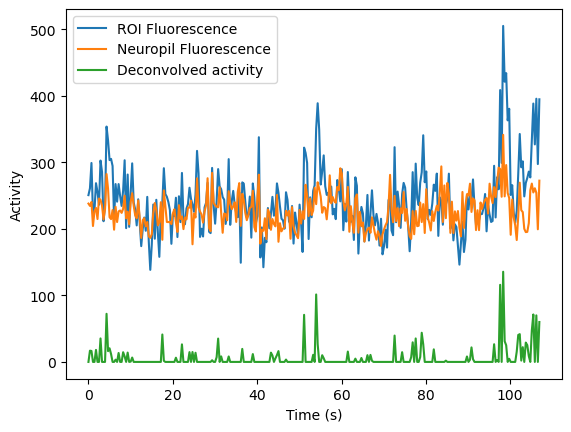

In [85]:
n_cells, n_t = outputs['F'].shape
frame_times = n.arange(n_t) / outputs['fs']
example_cell = 1200
plt.plot(frame_times, outputs['F'][example_cell], label='ROI Fluorescence')
plt.plot(frame_times, outputs['Fneu'][example_cell], label='Neuropil Fluorescence')
plt.plot(frame_times, outputs['spks'][example_cell], label='Deconvolved activity')
plt.legend()
plt.xlabel("Time (s)")
plt.ylabel("Activity")

In [78]:
# results of your manual curation will be saved here
# ROIs that are marked as cells will be 1, non-cells 0
iscell = outputs['iscell_curated_slider']

In [80]:
# suite2p-style list of all cells
cell_stats = outputs['stats']
print(cell_stats[example_cell].keys())

dict_keys(['idx', 'threshold', 'coords', 'lam', 'med', 'peak_val', 'patch_idx', 'med_patch', 'npcoords', 'npcoords_patch'])


In [97]:
cell_coords = [stat['coords'] for stat in cell_stats]
cell_centers = n.array([stat['med'] for stat in cell_stats])
vmap_shape = outputs['vmap'].shape

(<Figure size 1200x900 with 1 Axes>,
 <Axes: >,
 <matplotlib.image.AxesImage at 0x7fbb9e9d5190>)

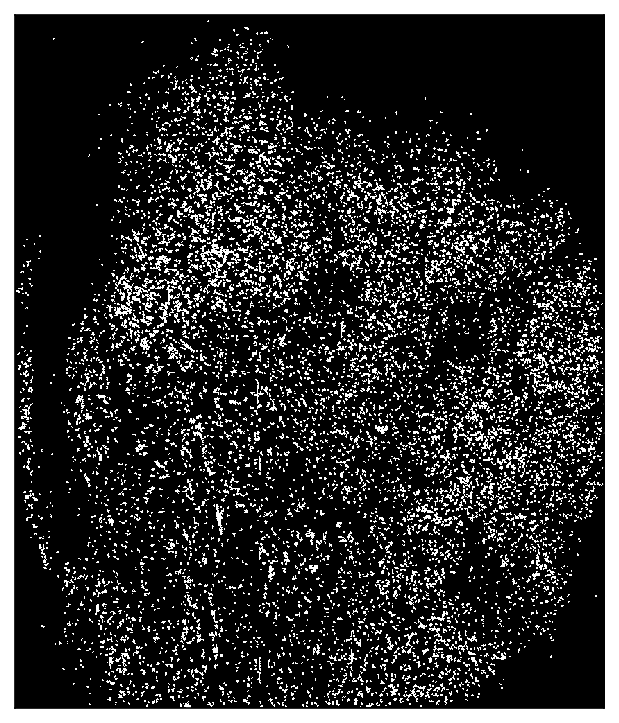

In [119]:
# make a volume with the footprints of all cells and plot a max-projection of it along z
cell_vol = ui.fill_cells_vol(cell_coords, fill_vals = n.ones(len(cell_coords)), empty=0)
tfu.show_tif((cell_vol ).max(axis=0))

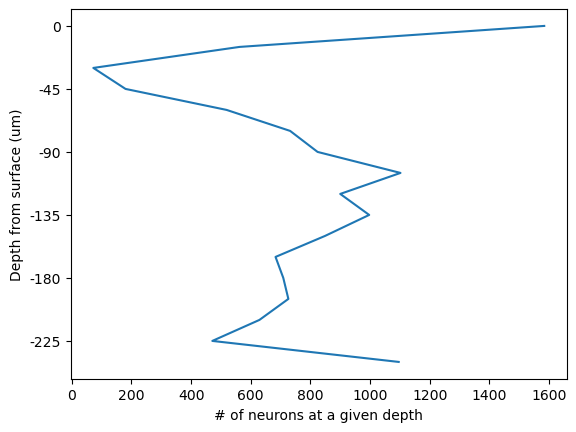

In [168]:
hist,bins = n.histogram(cell_centers[:,0],bins = n.arange(vmap_shape[0]))
bins = bins[:-1]

plt.plot(hist, bins)
plt.xlabel("# of neurons at a given depth")
plt.ylabel("Depth from surface (um)")
plt.yticks(n.arange(bins.max(),0,-bins.max()//6), -15*(bins.max()-n.arange(bins.max(),0,-bins.max()//6)));

# from the plot, seems like the shallowest plane has lots of cells, 
# possibly because it's out of the brain and it's mostly noise...
# it might be a good idea to exclude them in the curation 
# probably, when you have a longer recording you won't have this issue as much

### Save a fancy 3D plot
Use UCSF Chimera to open the .mrc file and visualize your cells

In [57]:
v1, v2 = ui.make_label_vols(outputs['stats'], outputs['vmap'].shape, 
            iscell =  outputs['iscell_curated_slider'], 
                  cmap='Blues', lam_max = 0.3)

In [58]:
tfu.save_mrc(combined_dir, 'curated_cells.mrc',v2[:,:,:,3], voxel_size=(4,4,15))